## Utils

In [78]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

import numpy as np
import pickle, os

from matplotlib import pyplot as plt
%matplotlib inline

# from scipy import signal
from gpbayes_utils import *

In [2]:
### functions (save in a separate file)

import argparse
import sys
np.set_printoptions(threshold=sys.maxsize)

# from scipy.interpolate import interp1d, PchipInterpolator
from scipy import interpolate
from scipy.spatial.distance import cdist

def interp_centerline(centerline_array, interp_num):
    ### inputs)
    ### centerline_array : shape(len, 2)
    ### interp_num : number of sample points from interpolated line
    
    interpSpl, u = interpolate.splprep([centerline_array[:,0], centerline_array[:,1]], s=10)
    u_interp = np.linspace(0, 1, num=interp_num)
    [centerline_x_interp, centerline_y_interp] = interpolate.splev(u_interp, interpSpl, der=0)
    centerline_interp = np.column_stack((centerline_x_interp[:], centerline_y_interp[:]))

    return centerline_interp  #shape(num=100, 2)


def tag_lane(track, centerlines_dict):
    ### inputs)
    ### track : shape(len(track), 9)
    ###  => columns: frame_id, x, y, vx, vy, psi_rad, agent_type, length, width
    ### centerlines_dict : dictionary of centerlines (keys: lanes)
    
    ### output
    ### track_tagged : shape(len(track), 7)
    ###  => columns: frame_id, x, y, agent_type, length, width, lane
    
    tags = []
    for p, _ in enumerate(track):
        min_dist_dict = dict()
#         lane_idx_dict = dict()
        for lane, centerline in centerlines_dict.items():                    
            min_dist_dict[lane] = np.min(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
#             lane_idx_dict[lane] = np.argmin(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
            
        lane_tag = min(min_dist_dict, key=min_dist_dict.get)
        tags.append([lane_tag]) #, lane_idx_dict[lane_tag]])

#         if p == 0 and lane_tag != 'c':
#             print('does not start in lane c')

    tags = np.array(tags)
    track_tagged = np.column_stack((track[:, :3], track[:, 6:], tags))
    
    return track_tagged


## Load & Construct vehicle tracks and centerlines

In [4]:
### load vehicle tracks

# scene = 'DR_CHN_Merging_ZS'
# filenum = '000'

# with open('../processed/INTERACTION/%s/veh_tracks_%s.pkl' % (scene, filenum), 'rb') as f:
#     veh_tracks_000 = pickle.load(f)
# print('veh_tracks_000', type(veh_tracks_000), len(veh_tracks_000))
   
# # tracks_dict[track_id] = np.empty((len(df_id), 9), dtype=object)
# # tracks_dict[track_id][:, 0] = df_id.frame_id  #t(100ms = 0.1s)
# # tracks_dict[track_id][:, 1] = df_id.x
# # tracks_dict[track_id][:, 2] = df_id.y
# # tracks_dict[track_id][:, 3] = df_id.vx
# # tracks_dict[track_id][:, 4] = df_id.vy
# # tracks_dict[track_id][:, 5] = df_id.psi_rad
# # tracks_dict[track_id][:, 6] = df_id.agent_type
# # tracks_dict[track_id][:, 7] = df_id.length
# # tracks_dict[track_id][:, 8] = df_id.width


In [3]:
### load & construct centerlines

import re
# from ssm_gp_utils import *

centerlines_path = 'dataset/modified_centerlines_/'
centerlines_listdir = os.listdir(centerlines_path)
print(centerlines_listdir, '\n')

centerlines_dict = dict()
lanes_list = []
for _, file in enumerate(centerlines_listdir):
    lane = re.split('_', file)[1].split('.')[0]

    if lane == 'c' or lane == 'd':
        print('lane', lane)
        
        centerline = open(os.path.join(centerlines_path, file), 'r')
        centerline_temp = [line.split(",") for line in centerline.readlines()]

        centerline_array = []
        for point in centerline_temp:        
            centerline_array.append((float(point[0]), float(point[1])))     
        centerline_array = np.array(centerline_array)
        
        centerline_interp = interp_centerline(centerline_array, 100)
        print('centerline interpolation', len(centerline_array), 'to', len(centerline_interp)) #, centerline_interp)

        centerlines_dict[lane] = centerline_interp
        lanes_list.append(lane)
    
print('\ncenterlines_dict', centerlines_dict.keys())
print('lanes_list', lanes_list)


['centerlines_b1.txt', 'centerlines_b2.txt', 'centerlines_e1.txt', 'centerlines_e2.txt', 'centerlines_f2.txt', 'centerlines_f1.txt', 'centerlines_a.txt', 'centerlines_c.txt', 'centerlines_g.txt', 'centerlines_d.txt'] 

lane c
centerline interpolation 37 to 100
lane d
centerline interpolation 37 to 100

centerlines_dict dict_keys(['c', 'd'])
lanes_list ['c', 'd']


In [4]:
from cubic_spline_planner import *
from scipy.spatial.distance import cdist

#### lane_c ####
lane_c_x = centerlines_dict['c'][:,0]  
lane_c_y = centerlines_dict['c'][:,1]
# ds = 0.1  # [m] distance of each intepolated points
num = 1000  # number of intepolated points

sp_c = Spline2D(lane_c_x, lane_c_y)
lane_c_s = np.arange(0, sp_c.s[-1], sp_c.s[-1]/num)

lane_c_rx, lane_c_ry = [], []
# lane_c_ryaw, lane_c_rk = , [], []
for i in range(len(lane_c_s)):
    xi, yi = sp_c.calc_position(lane_c_s[i])
    lane_c_rx.append(xi)
    lane_c_ry.append(yi)
#     lane_c_ryaw.append(sp_c.calc_yaw(lane_c_s[i]))
#     lane_c_rk.append(sp_c.calc_curvature(lane_c_s[i]))
lane_c_rxy = np.column_stack((lane_c_rx, lane_c_ry))



#### lane_d ####
lane_d_x = centerlines_dict['d'][:,0]  
lane_d_y = centerlines_dict['d'][:,1]

sp_d = Spline2D(lane_d_x, lane_d_y)
lane_d_s = np.arange(0, sp_d.s[-1], sp_d.s[-1]/num)

lane_d_rx, lane_d_ry = [], []
for i in range(len(lane_d_s)):
    xi, yi = sp_d.calc_position(lane_d_s[i])
    lane_d_rx.append(xi)
    lane_d_ry.append(yi)
lane_d_rxy = np.column_stack((lane_d_rx, lane_d_ry))


#### center of lane_c and lane_d
lane_cd_s = np.mean([lane_c_s, lane_d_s], axis=0)
lane_cd_rxy = np.mean([lane_c_rxy, lane_d_rxy], axis=0)

lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}


In [5]:
veh_tracks_path = '../processed/INTERACTION/DR_CHN_Merging_ZS/'
veh_tracks_listdir = os.listdir(veh_tracks_path)

actual_tracks_dict_all = dict()
actual_tracks_dict_idm = dict()
actual_tracks_dict_mobil = dict()

new_id = 0
t_span_file = [0,0]

for i, file in enumerate(veh_tracks_listdir[:1]):
    with open(os.path.join(veh_tracks_path, file), 'rb') as f:
        veh_tracks_i = pickle.load(f)
    print('veh_tracks_', i, type(veh_tracks_i), len(veh_tracks_i), min(list(veh_tracks_i.keys())), max(list(veh_tracks_i.keys())))

    t_span = [0, 0]
    for veh_id, track in veh_tracks_i.items():
        if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 954 and track[0, 2] < 963:  #lanes c,d
#         if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 960 and track[0, 2] < 963:  #lane c
            track_tagged = tag_lane(track, centerlines_dict)
#             print('track_tagged', track_tagged[:5])

            track_tagged_t_span = np.column_stack((track_tagged[:,0] + t_span_file[1], track_tagged[:,1:]))
            actual_tracks_dict_all[10000*i + veh_id] = track_tagged_t_span
            
            if len(set(track_tagged[:, 6])) == 1:
                actual_tracks_dict_idm[10000*i + veh_id] = track_tagged_t_span
            else: 
                actual_tracks_dict_mobil[10000*i + veh_id] = track_tagged_t_span            
            
            new_id += 1
            t_min = min((t_span[0], track_tagged_t_span[0,0]))
            t_max = max((t_span[1], track_tagged_t_span[-1,0]))
            t_span = [t_min, t_max]
            
    if veh_id == list(veh_tracks_i)[-1]:
        t_span_min = min((t_span_file[0], t_span[0]))
        t_span_max = max((t_span_file[1], t_span[1]))
        t_span_file = [t_span_min, t_span_max]
#         print('t_span', t_span, 't_span_file', t_span_file)


print('\nactual_tracks_dict_all', len(actual_tracks_dict_all), actual_tracks_dict_all[33].shape, actual_tracks_dict_all[33][:1,:]) #, actual_tracks_dict.keys())
print('actual_tracks_dict_idm', len(actual_tracks_dict_idm), actual_tracks_dict_idm[33].shape) #, actual_tracks_dict.keys())
print('actual_tracks_dict_mobil', len(actual_tracks_dict_mobil), 'veh_ids', actual_tracks_dict_mobil.keys())

print('\nt_span_file', t_span_file)

veh_tracks_ 0 <class 'dict'> 684 1 689

actual_tracks_dict_all 297 (149, 7) [[7 1137.807 961.0089999999999 'car' 5.56 1.98 'c']]
actual_tracks_dict_idm 277 (149, 7)
actual_tracks_dict_mobil 20 veh_ids dict_keys([116, 137, 142, 153, 207, 208, 293, 303, 323, 338, 382, 409, 417, 442, 486, 513, 527, 574, 587, 652])

t_span_file [0, 3512]


In [6]:
### x-y coord => s-d coord
### Reference: github.com/fjp/frenet
###           "Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenext Frame"


for veh_id, track in actual_tracks_dict_all.items():
    veh_d, veh_s = [], []
    veh_d_cd, veh_s_cd = [], []
    for i in range(len(track)):
        if track[i, 6] == 'c': 
            lane_rxy, lane_s = lane_c_rxy, lane_c_s
        elif track[i, 6] == 'd': 
            lane_rxy, lane_s = lane_d_rxy, lane_d_s

        ## s-d coordinate about its lane
        veh_xyi = track[i, 1:3]
        distances = cdist(np.array([veh_xyi]), lane_rxy, 'euclidean')
        veh_s.append(lane_s[np.argmin(distances)])
        if np.argmin(distances) == 0:
            lane_xyi = lane_rxy[np.argmin(distances)+1, :]
            lane_xyi_prev = lane_rxy[np.argmin(distances), :]
        else:
            lane_xyi = lane_rxy[np.argmin(distances), :]
            lane_xyi_prev = lane_rxy[np.argmin(distances)-1, :]
        [lane_dxi, lane_dyi]  = np.subtract(lane_xyi, lane_xyi_prev)
        [veh_dxi, veh_dyi] = np.subtract(veh_xyi, lane_xyi_prev)
        signi = np.sign(lane_dxi * veh_dyi - lane_dyi * veh_dxi)
        veh_d.append(np.min(distances) * signi)

        ## s-d coordinate about lane_cd_rxy
        distances_cd = cdist(np.array([veh_xyi]), lane_cd_rxy, 'euclidean')
        veh_s_cd.append(lane_cd_s[np.argmin(distances_cd)])
        
        if np.argmin(distances_cd) == 0:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd)+1, :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd), :]
        else:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd), :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd)-1, :]
        [lane_dxi_cd, lane_dyi_cd]  = np.subtract(lane_xyi_cd, lane_xyi_prev_cd)
        [veh_dxi_cd, veh_dyi_cd] = np.subtract(veh_xyi, lane_xyi_prev_cd)
        signi_cd = np.sign(lane_dxi_cd * veh_dyi_cd - lane_dyi_cd * veh_dxi_cd)
        veh_d_cd.append(np.min(distances_cd) * signi_cd)
    
    track_xy_new = np.column_stack((track[:,0:3], veh_s, veh_d, track[:,3:], veh_s_cd, veh_d_cd))
    actual_tracks_dict_all[veh_id] = track_xy_new

print('actual_tracks_dict_all', len(actual_tracks_dict_all), actual_tracks_dict_all[116].shape, actual_tracks_dict_all[116][:2,:])

# actual_tracks_dict_all[:][0] = frame_id  #t(100ms = 0.1s)
# actual_tracks_dict_all[:][1:3] = x, y
# actual_tracks_dict_all[:][3:5] = s, d
# actual_tracks_dict_all[:][5:8] = agent_type, length, width
# actual_tracks_dict_all[:][8] = lane
# actual_tracks_dict_all[:][9:11] = s_cd, d_cd  #s-d coord. about lane_cd_xy


actual_tracks_dict_all 297 (158, 11) [[424 1136.998 960.355 9.56492787105761 0.9566648829034947 'car' 4.2 1.76
  'c' 9.297836678024135 -0.9589301024614785]
 [425 1135.777 960.1239999999999 10.909995852925087 0.939903159073724
  'car' 4.2 1.76 'c' 10.647522647414736 -0.9785180383635913]]


In [7]:
import itertools

### include vel_sd, distance_headway, headway_vel_sd (within its lane)

def smoothing_vs_vd(veh_vsvd):
    w = 3  ## sliding window length
    
    veh_vsvd = np.array(veh_vsvd)
    vs, vd = veh_vsvd[:,0], veh_vsvd[:,1]
    
    vs_smooth_0 = np.convolve(vs, np.ones(w), 'valid') / w
    vs_smooth_0 = np.concatenate(([vs[0]], vs_smooth_0, [vs[-1]]))    
    vs_smooth = np.convolve(vs_smooth_0, np.ones(w), 'valid') / w
    vs_smooth = np.concatenate(([vs_smooth_0[0]], vs_smooth, [vs_smooth_0[-1]]))

    vd_smooth_0 = np.convolve(vd, np.ones(w), 'valid') / w
    vd_smooth_0 = np.concatenate(([vd[0]], vd_smooth_0, [vd[-1]]))
    vd_smooth = np.convolve(vd_smooth_0, np.ones(w), 'valid') / w
    vd_smooth = np.concatenate(([vd_smooth_0[0]], vd_smooth, [vd_smooth_0[-1]]))
    
    return np.column_stack((vs_smooth, vd_smooth))



actual_tracks_dict_all_with_headway = dict()
for veh_id, track in actual_tracks_dict_all.items():
#     if veh_id == 11 or veh_id == 116:

        veh_vsvd = []
        track_headway = []
        track_headway_prev = [None]*9
        for i in range(len(track)):
            t = track[i,0]

            if i == 0:
                veh_vsvd.append((track[i+1, 3:5] - track[i, 3:5])) # * 10) 
            else:
                veh_vsvd.append((track[i, 3:5] - track[i-1, 3:5])) # * 10) 

            dist_headway, veh_id_headway, idx_headway, lane_headway = 150, None, None, None
            track_xy_sd_headway, vsvd_headway = [None]*4, [None]*2
            
            for veh_id_other, track_other in actual_tracks_dict_all.items():
                if veh_id_other != veh_id and t >= track_other[0,0] and t <= track_other[-1,0] and track[i,8] in set(track_other[:,8]):

                    idx = np.where(track_other[:,0] == t)[0][0]      
                    dist_other = track_other[idx, 3] - track[i,3]  #dist_s
                        
                    if dist_other > 0 and dist_other < dist_headway and track[i,8] == track_other[idx,8]:
                        veh_id_headway = veh_id_other
                        idx_headway = idx
                        dist_headway = dist_other
                        track_xy_sd_headway = track_other[idx, 1:5]
                        lane_headway = track_other[idx, 8]

                        if idx == 0:
                            vsvd_headway = track_other[idx+1, 3:5] - track_other[idx, 3:5] # * 10
                        else:
                            vsvd_headway = track_other[idx, 3:5] - track_other[idx-1, 3:5] # * 10

            if veh_id_headway is None and track_headway_prev is None:
                track_headway.append([None]*10)
            elif veh_id_headway is not None:
                track_headway_prev = np.concatenate([np.array([veh_id_headway]), track_xy_sd_headway, vsvd_headway, \
                                    np.array([idx_headway]), np.array([dist_headway]), np.array([lane_headway])], axis=0)
#                 print('track_headway_prev', track_headway_prev.shape)
                track_headway.append(track_headway_prev) 
            elif veh_id_headway is None and track_headway_prev is not [None]*10:
                track_headway.append(track_headway_prev)
        veh_vsvd = smoothing_vs_vd(veh_vsvd)
        
        track_headway = np.array(track_headway)        
        actual_tracks_dict_all_with_headway[veh_id] = np.column_stack((track[:,:5], veh_vsvd, track[:,5:9], \
                                                                       track_headway, track[:,9:]))
    
print('\nactual_tracks_dict_all_with_headway', len(actual_tracks_dict_all_with_headway))
print('\nactual_tracks_dict_all_with_headway[116]', actual_tracks_dict_all_with_headway[116].shape, '\n',\
      actual_tracks_dict_all_with_headway[116][:1,:])
# print('\nactual_tracks_dict_all_with_headway[11]', actual_tracks_dict_all_with_headway[11].shape, '\n',\
#       actual_tracks_dict_all_with_headway[11][:1,:])



actual_tracks_dict_all_with_headway 297

actual_tracks_dict_all_with_headway[116] (158, 23) 
 [[424 1136.998 960.355 9.56492787105761 0.9566648829034947
  1.3450679818674764 -0.016761723829770703 'car' 4.2 1.76 'c' 114
  1124.2830000000001 958.6560000000001 22.417799697791274
  0.331996703895058 1.195615983882199 0.008816722280400646 11
  12.852871826733663 'c' 9.297836678024135 -0.9589301024614785]]


In [10]:
# actual_tracks_dict_all_with_headway[:][0] = frame_id  #t(in 0.1s)
# actual_tracks_dict_all_with_headway[:][1:3] = x, y
# actual_tracks_dict_all_with_headway[:][3:7] = s, d, vs, vd   #(vs,vd : m/s)
# actual_tracks_dict_all_with_headway[:][7:11] = agent_type, length, width, lane
# actual_tracks_dict_all_with_headway[:][11:14] = headway_veh_id, headway_x, headway_y 
# actual_tracks_dict_all_with_headway[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks_dict_all_with_headway[:][18:21] = headway_idx, dist_headway, headway_lane
# actual_tracks_dict_all_with_headway[:][21:23] = s_cd, d_cd  #s-d coord. about lane_cd_xy

In [8]:
actual_tracks_dict_all_with_headway.keys()

dict_keys([11, 32, 33, 35, 39, 41, 44, 46, 47, 52, 53, 55, 57, 61, 63, 65, 69, 72, 75, 78, 80, 85, 86, 87, 90, 91, 93, 94, 96, 97, 100, 101, 103, 104, 107, 109, 111, 114, 115, 116, 117, 118, 120, 121, 124, 125, 127, 128, 132, 134, 135, 136, 137, 139, 141, 142, 144, 147, 151, 152, 153, 155, 156, 157, 162, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 179, 181, 183, 185, 186, 188, 189, 192, 195, 196, 197, 199, 201, 203, 204, 206, 207, 208, 212, 214, 216, 219, 220, 222, 225, 228, 229, 233, 235, 237, 238, 242, 243, 246, 247, 251, 254, 259, 260, 264, 265, 268, 270, 273, 274, 280, 281, 283, 285, 289, 291, 293, 298, 302, 303, 305, 306, 309, 310, 312, 314, 317, 321, 323, 325, 326, 331, 332, 336, 338, 340, 344, 345, 347, 348, 351, 356, 358, 360, 362, 365, 367, 368, 373, 374, 378, 380, 382, 383, 385, 389, 392, 393, 397, 398, 402, 403, 406, 409, 412, 415, 417, 423, 424, 425, 428, 430, 433, 434, 437, 439, 440, 442, 445, 447, 448, 450, 451, 454, 456, 458, 461, 463, 465, 466, 467, 470, 474, 477,

In [9]:
for veh_id, track in actual_tracks_dict_all_with_headway.items():
    print('veh_id', veh_id, 'lane', track[0,10], track[-1,10], 'dist', track[:, 19])


veh_id 11 lane c c dist [None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None]
veh_id 32 lane d d dist [None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None N

veh_id 465 lane d d dist [63.50180775751016 63.351329540075305 63.501807757510164 63.50180775751016
 63.20085132264044 63.200851322640446 63.200851322640446
 63.050373105205594 62.89989488777073 62.74941667033586 62.59893845290101
 62.59893845290101 62.2979820180313 62.14750380059644 61.99702558316158
 61.84654736572672 61.545590930857 61.395112713422144 61.09415627855243
 60.793199843682714 60.49224340881299 60.34176519137813 60.04080875650842
 59.589374104203856 59.28841766933413 58.98746123446442 58.53602658215985
 58.23507014729012 57.93411371242041 57.63315727755069 57.18172262524612
 56.880766190376406 56.42933153807183 56.1283751032021 55.67694045089753
 55.225505798592955 54.924549363723244 54.62359292885352
 54.172158276548956 53.72072362424438 53.2692889719398 52.96833253707009
 52.51689788476551 52.2159414498958 51.91498501502608 51.61402858015637
 51.16259392785179 50.71115927554722 50.560681058112365 50.10924640580778
 49.65781175350321 49.507333536068344 49.20637710119864

## Animate trajectories

In [10]:
from matplotlib.patches import Rectangle

import sys
sys.path.append("python/")
from utils import map_vis_without_lanelet

from IPython.display import display
import ipywidgets

In [246]:
def animate_in_xy(actual_tracks_dict_idm_with_headway, t_0, t_end):
    scene = 'DR_CHN_Merging_ZS'
    map_file = 'maps/' + scene + '.osm'
    min_t, max_t = t_0, t_end # track[0,0], track[-1,0]

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        axes.set_title('timstep : 100 ms')
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_c_rx[0]+10, lane_c_ry[0]+2, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
        plt.arrow(lane_d_rx[0]+10, lane_d_ry[0]+1, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_c_rxy[:,0], lane_c_rxy[:,1], ".r", ms=0.5)
        plt.grid()
    
        for veh_id, track in actual_tracks_dict_idm_with_headway.items():
            idx = np.where(track[:,0]==t)[0] 
            
#             if len(idx_true) == 1 and veh_id != 120:
#                 plt.scatter(actual_tracks_dict_idm_with_headway[veh_id][idx_true, 1], 
#                             actual_tracks_dict_idm_with_headway[veh_id][idx_true, 2], s=100, c='y')
            
            if len(idx) == 1:
                plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
#                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
                plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')
#                 plt.text(track[idx, 1], track[idx, 2]+5, str("%.2f" % track[idx, 19]), fontsize=10, va="center", ha="center", color='green')
#                 plt.text(track[idx, 1], track[idx, 2]+5, str("%.2f" % track[idx, 5]), fontsize=10, va="center", ha="center", color='green')
                plt.text(track[idx, 1], track[idx, 2]+5, str("%.2f" % track[idx, 4]), fontsize=10, va="center", ha="center", color='green')

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 2))
    output = widget.children[-1]
    output.layout.height = '400px'
    display(widget)


In [244]:
t_0, t_end = 2900, 3150 
animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)

interactive(children=(IntSlider(value=3020, description='t', max=3150, min=2900, step=10), Output(layout=Layou…

In [247]:
t_0, t_end = 1000, 1500
animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)

interactive(children=(IntSlider(value=1250, description='t', max=1500, min=1000, step=2), Output(layout=Layout…

In [634]:

# actual_tracks_dict_all_with_headway[:][0] = frame_id  #t(in 0.1s)
# actual_tracks_dict_all_with_headway[:][1:3] = x, y
# actual_tracks_dict_all_with_headway[:][3:7] = s, d, vs, vd   #(vs,vd : m/s)
# actual_tracks_dict_all_with_headway[:][7:11] = agent_type, length, width, lane
# actual_tracks_dict_all_with_headway[:][11:14] = headway_veh_id, headway_x, headway_y 
# actual_tracks_dict_all_with_headway[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks_dict_all_with_headway[:][18:21] = headway_idx, dist_headway, headway_lane
# actual_tracks_dict_all_with_headway[:][21:23] = s_cd, d_cd  #s-d coord. about lane_cd_xy


## Expectation-Maximization

In [25]:
import itertools
import pickle

import scipy
import scipy.stats
from scipy.stats import multivariate_normal as multi_normal
from scipy.spatial import distance
import scipy.optimize
from scipy.optimize import fmin_l_bfgs_b as l_bfgs_b
from scipy.optimize import minimize


In [322]:
def get_a_IDM(xt, st, z):
    vt, rt, dt = xt[0], xt[1], xt[2]
    v_des = z
    a_max, b_pref, tau, d_min = 2.0, 2.0, 1.5, 3.0
#     a_max, b_pref, tau, d_min = 0.8, 4.0, 1.0, 5.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    d_des = min(max(d_des, 3.0), 10)
    
    if dt is None:
        dt = d_des #150
    else:
        dt = min(max(dt, 0.001), 100)

    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
#     print('a_IDM_mean', a_IDM_mean)
    a_IDM_mean = min(max(a_IDM_mean, -0.2), 0.2)

#     print('----- get_a_IDM -----')
#     print('vt', vt, 'rt', rt, 'dt', xt[2], 'dt_rev', dt, 'st', st, 'v_des', z, 'd_des', d_des)
    
    return a_IDM_mean
    
# def get_s_IDM(xt, st, z):
#     vt = xt[0]
#     a_IDM_mean = get_a_IDM(xt, st, z)
#     s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
#     return s_IDM_mean


def hallucinate_a_step_no_change(track_i, p_z):
#     print('hallucinate_a_step_no_change')

#     print('\ntrack_i: vels', track_i[5], ',lane:', track_i[11], ',None?:', track_i[11]==None)
    s_prev, d_prev = track_i[3], track_i[4]
    v_0 = track_i[5]
    
    if track_i[11] != None:  #if headway vehicle exists
        r_0, d_0 = track_i[5]-track_i[16], track_i[19]
    else:
        r_0 = v_0
        d_0 = None #150 - s_prev
            
#     s_pred = get_s_IDM([v_0, r_0, d_0], s_prev, p_z)
#     if type(s_pred) != float and s_pred.shape == (1,):
#         s_pred = s_pred[0]
#     s_next_pred = min(max(s_pred, s_prev + v_0 - 0.05), s_prev + v_0 + 0.05)
#     sd_next_pred = [s_next_pred, d_prev]

    a_pred = get_a_IDM([v_0, r_0, d_0], s_prev, p_z)
    v_pred = v_0 + a_pred
    v_pred = min(max(v_0, v_0 - 0.5), v_0 + 0.5)
    if type(v_pred) != float and v_pred.shape == (1,):
        v_pred = v_pred[0]
    vsvd_next_pred = np.array([v_pred, track_i[6]]).reshape((2,))
#     print('----- get_a_IDM -----')
#     print('v_0', v_0, 'r_0', r_0, 'd_0', d_0, 's_0', s_prev, 'v_des', p_z)
#     print('a_pred', a_pred, 'vsvd_next_pred', vsvd_next_pred, 'sd_next_pred', sd_next_pred

    s_next_pred = s_prev + v_0 + 0.5 * a_pred    
    sd_next_pred = [s_next_pred, d_prev]
    
    return sd_next_pred, vsvd_next_pred, a_pred
    

In [254]:
def get_sd_other_lane(sd_next_pred, xy_prev, lane_pred, lanes_rxy):
        
    ## get xy coordinates
    if lane_pred == 'c':
        sp_curr = sp_d
    elif lane_pred == 'd':
        sp_curr = sp_c
        
    lane_xi, lane_yi = sp_curr.calc_position(sd_next_pred[0])
    if lane_xi == None:
        return xy_prev, sd_next_pred  ##고쳐야함
    else:
        yawi = sp_curr.calc_yaw(sd_next_pred[0])
        xi_ret = lane_xi + sd_next_pred[1] * math.cos(yawi + math.pi / 2.0)
        yi_ret = lane_yi + sd_next_pred[1] * math.sin(yawi + math.pi / 2.0)
        veh_xyi_other = np.array([xi_ret, yi_ret])
       
    
    ## s-d coordinate about the lane_pred 
    if lane_pred == 'c':
        lane_rxy, lane_s = lane_c_rxy, lane_c_s
    elif lane_pred == 'd':
        lane_rxy, lane_s = lane_d_rxy, lane_d_s

    distances = cdist(np.array([veh_xyi_other]), lane_rxy, 'euclidean')
    veh_s_other = lane_s[np.argmin(distances)]

    if np.argmin(distances) == 0:
        lane_xyi = lane_rxy[np.argmin(distances)+1, :]
        lane_xyi_prev = lane_rxy[np.argmin(distances), :]
    else:
        lane_xyi = lane_rxy[np.argmin(distances), :]
        lane_xyi_prev = lane_rxy[np.argmin(distances)-1, :]
    [lane_dxi, lane_dyi] = np.subtract(lane_xyi, lane_xyi_prev)
    [veh_dxi, veh_dyi] = np.subtract(veh_xyi_other, lane_xyi_prev)
    signi = np.sign(lane_dxi * veh_dyi - lane_dyi * veh_dxi)
    veh_d_other = np.min(distances) * signi

    return veh_xyi_other, [veh_s_other, veh_d_other]


In [326]:
def hallucinate_a_step_change(track_i, lanes_rxy, z):
#     print('hallucinate_a_step_change')
    
    kp, kd = 0.02, 0

    if track_i[10] == 'c': 
        lane_curr_rxy = lanes_rxy['lane_c_rxy']; lane_new_rxy = lanes_rxy['lane_d_rxy']
    elif track_i[10] == 'd': 
        lane_curr_rxy = lanes_rxy['lane_d_rxy']; lane_new_rxy = lanes_rxy['lane_c_rxy']

    veh_xyi = track_i[1:3]
    
    distances_curr = cdist(np.array([veh_xyi]), lane_curr_rxy, 'euclidean')
    min_dist_curr = np.min(distances_curr)
    lane_curr_rxyi = lane_curr_rxy[np.argmin(distances_curr)]  #closest lane position

    distances_bet_lanes = cdist(np.array([lane_curr_rxyi]), lane_new_rxy, 'euclidean')
    min_dist_bet_lanes = np.min(distances_bet_lanes)
    lane_new_rxyi = lane_new_rxy[np.argmin(distances_bet_lanes)]  #closest lane_new position
    min_dist_new = cdist([veh_xyi], [lane_new_rxyi], 'euclidean')[0][0]
#     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)   
#     print('min_dist_curr', min_dist_curr, 'min_dist_new', min_dist_new)


    if track_i[10] == 'c': 
        offset = track_i[4] - min_dist_bet_lanes 
    elif track_i[10] == 'd': 
        offset = track_i[4] + min_dist_bet_lanes 
#     print('curr_d_pos', track_i[4],  'curr_vd', track_i[6], 'offset', offset)

    if min_dist_curr > min_dist_new: 
        if track_i[10] == 'c': 
            lane_pred = 'd'
        elif track_i[10] == 'd': 
            lane_pred = 'c'
    else:
        lane_pred = track_i[10]    
#     print('current_lane', track_i[10], 'lane_pred', lane_pred)


# #     print('-----hallucinate_a_step_change----')
# #     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)
#     plt.figure(figsize=(10,5))
#     plt.plot(lanes_rxy['lane_c_rxy'][:,0], lanes_rxy['lane_c_rxy'][:,1], ".r", ms=0.5)
#     plt.scatter(lane_curr_rxyi[0], lane_curr_rxyi[1], s=20, c='r')
#     plt.text(lane_curr_rxyi[0]+3, lane_curr_rxyi[1], np.round(min_dist,2), fontsize=10, va="center", ha="center", color='r')
    
#     plt.plot(lanes_rxy['lane_d_rxy'][:,0], lanes_rxy['lane_d_rxy'][:,1], ".g", ms=0.5)
#     plt.scatter(lane_new_rxyi[0], lane_new_rxyi[1], s=20, c='g')
#     plt.text(lane_new_rxyi[0]+3, lane_new_rxyi[1], np.round(min_dist_new,2), fontsize=10, va="center", ha="center", color='g')

#     plt.scatter(veh_xyi[0], veh_xyi[1], s=20, c='b')
#     plt.text(veh_xyi[0]+1, veh_xyi[1], track_i[10][0], fontsize=15, va="center", ha="center", color='b')
#     plt.xlim(1000, 1140); plt.ylim(950, 970)
#     plt.show()


#     sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(track_i, z)    
    v_lon_pred = track_i[5] #vsvd_next_pred[0] #track_i[5]
    s_lon_pred = track_i[3] + track_i[5] #sd_next_pred[0]  #track_i[3] + track_i[5]
    
    a_lat_pred = - offset * kp - track_i[6] * kd
    v_lat_pred = track_i[6] + a_lat_pred
    s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred    

    if lane_pred != track_i[10]:
#         print('lane_pred != track_i[10]', track_i[10], '=>', lane_pred)
        _, sd_next_pred = get_sd_other_lane([s_lon_pred, s_lat_pred], veh_xyi, lane_pred, lanes_rxy)
#         print('      sd:', [s_lon_pred, s_lat_pred], '=>', sd_next_pred)
    else:
        sd_next_pred = [s_lon_pred, s_lat_pred]

    return sd_next_pred, [v_lon_pred, v_lat_pred], lane_pred


In [309]:
t_0, t_end = 1000, 1450 #2950, 3150
tracks_xy_halluc_dict_em, rmse_list_em, _ = simulate_pos_bunch_em(actual_tracks_dict_all_with_headway, \
                                                                  mle_probs_final_all_veh, params_range, lanes_rxy, t_0, t_end)


veh_id 203 v_des [1.1] eps [0.1] pol [0.8499999999999999] lam [0.4]
veh_id 204 v_des [0.5] eps [0.30000000000000004] pol [0.6] lam [0.9999999999999999]
veh_id 206 v_des [1.4000000000000001] eps [0.1] pol [0.6] lam [1.2999999999999998]
veh_id 207 v_des [1.4000000000000001] eps [0.7000000000000001] pol [0.8499999999999999] lam [0.4]
veh_id 208 v_des [1.4000000000000001] eps [0.1] pol [0.1] lam [0.4]
veh_id 212 v_des [1.1] eps [0.5000000000000001] pol [0.8499999999999999] lam [0.4]


 t 1000


 t 1001


 t 1002


 t 1003


 t 1004


 t 1005


 t 1006


 t 1007


 t 1008


 t 1009


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1


-----veh_id 207 -----
...Lane-change switch is 1...
min_dist_curr 1.5196651460850672 min_dist_new 5.521195131766104
curr_d_pos 1.5191799665271055 curr_vd 0.16408647174977758 offset 5.520755603885133


 t 1151

-----veh_id 203 -----
...Lane-change switch is 1...
min_dist_curr 1.5182237362035196 min_dist_new 5.672348291687826
curr_d_pos -1.517368045307185 curr_vd -0.6207550068267579 offset -5.67217005738279

-----veh_id 207 -----
...Lane-change switch is 1...
min_dist_curr 1.6292916558116215 min_dist_new 5.63135383373908
curr_d_pos 1.6280588822380317 curr_vd 0.05367135967207491 offset 5.631857193975183


 t 1152

-----veh_id 203 -----
...Lane-change switch is 1...
min_dist_curr 2.0819590688137315 min_dist_new 6.237914142470737
curr_d_pos -2.081401351560115 curr_vd -0.507311605679102 offset -6.237704784948643

-----veh_id 207 -----
...Lane-change switch is 1...
min_dist_curr 1.6254742662753507 min_dist_new 5.630037350642708
curr_d_pos 1.6254116699703547 curr_vd -0.05896578420742875 offse

 t 1190

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -1.3072965964559717 track_i[6] -1.2046951791873626 track_i[10] d offset -1.3072965964559717
s_lat_pred -2.498918809678775

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] 4.706094940629417 track_i[6] 0.7275948991720383 track_i[10] c offset 4.706094940629417
s_lat_pred 5.386628890395161


 t 1191

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -2.498918809678775 track_i[6] -1.178549247258243 track_i[10] d offset -2.498918809678775
s_lat_pred -3.6524788688402303

-----veh_id 206 -----
...Lane-change switch was 0... => initiated lane-change
min_dist_curr 0.5375402098313713 min_dist_new 4.678170611037537
curr_d_pos 0.5369511125918585 curr_vd -0.008462474381572549 offset 4.678055823622981

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] 5.386628890395161 track_i[6] 0.63347300035945 track_i[10] c offset 5.386628890395161
s_lat_pred 5.966235601850659


 t 1192

-----veh_id


-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] -3.2062578418802983 track_i[6] -0.9852139505033808 track_i[10] c offset -3.2062578418802983
s_lat_pred -4.159409213964875


 t 1211

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -0.24286051233567596 track_i[6] 1.3441835665756936 track_i[10] d offset -0.24286051233567596
s_lat_pred 1.1037516593633745

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] -4.159409213964875 track_i[6] -0.9210887936657748 track_i[10] c offset -4.159409213964875
s_lat_pred -5.038903915491002


 t 1212

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] 1.1037516593633745 track_i[6] 1.349040776822407 track_i[10] d offset 1.1037516593633745
s_lat_pred 2.4417549195921477

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] -5.038903915491002 track_i[6] -0.8379006093864773 track_i[10] c offset -5.038903915491002
s_lat_pred -5.826415485722569


 t 1213

-----veh_id 203 -----
...Lane-change swit

 t 1236

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -3.8026572408621995 track_i[6] -1.4451944280028461 track_i[10] d offset -3.8026572408621995
s_lat_pred -5.209825096456424

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] 7.079032667257044 track_i[6] 0.7293883926041582 track_i[10] c offset 7.079032667257044
s_lat_pred 7.737630733188632


 t 1237

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -5.209825096456424 track_i[6] -1.3691412831856022 track_i[10] d offset -5.209825096456424
s_lat_pred -6.526868128677461

-----veh_id 207 -----
...Lane-change switch was 2...
track_i[4] 7.737630733188632 track_i[6] 0.5878077392590173 track_i[10] c offset 7.737630733188632
s_lat_pred 8.248062165115762


 t 1238

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -6.526868128677461 track_i[6] -1.2649447812564738 track_i[10] d offset -6.526868128677461
s_lat_pred -7.72654422864716

-----veh_id 207 -----
...Lane-change switch was 2...


In [310]:
t_0, t_end = 1000, 1250
animate_in_xy_simulate(tracks_xy_halluc_dict_em, actual_tracks_dict_all_with_headway, t_0, t_end)


interactive(children=(IntSlider(value=1125, description='t', max=1250, min=1000), Output(layout=Layout(height=…

In [342]:
def get_accel_neighbors_EM(veh_id, track_i, z_i, actual_tracks_dict_all_with_headway, mle_probs_final_all_veh, params_range):
#     print('get_accel_neighbors_EM')

#     if len(mle_probs_final_all_veh.keys()) > 0:
#         print('get_accel_neighbors: mle_probs_final_all_veh', mle_probs_final_all_veh)

    t = track_i[0]
    v_des_range = params_range['z']
    
    ## compute a_ego
    if veh_id in mle_probs_final_all_veh.keys():
        v_des_probs = mle_probs_final_all_veh[veh_id][0]
        v_des_ego = np.random.choice(v_des_range, size=1, p=v_des_probs)
    else: 
        v_des_ego = z_i
        
    _, _, a_ego = hallucinate_a_step_no_change(track_i, v_des_ego)
    
    ## find old/new followers           
    veh_id_old, idx_old, dist_old = None, None, None
    veh_id_new, idx_new, dist_new = None, None, None
    for veh_id_other, track_other in actual_tracks_dict_all_with_headway.items():
        if veh_id_other != veh_id and t >= track_other[0,0] and t <= track_other[-1,0]:
            idx = np.where(track_other[:,0] == t)[0]
#             print('idx', idx)
            
            if len(idx) == 1:
                dist_other = distance.euclidean(track_i[1:3], track_other[idx[0], 1:3])  #dist_xy

                if dist_old == None and dist_new == None:
                    dist_old = 100 #- track_i[3]
                    dist_new = 100 #- track_i[3]
                    
                elif dist_other > 0 and track_i[10] == track_other[idx[0],10] and dist_other < dist_old:
                    veh_id_old, idx_old, dist_old = veh_id_other, idx[0], dist_other
                elif dist_other > 0 and track_i[10] != track_other[idx,10] and dist_other < dist_new:
                    veh_id_new, idx_new, dist_new = veh_id_other, idx[0], dist_other

    ## compute a_old, a_old_tilde, a_new, a_new_tilde
    if veh_id_old is not None: 
        track_old = actual_tracks_dict_all_with_headway[veh_id_old][idx_old,:]
        v_old, r_old, d_old = track_old[5], track_old[5] - track_i[5], track_i[3] - track_old[3]
#         if track_old[16] != track_i[5] or track_i[3] - track_old[3] != track_old[19]:
#             print('veh_id_old: ', veh_id_old, 'headway', track_old[11], 'vel', track_old[16], track_i[5], 'dist', track_i[3] - track_old[3], track_old[19])
        s_prev_old = track_old[3]
        if veh_id_old in mle_probs_final_all_veh.keys():
            v_des_old_probs = mle_probs_final_all_veh[veh_id_old][0]
            v_des_old = np.random.choice(v_des_range, size=1, p=v_des_old_probs)        
        else: 
            v_des_old = z_i
        a_old = get_a_IDM([v_old, r_old, d_old], s_prev_old, v_des_old)
        
        if track_old[11] is not None and track_i[11] is not None:
            r_old_tilde, d_old_tilde = track_old[5] - track_i[16], d_old + track_i[19]
        else:
            r_old_tilde, d_old_tilde = track_old[5], 100 #- track_old[3]
        a_old_tilde = get_a_IDM([v_old, r_old_tilde, d_old_tilde], s_prev_old, v_des_old)
    else:
        a_old, a_old_tilde = 0.0, 0.0
        
    if veh_id_new is not None:      
        track_new = actual_tracks_dict_all_with_headway[veh_id_new][idx_new,:]
        if track_new[11] is not None:
            v_new, r_new, d_new = track_new[5], track_new[5] - track_new[16], track_new[19]
        else:
            v_new, r_new, d_new = track_new[5], track_new[5], 100 #- track_new[3]
                
        s_prev_new = track_new[3]
        if veh_id_new in mle_probs_final_all_veh.keys():
            v_des_new_probs = mle_probs_final_all_veh[veh_id_new][0]
            v_des_new = np.random.choice(v_des_range, size=1, p=v_des_new_probs)    
        else:
            v_des_new = z_i
        a_new = get_a_IDM([v_new, r_new, d_new], s_prev_new, v_des_new)
        
        r_new_tilde, d_new_tilde = track_new[5] - track_i[5], track_i[3] - track_new[3]     
        a_new_tilde = get_a_IDM([v_new, r_new_tilde, d_new_tilde], s_prev_new, v_des_new)
        
        if track_new[11] is not None:
            v_ego, r_ego_tilde, d_ego_tilde = track_i[5], track_i[5]-track_new[16], track_new[14]-track_i[3]
        else:
            v_ego, r_ego_tilde, d_ego_tilde = track_i[5], track_i[5], 100 #- track_i[3]
        s_prev_ego = track_i[3]
        a_ego_tilde = get_a_IDM([v_ego, r_ego_tilde, d_ego_tilde], s_prev_ego, v_des_ego)
    else:
        a_new, a_new_tilde = 0.0, 0.0
        a_ego_tilde = a_ego  ### 고쳐야함! veh_id_new가 없어도 lead는 있을수 있으니까..
    return [a_ego, a_ego_tilde, a_old, a_new, a_old_tilde, a_new_tilde], veh_id_new
                                
        
def get_lane_change_prob_EM(veh_id, track_i, z_i, pol_i, lam_i, actual_tracks_dict_all_with_headway, mle_probs_final_all_veh, params_range):
#     print('get_lane_change_prob_EM')
    [a_ego, a_ego_tilde, a_old, a_new, a_old_tilde, a_new_tilde], veh_id_new = get_accel_neighbors_EM(veh_id, track_i, z_i, actual_tracks_dict_all_with_headway, \
                                                                                                      mle_probs_final_all_veh, params_range)
    a_thr, b_safe = 0.2, 3.0
    
    if -a_new_tilde <= b_safe:
        mobil = a_ego_tilde - a_ego + pol_i * (a_new_tilde - a_new + a_old_tilde - a_old) - a_thr
        sigmoid_mobil = 1/(1 + np.exp(- lam_i * mobil))

        return sigmoid_mobil, mobil, veh_id_new
    else:
        return 0, 0, veh_id_new


In [201]:
def EM(veh_id, track, actual_tracks_dict_all_with_headway, lanes_rxy, params_range, mle_probs_final_all_veh, max_iter_per_veh):

    idx_range = [range(len(p_range)) for p_range in params_range.values()]
    [z_range, eps_range, pol_range, lam_range] = [p_range for p_range in params_range.values()]

#     mle_probs = [np.ones_like(p_range) / len(p_range) for p_range in params_range]
    mle_probs = [np.random.dirichlet(np.ones_like(p_range)) for p_range in params_range.values()]
    print('initial mle_probs', mle_probs)
    
    mle_probs_history= []
    marginal_ll_history = []
    prev_marginal_ll = -np.infty
    tol = 1 #0.1
    
    for it in range(1, max_iter_per_veh):
        print('\nit', it)
        [z_probs, eps_probs, pol_probs, lam_probs] = mle_probs
#         print('z_probs', z_probs, 'eps_probs', eps_probs, 'pol_probs', pol_probs, 'lam_probs', lam_probs)
        
        ## E-step : update weights (Q's)
        p_x_given_z = np.zeros((len(track)-1, len(z_range), len(eps_range), len(pol_range), len(lam_range)))
        p_xz = np.zeros((len(track)-1, len(z_range), len(eps_range), len(pol_range), len(lam_range)))

        for i in range(len(track)-1):  
            for z_idx, eps_idx, pol_idx, lam_idx in itertools.product(*idx_range):

                ## if do not change lane
                sd_next_pred_no_change, _, _ = hallucinate_a_step_no_change(track[i], z_range[z_idx])  #IDM
                sd_next_true = track[i+1, 3:5]
                likeli_pos_no_change = multi_normal([sd_next_pred_no_change[0]], eps_range[eps_idx]).pdf([sd_next_true[0]]) #observation model

                ## if change lane
                sd_next_pred_change, _, pred_lane = hallucinate_a_step_change(track[i], lanes_rxy, z_range[z_idx])  #pd controller (lane change) 
                xy_prev, veh_lane = track[i, 1:3], track[i, 10]
                _, sd_cd_next_true = get_xy_sd_cd(sd_next_true, xy_prev, veh_lane, lanes_rxy)
                _, sd_cd_next_pred_change = get_xy_sd_cd(sd_next_pred_change, xy_prev, pred_lane, lanes_rxy)
                likeli_pos_change = multi_normal(sd_cd_next_pred_change, eps_range[eps_idx]*2).pdf(sd_cd_next_true) #observation model

                ## probability of changing lane & likelihood
                prob_lane, _, _ = get_lane_change_prob_EM(veh_id, track[i], z_range[z_idx], pol_range[pol_idx], lam_range[lam_idx], \
                                                          actual_tracks_dict_all_with_headway, mle_probs_final_all_veh, params_range)  #MOBIL

                p_x_given_z[i, z_idx, eps_idx, pol_idx, lam_idx] = likeli_pos_no_change * (1-prob_lane) + \
                                                                   likeli_pos_change * prob_lane  #p(x|z)
                
                p_xz[i, z_idx, eps_idx, pol_idx, lam_idx] = p_x_given_z[i, z_idx, eps_idx, pol_idx, lam_idx] * \
                                                            z_probs[z_idx] * eps_probs[eps_idx] * \
                                                            pol_probs[pol_idx] * lam_probs[lam_idx]  #p(x,z)=p(x|z)p(z)
                
        Q = p_xz / np.sum(p_xz, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights (n, 6, 5, 4, 5)

        marginal_ll = np.sum(np.log(np.sum(p_xz, axis=(1,2,3,4))))
        print('marginal likelihood :', marginal_ll)
        
        
        ## M-step
        theta_init = np.concatenate([z_probs, eps_probs, pol_probs, lam_probs]).ravel()
        ticks = [len(z_range), len(z_range)+len(eps_range), len(z_range)+len(eps_range)+len(pol_range), len(theta_init)]  
        arguments = (p_x_given_z, Q, params_range, ticks)
        
        theta_opt, f_opt, d = l_bfgs_b(obj_function, x0=theta_init, args=arguments, approx_grad=True, \
                                       maxfun=5, maxiter=10)  # bounds=[(0,1)]*len(theta_init), \
        
#         cons = ({'type': 'eq', 'fun': lambda theta, ticks: np.round(theta[:ticks[0]].sum()**2, 6) - 1, 'args': (ticks,)},
#                 {'type': 'eq', 'fun': lambda theta, ticks: np.round(theta[ticks[0]:ticks[1]].sum()**2, 6) - 1, 'args': (ticks,)},
#                 {'type': 'eq', 'fun': lambda theta, ticks: np.round(theta[ticks[1]:ticks[2]].sum()**2, 6) - 1, 'args': (ticks,)},
#                 {'type': 'eq', 'fun': lambda theta, ticks: np.round(theta[ticks[2]:].sum()**2, 6) - 1, 'args': (ticks,)})
#         result = minimize(obj_function, x0=theta_init, args=arguments, method='L-BFGS-B', \
#                           constraints=cons) #, bounds=[(0,1)]*len(theta_init), options={'maxiter': 20, 'disp': True})
#         theta_opt, f_opt = result.x, result.fun
        
        if marginal_ll - prev_marginal_ll > 0:
            print('updated...')
            marginal_ll_final = marginal_ll
            marginal_ll_history.append(marginal_ll)
            
            mle_probs_unnormalized = [theta_opt[:ticks[0]], theta_opt[ticks[0]:ticks[1]], theta_opt[ticks[1]:ticks[2]], theta_opt[ticks[2]:]]
            print('mle_probs_unnormalized', mle_probs_unnormalized)
            
            z_probs = theta_opt[:ticks[0]] / theta_opt[:ticks[0]].sum()
            eps_probs = theta_opt[ticks[0]:ticks[1]] / theta_opt[ticks[0]:ticks[1]].sum()
            pol_probs = theta_opt[ticks[1]:ticks[2]] / theta_opt[ticks[1]:ticks[2]].sum()
            lam_probs = theta_opt[ticks[2]:] / theta_opt[ticks[2]:].sum()
            mle_probs = [z_probs, eps_probs, pol_probs, lam_probs]
            mle_probs_history.append(mle_probs)
            
#             mle_probs = [theta_opt[:ticks[0]], theta_opt[ticks[0]:ticks[1]], theta_opt[ticks[1]:ticks[2]], theta_opt[ticks[2]:]]
            print('mle_probs_normalized', mle_probs)
            
            if marginal_ll - prev_marginal_ll < tol:
                print('Break in %s iterations' % it)
                break 
            prev_marginal_ll = marginal_ll
    
    mle_probs_final = mle_probs
    converged_iter = it
    return mle_probs_final, mle_probs_history, marginal_ll_final, marginal_ll_history, converged_iter


In [174]:
def obj_function(theta, p_x_given_z, Q, params_range, ticks):
#     print('\nobj_function...')

    idx_range = [range(len(p_range)) for p_range in params_range.values()]
    [z_range, eps_range, pol_range, lam_range] = [p_range for p_range in params_range.values()]
    z_probs, eps_probs, pol_probs, lam_probs = theta[:ticks[0]], theta[ticks[0]:ticks[1]], theta[ticks[1]:ticks[2]], theta[ticks[2]:]

    p_xz = np.zeros((len(p_x_given_z), len(z_range), len(eps_range), len(pol_range), len(lam_range)))   #(n, 6, 5, 4, 5)
    for z_idx, eps_idx, pol_idx, lam_idx in itertools.product(*idx_range):
        p_xz[:, z_idx, eps_idx, pol_idx, lam_idx] = z_probs[z_idx] * eps_probs[eps_idx] * \
                                                    pol_probs[pol_idx] * lam_probs[lam_idx] #* \
#                                                     p_x_given_z[:, z_idx, eps_idx, pol_idx, lam_idx]

#         print('p_xz.sum', p_xz.sum(axis=(1,2,3,4)))
#     print('Q * np.log(p_xz)', (Q * np.log(p_xz)).shape)
    ELBO = np.sum(Q * np.log(p_xz))
#     print('ELBO', ELBO)
    return -ELBO
    

In [149]:
def run_EM_plot(actual_tracks_dict_all_with_headway, lanes_rxy, max_iter_per_veh, params_range, veh_id_minmax):
        
    mle_probs_final_all_veh, mle_probs_history_all_veh =  dict(), dict()
    marginal_ll_final_all_veh, marginal_ll_history_all_veh =  dict(), dict()
    converged_iter_all_veh = dict()
    
    for veh_id, track in actual_tracks_dict_all_with_headway.items():
        if veh_id >= veh_id_minmax[0] and veh_id < veh_id_minmax[1]:  #veh_id>= 203 and veh_id < 210:
            print('\n veh_id', veh_id)
            mle_probs_final, mle_probs_history, marginal_ll_final, marginal_ll_history, converged_iter = \
                EM(veh_id, track, actual_tracks_dict_all_with_headway, lanes_rxy, params_range, mle_probs_final_all_veh, max_iter_per_veh)  
            
            mle_probs_final_all_veh[veh_id] = mle_probs_final
            mle_probs_history_all_veh[veh_id] = mle_probs_history
            marginal_ll_final_all_veh[veh_id] = marginal_ll_final
            marginal_ll_history_all_veh[veh_id] = marginal_ll_history
            converged_iter_all_veh[veh_id] = converged_iter

    return mle_probs_final_all_veh, mle_probs_history_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh


In [58]:
# z_min, z_max = 0.8, 2.0
# eps_min, eps_max = 0.15, 0.3
# pol_min, pol_max = 0.1, 0.8
# lam_min, lam_max = 0.6, 1.05


z_min, z_max = 0.5, 1.8
eps_min, eps_max = 0.1, 0.8
pol_min, pol_max = 0.1, 1.0
lam_min, lam_max = 0.4, 1.5

# z_min, z_max = 0.5, 1.6
# eps_min, eps_max = 0.1, 1.0
# pol_min, pol_max = 0.1, 1.2
# lam_min, lam_max = 0.5, 1.6

# params_range = np.linspace((z_min, eps_min, pol_min, lam_min), (z_max, eps_max, pol_max, lam_max), 5).T
# print('params_range\n', params_range)

# params_range = [np.arange(z_min, z_max, 0.2), #0.15),
#                 np.arange(eps_min, eps_max, 0.2), # 0.03),
#                 np.arange(pol_min, pol_max, 0.2),
#                 np.arange(lam_min, lam_max, 0.2)] #0.1)]
# print('params_range\n', np.array(params_range))


params_range = {'z': np.arange(z_min, z_max, 0.3),
               'eps': np.arange(eps_min, eps_max, 0.2),
               'pol': np.arange(pol_min, pol_max, 0.25),
               'lam': np.arange(lam_min, lam_max, 0.3)}
print('params_range\n', params_range) #np.array(params_range))


params_range
 {'z': array([0.5, 0.8, 1.1, 1.4, 1.7]), 'eps': array([0.1, 0.3, 0.5, 0.7]), 'pol': array([0.1 , 0.35, 0.6 , 0.85]), 'lam': array([0.4, 0.7, 1. , 1.3])}


In [363]:
z_min, z_max = 0.5, 2.0
eps_min, eps_max = 0.1, 0.7
pol_min, pol_max = 0.1, 1.0
lam_min, lam_max = 0.1, 1.8

# z_min, z_max = 0.5, 1.6
# eps_min, eps_max = 0.1, 1.0
# pol_min, pol_max = 0.1, 1.2
# lam_min, lam_max = 0.5, 1.6

# params_range = np.linspace((z_min, eps_min, pol_min, lam_min), (z_max, eps_max, pol_max, lam_max), 5).T
# print('params_range\n', params_range)

# params_range = [np.arange(z_min, z_max, 0.15), #0.2), #0.15),
#                 np.arange(eps_min, eps_max, 0.03), #0.2), # 0.03),
#                 np.arange(pol_min, pol_max, 0.2),
#                 np.arange(lam_min, lam_max, 0.1)] #0.2)] #0.1)]
# print('params_range\n', np.array(params_range))

params_range = {'z': np.arange(z_min, z_max, 0.15),
               'eps': np.arange(eps_min, eps_max, 0.03),
               'pol': np.arange(pol_min, pol_max, 0.2),
               'lam': np.arange(lam_min, lam_max, 0.1)}
print('params_range\n', params_range) #np.array(params_range))



params_range
 {'z': array([0.5 , 0.65, 0.8 , 0.95, 1.1 , 1.25, 1.4 , 1.55, 1.7 , 1.85]), 'eps': array([0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4 ,
       0.43, 0.46, 0.49, 0.52, 0.55, 0.58, 0.61, 0.64, 0.67]), 'pol': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'lam': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7])}


In [361]:
mle_probs_final_all_veh[203][2].shape

(5,)

In [335]:
veh_id_minmax = [203, 220] #[210, 220]
max_iter_per_veh = 8
lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

mle_probs_final_all_veh, mle_probs_history_all_veh, \
marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh = \
    run_EM_plot(actual_tracks_dict_all_with_headway, lanes_rxy, max_iter_per_veh, params_range, veh_id_minmax)


 veh_id 203
initial mle_probs [array([0.35506566, 0.23317938, 0.12297169, 0.08212296, 0.20666031]), array([0.55179311, 0.21786708, 0.07219342, 0.1581464 ]), array([8.11453463e-05, 5.56648528e-01, 3.95020187e-01, 4.82501395e-02]), array([0.36906227, 0.56602574, 0.01789963, 0.04701236])]

it 1
marginal likelihood : -74.3456090547968
updated...
mle_probs_unnormalized [array([0.6045239 , 0.48512173, 0.37546775, 0.33549374, 0.45995396]), array([0.89307357, 0.39019049, 0.19918658, 0.26246193]), array([0.25037445, 0.80777469, 0.64695861, 0.30099357]), array([0.61918102, 0.81804105, 0.27179658, 0.3027704 ])]
mle_probs_normalized [array([0.26742206, 0.21460235, 0.16609494, 0.14841171, 0.20346894]), array([0.51181566, 0.22361607, 0.11415276, 0.15041552]), array([0.12480648, 0.40265897, 0.32249548, 0.15003907]), array([0.30777632, 0.40662367, 0.13510193, 0.15049808])]

it 2
marginal likelihood : -81.04920317838375

it 3
marginal likelihood : -81.04920317838375

it 4
marginal likelihood : -81.049

marginal likelihood : -129.69024818316143
updated...
mle_probs_unnormalized [array([0.73358597, 0.25900369, 0.26638352, 0.27651836, 0.63733945]), array([0.67150954, 0.40352973, 0.53626164, 0.35344636]), array([0.2536203 , 0.70030909, 0.47130753, 0.50670335]), array([0.32543569, 0.95364335, 0.25896031, 0.39775493])]
mle_probs_normalized [array([0.33761759, 0.11920103, 0.12259744, 0.12726179, 0.29332215]), array([0.34177909, 0.20538506, 0.27294179, 0.17989406]), array([0.13127751, 0.36249003, 0.24395554, 0.26227692]), array([0.16811481, 0.49263672, 0.13377471, 0.20547376])]

it 2
marginal likelihood : -102.99723756133957
updated...
mle_probs_unnormalized [array([0.57593796, 0.36051092, 0.36619533, 0.37140195, 0.53728995]), array([0.7405391 , 0.40926496, 0.42387675, 0.3042045 ]), array([0.37069982, 0.60331841, 0.48619212, 0.50590218]), array([0.40641097, 0.73342432, 0.37708122, 0.45120194])]
mle_probs_normalized [array([0.26044795, 0.16302855, 0.16559913, 0.16795364, 0.24297073]), array([

marginal likelihood : -108.33447705931704
updated...
mle_probs_unnormalized [array([0.44193228, 0.25373985, 0.850429  , 0.27448199, 0.30701935]), array([0.56107979, 0.63423756, 0.60767668, 0.23583606]), array([0.85135009, 0.29725147, 0.25105029, 0.50888029]), array([0.29238984, 0.83197679, 0.29364907, 0.4851582 ])]
mle_probs_normalized [array([0.20771375, 0.11926093, 0.39971236, 0.12901   , 0.14430297]), array([0.27519693, 0.31107917, 0.29805165, 0.11567225]), array([0.44607585, 0.15574874, 0.13154103, 0.26663438]), array([0.15363275, 0.43715227, 0.1542944 , 0.25492058])]

it 2
marginal likelihood : -79.42660704389687
updated...
mle_probs_unnormalized [array([0.44635   , 0.35801512, 0.63988179, 0.36860066, 0.38370875]), array([0.68667503, 0.52085111, 0.45320085, 0.24328858]), array([0.68308491, 0.3948052 , 0.37267774, 0.5097433 ]), array([0.3892195 , 0.67534371, 0.39501355, 0.4982746 ])]
mle_probs_normalized [array([0.20320444, 0.16298928, 0.29131135, 0.16780843, 0.17468651]), array([0

marginal likelihood : -54.2850895646437
updated...
mle_probs_unnormalized [array([0.44892504, 0.44504638, 0.44500013, 0.44843012, 0.45019881]), array([0.80774862, 0.41962946, 0.32218215, 0.25991238]), array([0.49289122, 0.50328026, 0.49458854, 0.49934449]), array([0.48611759, 0.48705174, 0.49956626, 0.51694429])]
mle_probs_normalized [array([0.20062788, 0.19889448, 0.19887381, 0.2004067 , 0.20119714]), array([0.44640002, 0.23190705, 0.17805307, 0.14363985]), array([0.24767102, 0.25289137, 0.2485239 , 0.2509137 ]), array([0.2443195 , 0.244789  , 0.25107871, 0.25981279])]

it 7
marginal likelihood : -53.295448797519754
updated...
mle_probs_unnormalized [array([0.4473685 , 0.44638346, 0.44708456, 0.44894025, 0.44964187]), array([0.81328614, 0.41845549, 0.31591635, 0.25709836]), array([0.49280858, 0.49985762, 0.49732189, 0.50152843]), array([0.48844803, 0.49138945, 0.50016758, 0.51127332])]
mle_probs_normalized [array([0.19976993, 0.19933006, 0.19964314, 0.20047179, 0.20078509]), array([0.

In [781]:
veh_id_minmax = [203, 210] #[210, 220]
max_iter_per_veh = 10
lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

mle_probs_final_all_veh, mle_probs_history_all_veh, \
marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh = \
    run_EM_plot(actual_tracks_dict_all_with_headway, lanes_rxy, max_iter_per_veh, params_range, veh_id_minmax)


 veh_id 203
initial mle_probs [array([0.03932163, 0.16906969, 0.25248161, 0.02196722, 0.23053579,
       0.28662407]), array([0.17380944, 0.40965572, 0.28273941, 0.09964559, 0.03414984]), array([0.33641006, 0.11320109, 0.21402007, 0.30542046, 0.00038197,
       0.03056636]), array([0.12228793, 0.10934361, 0.35818796, 0.03411315, 0.02365999,
       0.35240736])]

it 0
marginal likelihood : -149.0739649531757
updated...
mle_probs_unnormalized [array([0.24235569, 0.37300691, 0.45758523, 0.22756648, 0.43698746,
       0.49297803]), array([0.56740538, 0.60667533, 0.42774986, 0.21872513, 0.13717371]), array([0.54033099, 0.31810947, 0.41991122, 0.51228847, 0.20821712,
       0.239366  ]), array([0.32426478, 0.31259384, 0.56270805, 0.23989875, 0.23070568,
       0.56070694])]
mle_probs_normalized [array([0.1086563 , 0.16723169, 0.20515103, 0.1020258 , 0.19591635,
       0.22101883]), array([0.2898283 , 0.30988722, 0.21849284, 0.11172388, 0.07006776]), array([0.24141068, 0.14212589, 0.18760917

marginal likelihood : -104.46138569098639
updated...
mle_probs_unnormalized [array([0.33962807, 0.49970515, 0.29880944, 0.31383732, 0.40138613,
       0.37621029]), array([0.65044238, 0.31398234, 0.38808723, 0.44580844, 0.16831123]), array([0.43977617, 0.3308847 , 0.39843676, 0.29896261, 0.30832784,
       0.4521922 ]), array([0.30841431, 0.56617764, 0.35733571, 0.3383426 , 0.32143113,
       0.33908683])]
mle_probs_normalized [array([0.15232852, 0.2241256 , 0.13402072, 0.14076096, 0.18002798,
       0.16873622]), array([0.33073931, 0.15965488, 0.19733601, 0.2266863 , 0.08558351]), array([0.19733468, 0.14847331, 0.17878501, 0.13414936, 0.13835169,
       0.20290595]), array([0.13825351, 0.25380161, 0.16018361, 0.15166953, 0.14408859,
       0.15200315])]

it 2
marginal likelihood : -86.61894137647457
updated...
mle_probs_unnormalized [array([0.36041548, 0.43265105, 0.34462491, 0.35182376, 0.39079771,
       0.37948907]), array([0.69577485, 0.34275851, 0.33216215, 0.33742435, 0.18140161

marginal likelihood : -94.08877066619044
updated...
mle_probs_unnormalized [array([0.38120983, 0.38064293, 0.38247763, 0.37670311, 0.37764957,
       0.37891853]), array([0.73006995, 0.36696645, 0.29791312, 0.2496349 , 0.19664358]), array([0.38226227, 0.38292204, 0.37229648, 0.37519917, 0.38746012,
       0.37739819]), array([0.38167792, 0.37179861, 0.37241604, 0.39341592, 0.37671351,
       0.38147518])]
mle_probs_normalized [array([0.16737336, 0.16712446, 0.16793   , 0.16539465, 0.1658102 ,
       0.16636735]), array([0.39651252, 0.19930527, 0.16180132, 0.13558066, 0.10680023]), array([0.16784011, 0.16812979, 0.16346442, 0.16473891, 0.17012233,
       0.16570443]), array([0.16758656, 0.16324877, 0.16351987, 0.17274047, 0.1654068 ,
       0.16749754])]

it 5
marginal likelihood : -91.62398510709349
updated...
mle_probs_unnormalized [array([0.37858429, 0.37984687, 0.38083909, 0.3794913 , 0.38061045,
       0.38102424]), array([0.73679737, 0.37095898, 0.28848588, 0.23975345, 0.197008  ]

marginal likelihood : -76.70998605306131
updated...
mle_probs_unnormalized [array([0.37961647, 0.3785263 , 0.38079209, 0.38096703, 0.38158933,
       0.38139251]), array([0.74241745, 0.37735989, 0.28020998, 0.22708439, 0.19803004]), array([0.37723174, 0.37945051, 0.3801093 , 0.38124601, 0.38152489,
       0.38329787]), array([0.37509615, 0.37742622, 0.37935128, 0.3823495 , 0.38328664,
       0.38527158])]
mle_probs_normalized [array([0.16628813, 0.16581059, 0.1668031 , 0.16687973, 0.16715233,
       0.16706611]), array([0.4067814 , 0.20676101, 0.15353116, 0.12442286, 0.10850356]), array([0.16524522, 0.16621714, 0.16650572, 0.16700365, 0.16712581,
       0.16790247]), array([0.16431541, 0.16533612, 0.16617942, 0.16749282, 0.16790335,
       0.16877288])]
Break in 7 iterations


In [790]:
veh_id_minmax = [210, 220]
max_iter_per_veh = 10
lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

mle_probs_final_all_veh, mle_probs_history_all_veh, \
marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh = \
    run_EM_plot(actual_tracks_dict_all_with_headway, lanes_rxy, max_iter_per_veh, params_range, veh_id_minmax)


 veh_id 212
initial mle_probs [array([0.22997091, 0.1846043 , 0.16512105, 0.17629331, 0.03104175,
       0.21296868]), array([0.32395852, 0.16358448, 0.01170626, 0.22905724, 0.2716935 ]), array([0.59227993, 0.13815294, 0.05438074, 0.004957  , 0.10556951,
       0.10465989]), array([0.19661567, 0.0030273 , 0.2785088 , 0.10660018, 0.01984773,
       0.39540033])]

it 0
marginal likelihood : -84.57857656167626
updated...
mle_probs_unnormalized [array([0.43677989, 0.39149255, 0.37320847, 0.3850668 , 0.24000972,
       0.42172031]), array([0.70101193, 0.35288274, 0.15107027, 0.34350136, 0.37070282]), array([0.79919127, 0.34585865, 0.26287672, 0.21423791, 0.31562971,
       0.31549226]), array([0.40152997, 0.20895017, 0.48543839, 0.31453282, 0.22877938,
       0.60532642])]
mle_probs_normalized [array([0.1942731 , 0.17412998, 0.16599749, 0.1712719 , 0.1067527 ,
       0.18757483]), array([0.36526845, 0.18387267, 0.0787165 , 0.17898441, 0.19315798]), array([0.35467805, 0.15349075, 0.11666369

marginal likelihood : -83.21562462339713
updated...
mle_probs_unnormalized [array([0.37558798, 0.37188673, 0.37673524, 0.38001147, 0.3937426 ,
       0.38095665]), array([0.73758226, 0.37026575, 0.27497483, 0.22825   , 0.22366115]), array([0.37635532, 0.37332459, 0.37753963, 0.3868398 , 0.38134472,
       0.38354334]), array([0.368621  , 0.37388629, 0.37481044, 0.39131476, 0.38305934,
       0.38700966])]
mle_probs_normalized [array([0.16480959, 0.16318547, 0.16531301, 0.16675063, 0.17277591,
       0.16716538]), array([0.40201047, 0.20180895, 0.14987177, 0.12440495, 0.12190386]), array([0.16514436, 0.16381448, 0.16566404, 0.16974494, 0.16733371,
       0.16829846]), array([0.16176801, 0.16407866, 0.16448422, 0.17172708, 0.16810422,
       0.16983781])]

it 5
marginal likelihood : -81.25369386176182
updated...
mle_probs_unnormalized [array([0.37664049, 0.37586547, 0.37964554, 0.38110269, 0.38689508,
       0.38128188]), array([0.74256504, 0.37190052, 0.2749646 , 0.22708444, 0.2107167 ]

marginal likelihood : -100.30504462333158
updated...
mle_probs_unnormalized [array([0.4628601 , 0.28195854, 0.31974091, 0.45369616, 0.40421851,
       0.30841274]), array([0.57148981, 0.52369176, 0.58188308, 0.16284135, 0.12715156]), array([0.23061736, 0.25386535, 0.89311801, 0.29318617, 0.29487849,
       0.26607762]), array([0.2789307 , 0.27676763, 0.31730678, 0.27779434, 0.85716751,
       0.21815468])]
mle_probs_normalized [array([0.20747806, 0.12638854, 0.14332457, 0.2033703 , 0.18119184,
       0.13824669]), array([0.29053029, 0.26623103, 0.29581396, 0.08278423, 0.06464049]), array([0.10333509, 0.11375205, 0.40018856, 0.13137094, 0.13212923,
       0.11922413]), array([0.12529895, 0.12432727, 0.14253793, 0.12478848, 0.38504972,
       0.09799764])]

it 1
marginal likelihood : -83.78467690602675
updated...
mle_probs_unnormalized [array([0.4170874 , 0.33624926, 0.35367941, 0.41427781, 0.39097889,
       0.3480237 ]), array([0.65598466, 0.44920291, 0.43049487, 0.19335896, 0.16031823

In [ ]:
# max_iter_per_veh = 5
# lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

# mle_probs_final_all_veh, mle_probs_history_all_veh, \
# marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh = \
#     run_EM_plot(actual_tracks_dict_all_with_headway, lanes_rxy, max_iter_per_veh, params_range)

In [806]:
print(mle_probs_final_all_veh.keys())

# for veh_id, value in marginal_ll_history_all_veh.items():
#     print('\nveh_id', veh_id)
#     print('marginal_ll_history', marginal_ll_history_all_veh[veh_id])
#     print('mle_probs_final_all_veh', mle_probs_final_all_veh[veh_id])

print('converged_iter_all_veh', converged_iter_all_veh)

dict_keys([212, 214, 216, 219])
converged_iter_all_veh {212: 6, 214: 8, 216: 7, 219: 7}


In [805]:
em_idm_mobil_dict = {'mle_probs_final_all_veh': mle_probs_final_all_veh,
                     'mle_probs_history_all_veh': mle_probs_history_all_veh,
                     'marginal_ll_final_all_veh': marginal_ll_final_all_veh,
                     'marginal_ll_history_all_veh': marginal_ll_history_all_veh,
                     'converged_iter_all_veh': converged_iter_all_veh
                    }
# with open('EM_IDM_MOBIL_learning_203-210_max5iter_missing.pkl', 'wb') as file:
# with open('EM_IDM_MOBIL_learning_203-210_max10iter.pkl', 'wb') as file:
# with open('EM_IDM_MOBIL_learning_210-220_max10iter.pkl', 'wb') as file:
#     pickle.dump(em_idm_mobil_dict, file)  
    

In [343]:
with open('EM_IDM_MOBIL_learning_203-210_max10iter_2nd.pkl', 'rb') as file:
    em_idm_mobil_dict_1 = pickle.load(file)
    
mle_probs_final_all_veh = em_idm_mobil_dict_1['mle_probs_final_all_veh']
mle_probs_history_all_veh = em_idm_mobil_dict_1['mle_probs_history_all_veh']
marginal_ll_final_all_veh = em_idm_mobil_dict_1['marginal_ll_final_all_veh']
marginal_ll_history_all_veh = em_idm_mobil_dict_1['marginal_ll_history_all_veh']
converged_iter_all_veh = em_idm_mobil_dict_1['converged_iter_all_veh']


In [21]:
with open('EM_IDM_MOBIL_learning_210-220_max10iter.pkl', 'rb') as file:
    em_idm_mobil_dict_2 = pickle.load(file)
    
mle_probs_final_all_veh_2 = em_idm_mobil_dict_2['mle_probs_final_all_veh']
mle_probs_history_all_veh_2 = em_idm_mobil_dict_2['mle_probs_history_all_veh']
marginal_ll_final_all_veh_2 = em_idm_mobil_dict_2['marginal_ll_final_all_veh']
marginal_ll_history_all_veh_2 = em_idm_mobil_dict_2['marginal_ll_history_all_veh']
converged_iter_all_veh_2 = em_idm_mobil_dict_2['converged_iter_all_veh']

# print('converged_iter_all_veh_2', converged_iter_all_veh_2)
# print('marginal_ll_history_all_veh_2', [len(marginal_ll_history) for \
#                                         veh_id, marginal_ll_history in marginal_ll_history_all_veh_2.items()])


In [89]:

# mle_probs_final_all_veh, mle_probs_history_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh, converged_iter_all_veh = {}, {}, {}, {}, {}

# for veh_id, value in em_idm_mobil_dict_1.items():
    
#     mle_probs_final_all_veh[veh_id] = mle_probs_final_all_veh_1[veh_id]
#     mle_probs_history_all_veh[veh_id] = val2
#     marginal_ll_final_all_veh[veh_id] = val3
#     marginal_ll_history_all_veh[veh_id] = val4
#     converged_iter_all_veh[veh_id] = val5

# for veh_id, value in em_idm_mobil_dict_2.items():
#     mle_probs_final_all_veh[veh_id] = em_idm_mobil_dict_2['mle_probs_final_all_veh'][veh_id]
#     mle_probs_history_all_veh[veh_id] = em_idm_mobil_dict_2['mle_probs_history_all_veh'][veh_id]
#     marginal_ll_final_all_veh[veh_id] = em_idm_mobil_dict_2['marginal_ll_final_all_veh'][veh_id]
#     marginal_ll_history_all_veh[veh_id] = em_idm_mobil_dict_2['marginal_ll_history_all_veh'][veh_id]
#     converged_iter_all_veh[veh_id] = em_idm_mobil_dict_2['converged_iter_all_veh'][veh_id]

    

KeyError: 'mle_probs_final_all_veh'

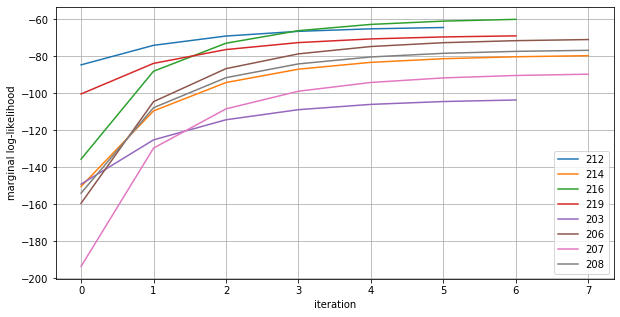

In [838]:
plt.figure(figsize=(10,5)); plt.grid()
plt.xlabel('iteration'); plt.ylabel('marginal log-likelihood')
for veh_id, marginal_ll_history in marginal_ll_history_all_veh.items():
    plt.plot(range(len(marginal_ll_history)), marginal_ll_history, label=veh_id)
for veh_id, marginal_ll_history in marginal_ll_history_all_veh_2.items():
    if veh_id != 204:
        plt.plot(range(len(marginal_ll_history)), marginal_ll_history, label=veh_id)
plt.legend(); 
plt.savefig('marginal_ll_per_iteration.pdf')



t 1150 idx 100
veh_xyi [1062.851 952.887] lane_curr_rxyi [1062.74854195  950.98953876] lane_new_rxyi [1062.88543117  955.18322431]
min_dist_curr 1.9002254614115521 min_dist_new 2.296482441394163
curr_d_pos -1.9002254614115521 offset 0.3954681862686258


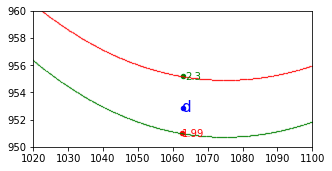

curr_lane d true_next_lane d lane_pred d

t 1151 idx 101
veh_xyi [1062.0610000000001 952.9780000000001] lane_curr_rxyi [1061.99689203  951.02294299] lane_new_rxyi [1062.13890318  955.21630725]
min_dist_curr 1.9561078033346966 min_dist_new 2.2396625283910208
curr_d_pos -1.9561078033346966 offset 0.283552612952213


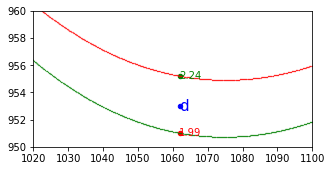

curr_lane d true_next_lane d lane_pred d

t 1152 idx 102
veh_xyi [1061.2730000000001 953.07] lane_curr_rxyi [1061.2453372  951.0584226] lane_new_rxyi [1061.39246669  955.251394  ]
min_dist_curr 2.0117675983172147 min_dist_new 2.184662920000619
curr_d_pos -2.0117675983172147 offset 0.1720167641906114


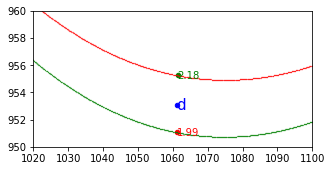

curr_lane d true_next_lane d lane_pred d

t 1153 idx 103
veh_xyi [1060.488 953.1619999999999] lane_curr_rxyi [1060.34360528  951.10374249] lane_new_rxyi [1060.49687151  955.29614838]
min_dist_curr 2.0633162214174434 min_dist_new 2.134166816298341
curr_d_pos -2.0633162214174434 offset 0.06857407125976511


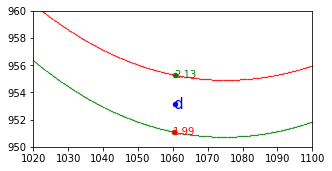

curr_lane d true_next_lane c lane_pred d

t 1154 idx 104
veh_xyi [1059.705 953.2539999999999] lane_curr_rxyi [1059.75065597  955.33565661] lane_new_rxyi [1059.59228055  951.14380006]
min_dist_curr 2.082157221481584 min_dist_new 2.113208330350059
curr_d_pos 2.082157221481584 offset -0.03053287874370003


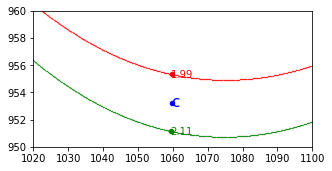

curr_lane c true_next_lane c lane_pred c

t 1155 idx 105
veh_xyi [1058.9260000000002 953.346] lane_curr_rxyi [1059.00454988  955.37718053] lane_new_rxyi [1058.69084206  951.1946235 ]
min_dist_curr 2.032698801734628 min_dist_new 2.16419040526452
curr_d_pos 2.032698801734628 offset -0.12890757148849818


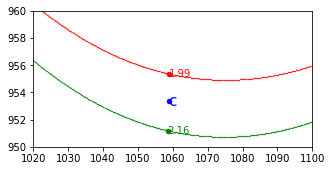

curr_lane c true_next_lane c lane_pred c

t 1156 idx 106
veh_xyi [1058.15 953.438] lane_curr_rxyi [1058.25855891  955.42072384] lane_new_rxyi [1057.93977638  951.23927566]
min_dist_curr 1.9856935438766918 min_dist_new 2.208751388239938
curr_d_pos 1.9856935438766918 offset -0.22219505164701192


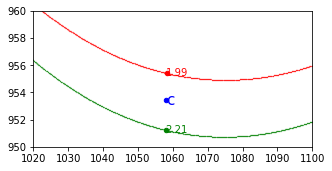

curr_lane c true_next_lane c lane_pred c

t 1157 idx 107
veh_xyi [1057.377 953.5310000000001] lane_curr_rxyi [1057.51268878  955.46629022] lane_new_rxyi [1057.18883812  951.28602173]
min_dist_curr 1.9400411577456835 min_dist_new 2.2528498210143035
curr_d_pos 1.9400411577456835 offset -0.31271196853465444


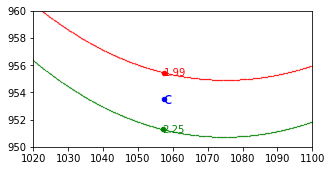

curr_lane c true_next_lane c lane_pred c


In [175]:
# # def hallucinate_a_step_change(track_i, lanes_rxy, z):
# #     print('hallucinate_a_step_change')

# t_range = np.arange(1150, 1158, 1)
# z = 1.0

# for t in t_range:
#     idx = np.where(actual_tracks_dict_all_with_headway[208][:,0] == t)[0][0]
#     print('\nt', t, 'idx', idx)
#     track_i = actual_tracks_dict_all_with_headway[208][idx,:]
#     track_i_next = actual_tracks_dict_all_with_headway[208][idx+1,:]

#     kp, kd = 0.02, 0


#     if track_i[10] == 'c': 
#         lane_curr_rxy = lanes_rxy['lane_c_rxy']; lane_new_rxy = lanes_rxy['lane_d_rxy']
#     elif track_i[10] == 'd': 
#         lane_curr_rxy = lanes_rxy['lane_d_rxy']; lane_new_rxy = lanes_rxy['lane_c_rxy']

#     veh_xyi = track_i[1:3]
    
#     distances_curr = cdist(np.array([veh_xyi]), lane_curr_rxy, 'euclidean')
#     min_dist_curr = np.min(distances_curr)
#     lane_curr_rxyi = lane_curr_rxy[np.argmin(distances_curr)]  #closest lane position

#     distances_bet_lanes = cdist(np.array([lane_curr_rxyi]), lane_new_rxy, 'euclidean')
#     min_dist_bet_lanes = np.min(distances_bet_lanes)
#     lane_new_rxyi = lane_new_rxy[np.argmin(distances_bet_lanes)]  #closest lane_new position
#     min_dist_new = cdist([veh_xyi], [lane_new_rxyi], 'euclidean')[0][0]
    
#     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)   
#     print('min_dist_curr', min_dist_curr, 'min_dist_new', min_dist_new)

#     if track_i[10] == 'c': 
#         offset = track_i[4] - min_dist_bet_lanes + track_i[4]
#     elif track_i[10] == 'd': 
#         offset = track_i[4] + min_dist_bet_lanes + track_i[4]
#     print('curr_d_pos', track_i[4], 'offset', offset)
        
#     if min_dist_curr > min_dist_new: 
#         if track_i[10] == 'c': 
#             lane_pred = 'd'
#         elif track_i[10] == 'd': 
#             lane_pred = 'c'
#     else:
#         lane_pred = track_i[10]  


# #     print('-----hallucinate_a_step_change----')
# #     print('veh_xyi', veh_xyi, 'lane_curr_rxyi', lane_curr_rxyi, 'lane_new_rxyi', lane_new_rxyi)
#     plt.figure(figsize=(5,2.5))
#     plt.plot(lanes_rxy['lane_c_rxy'][:,0], lanes_rxy['lane_c_rxy'][:,1], ".r", ms=0.5)
#     plt.scatter(lane_curr_rxyi[0], lane_curr_rxyi[1], s=20, c='r')
#     plt.text(lane_curr_rxyi[0]+3, lane_curr_rxyi[1], np.round(min_dist,2), fontsize=10, va="center", ha="center", color='r')
    
#     plt.plot(lanes_rxy['lane_d_rxy'][:,0], lanes_rxy['lane_d_rxy'][:,1], ".g", ms=0.5)
#     plt.scatter(lane_new_rxyi[0], lane_new_rxyi[1], s=20, c='g')
#     plt.text(lane_new_rxyi[0]+3, lane_new_rxyi[1], np.round(min_dist_new,2), fontsize=10, va="center", ha="center", color='g')

#     plt.scatter(veh_xyi[0], veh_xyi[1], s=20, c='b')
#     plt.text(veh_xyi[0]+1, veh_xyi[1], track_i[10][0], fontsize=15, va="center", ha="center", color='b')
#     plt.xlim(1020, 1100); plt.ylim(950, 960)
#     plt.show()
    
#     sd_next_pred, vsvd_next_pred, a_lon_pred = hallucinate_a_step_no_change(track_i, z)

#     a_lat_pred = - offset * kp - track_i[6] * kd
#     v_lat_pred = track_i[6] + a_lat_pred
#     v_lon_pred = vsvd_next_pred[0] #track_i[5]
#     s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred
#     s_lon_pred = sd_next_pred[0] #track_i[3] + track_i[5]

#     print('curr_lane', track_i[10], 'true_next_lane', track_i_next[10], 'lane_pred', lane_pred)
    
# #     if lane_pred = track_i_next[10]:
# #         print()
        
        
#     #     print('a_lat_pred', a_lat_pred, ', v_lat_pred', v_lat_pred, 's_lat_pred', s_lat_pred, 'lane_pred', lane_pred)

#     # return [s_lon_pred, s_lat_pred], [v_lon_pred, v_lat_pred], lane_pred




In [344]:
def get_xy_sd_cd(sd_next_pred, xy_prev, veh_lane, lanes_rxy):
    
    ## get xy coordinates
    if veh_lane == 'c':
        sp = sp_c
    elif veh_lane == 'd':
        sp = sp_d
        
    lane_xi, lane_yi = sp.calc_position(sd_next_pred[0])
    if lane_xi == None:
#         print('get_sd_cd, lane_xi==None')
        return xy_prev, sd_next_pred  ##고쳐야함
    
    else:
        yawi = sp.calc_yaw(sd_next_pred[0])
        xi_ret = lane_xi + sd_next_pred[1] * math.cos(yawi + math.pi / 2.0)
        yi_ret = lane_yi + sd_next_pred[1] * math.sin(yawi + math.pi / 2.0)
        veh_xyi = np.array([xi_ret, yi_ret])


        ## s-d coordinate about lane_cd_rxy
        lane_cd_rxy = lanes_rxy['lane_cd_rxy']    
#         print('lane_cd_rxy', lane_cd_rxy.shape, 'veh_xyi', veh_xyi.shape)
#         print('veh_xyi[:,None]', veh_xyi[None,:].shape)
        if veh_xyi.shape == (2,):
            distances_cd = cdist(veh_xyi[None,:], lane_cd_rxy, 'euclidean')
        if veh_xyi.shape == (2,1):
            distances_cd = cdist(veh_xyi.reshape((1,2)), lane_cd_rxy, 'euclidean')
        veh_s_cd = lane_cd_s[np.argmin(distances_cd)]

        if np.argmin(distances_cd) == 0:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd)+1, :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd), :]
        else:
            lane_xyi_cd = lane_cd_rxy[np.argmin(distances_cd), :]
            lane_xyi_prev_cd = lane_cd_rxy[np.argmin(distances_cd)-1, :]
        [lane_dxi_cd, lane_dyi_cd]  = np.subtract(lane_xyi_cd, lane_xyi_prev_cd)
        [veh_dxi_cd, veh_dyi_cd] = np.subtract(veh_xyi, lane_xyi_prev_cd)
        signi_cd = np.sign(lane_dxi_cd * veh_dyi_cd - lane_dyi_cd * veh_dxi_cd)
        veh_d_cd = np.min(distances_cd) * signi_cd

    return veh_xyi, [veh_s_cd, veh_d_cd]


In [345]:
# def simulate_pos_bunch_em(tracks_dict, mle_probs_final_all_veh, params_range, lanes_rxy, t_0, t_end):

#     v_des_all_veh, eps_all_veh, pol_all_veh, lam_all_veh = dict(), dict(), dict(), dict()
#     M = 1 #Monte Carlo simulation for each vehicle
    
#     for veh_id, mle_probs_final in mle_probs_final_all_veh.items():
        
#         v_des_all_veh[veh_id] = []
#         eps_all_veh[veh_id] = []
#         pol_all_veh[veh_id] = []
#         lam_all_veh[veh_id] = []
        
#         for m in range(M):
#             v_des_all_veh[veh_id].append(np.random.choice(params_range['z'], size=1, p=mle_probs_final[0])[0])
#             eps_all_veh[veh_id].append(np.random.choice(params_range['eps'], size=1, p=mle_probs_final[1])[0])
#             pol_all_veh[veh_id].append(np.random.choice(params_range['pol'], size=1, p=mle_probs_final[2])[0])
#             lam_all_veh[veh_id].append(np.random.choice(params_range['lam'], size=1, p=mle_probs_final[3])[0])  
#         print('veh_id', veh_id, 'v_des', v_des_all_veh[veh_id], 'eps', eps_all_veh[veh_id], 'pol', pol_all_veh[veh_id], 'lam', lam_all_veh[veh_id])
                
                
#     tracks_halluc_dict = dict()
# #     tracks_samples_dict = dict()
#     t_range = np.arange(t_0, t_end)
    
#     rmse_list = []
#     ll_list = []
    
    
#     for t in t_range:
#         print('\n\n t', t)
#         for veh_id, track in tracks_dict.items():
            
#             idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
#             if len(idx_t) == 1 and veh_id in mle_probs_final_all_veh.keys():
                
# #                 print('\n-----veh_id', veh_id, '-----')
                
#                 if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
#                     track_0 = tracks_dict[veh_id][idx_t[0], :21]
                    
#                     tracks_halluc_dict[veh_id] = track_0[None,:]
# #                     tracks_samples_dict[veh_id] = []
#                     rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], tracks_dict[veh_id][idx_t[0], 3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    
#                 else:   # if already exists in tracks_halluc_dict
#                     idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]
#                     veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0], 11]

#                     for m in range(M):
#                         v_des = v_des_all_veh[veh_id][m]
#                         eps = eps_all_veh[veh_id][m]
#                         pol = pol_all_veh[veh_id][m]
#                         lam = lam_all_veh[veh_id][m]
                            
#                         ### prob of changing lane
#                         prob_lane, _, veh_id_new = get_lane_change_prob_EM(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
#                                                                            tracks_dict, mle_probs_final_all_veh, params_range)
# #                         print('prob_lane', prob_lane)
                        
#                         ### samples for next 1-step
#                         if prob_lane >= 0.5:
                    
#                             print('\n-----veh_id', veh_id, '-----')
# #                             print('\nchange lane... prob_lane:', prob_lane)
                            
#                             idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
# #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])


#                             sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
# #                             print('sd_next_pred', sd_next_pred)
#                             xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)
                            
#                             if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]:  #if lane has changed
#                                 print(' Lane has changed to ', lane_pred)
#                                 idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
#                                 dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

#                                 track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
#                                                                     [idx_hw_new[0]],
#                                                                     [dist_headway_pred],
#                                                                     [lane_pred]))
#                                 change_lane_switch = 0
                                
#                             else:
#                                 dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
#                                 track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
#                                                                     [dist_headway_pred],
#                                                                     [tracks_dict[veh_id][idx_t[0], 20]]))

#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
#                                                          [lane_pred], #lane
#                                                          track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
#                                                          )) #s_cd, d_cd    
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
# #                             print(" ====> track_pred", track_pred, '\n')
                                             
                                
#                         elif prob_lane < 0.5:
# #                             print('\nnot change lane... prob_lane:', prob_lane)
#                             sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des)  #IDM
# #                             print('sd_next_pred', sd_next_pred)
#                             xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
#                                                                             tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
# #                             print('xy_next_pred', xy_next_pred.shape, xy_next_pred)
#                             if xy_next_pred.shape == (2,1): 
#                                 xy_next_pred = xy_next_pred.reshape((2,))
#                             dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                            
#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
#                                                          tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
#                                                          [dist_headway_pred], #dist_headway
#                                                          [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
#                                                          )) #s_cd, d_cd                            
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 

#                         else:
#                             print('Error... prob_lane', prob_lane)
                            
# #                         print('sd_next_pred', type(sd_next_pred), len(sd_next_pred), 'tracks_dict[veh_id][idx_t[0],3:5]', type(tracks_dict[veh_id][idx_t[0],3:5]), len(tracks_dict[veh_id][idx_t[0],3:5]))
# #                         ll_list.append(multi_normal(np.array(sd_next_pred), np.diag([eps]*2)).pdf(tracks_dict[veh_id][idx_t[0],3:5]))
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3:5], sd_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      
                        
#     rmse_list = np.array(rmse_list)
# #     ll_list = np.array(ll_list)

    
#     tracks_xy_halluc_dict = dict()
#     for veh_id, track_halluc in tracks_halluc_dict.items():
#         veh_s, veh_d = track_halluc[:,3], track_halluc[:,4]

#         veh_x_ret, veh_y_ret = [], []
#         for i in range(len(veh_s)):
                    
#             if track_halluc[i,10] == 'c': 
#                 sp = sp_c
#             elif track_halluc[i,10] == 'd': 
#                 sp = sp_d

#             lane_xi, lane_yi = sp.calc_position(veh_s[i])
#             if lane_xi == None:
#                 terminate_i = i
#                 break

#             yawi = sp.calc_yaw(veh_s[i])
#             xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
#             yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

#             veh_x_ret.append(xi_ret)
#             veh_y_ret.append(yi_ret)

#         track_xy_ret = np.column_stack((track_halluc[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_halluc[:len(veh_x_ret),3:]))
#         tracks_xy_halluc_dict[veh_id] = track_xy_ret
# #         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id])
        
#     return tracks_xy_halluc_dict, rmse_list, ll_list


In [378]:

def simulate_pos_bunch_em(tracks_dict, mle_probs_final_all_veh, params_range, lanes_rxy, t_0, t_end):

    v_des_all_veh, eps_all_veh, pol_all_veh, lam_all_veh = dict(), dict(), dict(), dict()
    M = 1 #Monte Carlo simulation for each vehicle
    
    for veh_id, mle_probs_final in mle_probs_final_all_veh.items():
        
        v_des_all_veh[veh_id] = []
        eps_all_veh[veh_id] = []
        pol_all_veh[veh_id] = []
        lam_all_veh[veh_id] = []
        
        for m in range(M):
            v_des_all_veh[veh_id].append(np.random.choice(params_range['z'], size=1, p=mle_probs_final[0])[0])
            eps_all_veh[veh_id].append(np.random.choice(params_range['eps'], size=1, p=mle_probs_final[1])[0])
            pol_all_veh[veh_id].append(np.random.choice(params_range['pol'], size=1, p=mle_probs_final[2])[0])
            lam_all_veh[veh_id].append(np.random.choice(params_range['lam'], size=1, p=mle_probs_final[3])[0])  
        print('veh_id', veh_id, 'v_des', v_des_all_veh[veh_id], 'eps', eps_all_veh[veh_id], 'pol', pol_all_veh[veh_id], 'lam', lam_all_veh[veh_id])
        
                
    tracks_halluc_dict = dict()
    change_lane_switch = dict()
#     tracks_samples_dict = dict()
    t_range = np.arange(t_0, t_end)
    
    rmse_list = []
    ll_list = []
    
    for t in t_range:
        print('\n\n t', t)
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
            if len(idx_t) == 1 and veh_id in mle_probs_final_all_veh.keys():
                
#                 print('\n-----veh_id', veh_id, '-----')
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = tracks_dict[veh_id][idx_t[0], :21]
                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    change_lane_switch[veh_id] = 0
#                     tracks_samples_dict[veh_id] = []
#                     rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], tracks_dict[veh_id][idx_t[0], 3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    rmse_list.append([tracks_dict[veh_id][idx_t[0], 1:3], tracks_dict[veh_id][idx_t[0], 1:3], veh_id, t])  #[s_true, s_pred, veh_id, t]      


                else:   # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0], 11]

                    for m in range(M):
                        v_des = v_des_all_veh[veh_id][m]
                        eps = eps_all_veh[veh_id][m]
                        pol = pol_all_veh[veh_id][m]
                        lam = lam_all_veh[veh_id][m]
                            
                        if change_lane_switch[veh_id] == 0:  ##if lane-change has not started
#                             print("\n...Lane-change switch is 0...")

                            ### prob of changing lane
                            prob_lane, _, veh_id_new = get_lane_change_prob_EM(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
                                                                               tracks_dict, mle_probs_final_all_veh, params_range)
#                             print('prob_lane', prob_lane)


                            ### samples for next 1-step
                            if prob_lane >= 0.5:
                                print('\n-----veh_id', veh_id, '-----')
                                print("...Lane-change switch was 0... => initiated lane-change, prob_lane", prob_lane)
                                change_lane_switch[veh_id] = 1

                                idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
    #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

                                sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
                                xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)
#                                 print('lane_pred', lane_pred)

                                if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]:  ##if lane has changed 
                                    print(' Lane has changed to ', lane_pred)
                                    idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
                                    dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

                                    track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
                                                                        [idx_hw_new[0]],
                                                                        [dist_headway_pred],
                                                                        [lane_pred]))
                        
                                    if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                        change_lane_switch[veh_id] = 0
                                    else:                               ##if lane has changed but haven't merged into new lane yet 
                                        change_lane_switch[veh_id] = 2
                                    
                            
                                else:  ##if lane has not changed yet (still in the process of lane-changing)
                                    dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                                    track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
                                                                        [dist_headway_pred],
                                                                        [tracks_dict[veh_id][idx_t[0], 20]]))
                                    change_lane_switch[veh_id] = 1

                                track_pred = np.concatenate(([t], # t
                                                             xy_next_pred, #x,y
                                                             sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                             tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
                                                             [lane_pred], #lane
                                                             track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
                                                             )) #s_cd, d_cd    
                                tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
#                                 print(" ====> track_pred", track_pred, '\n')


                            elif prob_lane < 0.52:
                                change_lane_switch[veh_id] = 0
                                
    #                             print('\nnot change lane... prob_lane:', prob_lane)
                                sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des)  #IDM
    #                             print('sd_next_pred', sd_next_pred)
                                xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
                                                                             tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
    #                             print('xy_next_pred', xy_next_pred.shape, xy_next_pred)
                                if xy_next_pred.shape == (2,1): 
                                    xy_next_pred = xy_next_pred.reshape((2,))
                                dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

                                track_pred = np.concatenate(([t], # t
                                                             xy_next_pred, #x,y
                                                             sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                             tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
                                                             tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
                                                             [dist_headway_pred], #dist_headway
                                                             [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
                                                             )) #s_cd, d_cd                            
                                tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 

                            else:
                                print('Error... prob_lane', prob_lane)

                                
                        elif change_lane_switch[veh_id] == 1:  ##if lane-change has started and not finished
                            print('\n-----veh_id', veh_id, '-----')
                            print("...Lane-change switch is 1...")
                            
                            idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
#                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

                            sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
                            xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)

                            if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]: ##if lane has changed 
                                print(' Lane has changed to ', lane_pred)
                                idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
                                dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

                                track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
                                                                    [idx_hw_new[0]],
                                                                    [dist_headway_pred],
                                                                    [lane_pred]))
                                
                                if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                    change_lane_switch[veh_id] = 0
                                else:                               ##if lane has changed but haven't merged into new lane yet 
                                    change_lane_switch[veh_id] = 2

                            else:  ##if lane has not changed yet (still in the process of lane-changing)
                                dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
                                track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
                                                                    [dist_headway_pred],
                                                                    [tracks_dict[veh_id][idx_t[0], 20]]))
                                change_lane_switch[veh_id] = 1

                            track_pred = np.concatenate(([t], # t
                                                         xy_next_pred, #x,y
                                                         sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                         tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
                                                         [lane_pred], #lane
                                                         track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
                                                         )) #s_cd, d_cd    
                            tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
#                             print(" ====> track_pred", track_pred, '\n')
                               

                        elif change_lane_switch[veh_id] == 2:  ##if lane-change has changed but haven't merged into new lane yet 
                            print('\n-----veh_id', veh_id, '-----')
                            print("...Lane-change switch was 2...")
                    
                            track_i = tracks_halluc_dict[veh_id][idx_own_0[0],:]

                            if track_i[10] == 'c': 
                                offset = track_i[4] # - min_dist_bet_lanes 
                            elif track_i[10] == 'd': 
                                offset = track_i[4] #+ min_dist_bet_lanes 
                            print('track_i[4]', track_i[4], 'track_i[6]', track_i[6], 'track_i[10]', track_i[10], 'offset', offset)
                            
                            a_lat_pred = - offset * 0.02 
                            v_lat_pred = track_i[6] + a_lat_pred
                            s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred
                            print('s_lat_pred', s_lat_pred)
                              
                            sd_next_pred_idm, vsvd_next_pred_idm, _ = hallucinate_a_step_no_change(track_i, v_des)   
                            sd_next_pred = [sd_next_pred_idm[0], s_lat_pred]
                            vsvd_next_pred = [vsvd_next_pred_idm[0], v_lat_pred]
                            
                            xy_next_pred, _ = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
                                                                         tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
                            if xy_next_pred.shape == (2,1): 
                                xy_next_pred = xy_next_pred.reshape((2,))
                            dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

                            track_pred = np.concatenate(([t], # t
                                                         xy_next_pred, #x,y
                                                         sd_next_pred, vsvd_next_pred, #s,d,vs,vd
                                                         tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
                                                         tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
                                                         [dist_headway_pred], #dist_headway
                                                         [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
                                                         )) #s_cd, d_cd                            
                            tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
                            
                            if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
                                change_lane_switch[veh_id] = 0
                            else:                               ##if lane has changed but haven't merged into new lane yet 
                                change_lane_switch[veh_id] = 2
                            
#                         print('sd_next_pred', type(sd_next_pred), len(sd_next_pred), 'tracks_dict[veh_id][idx_t[0],3:5]', type(tracks_dict[veh_id][idx_t[0],3:5]), len(tracks_dict[veh_id][idx_t[0],3:5]))
#                         ll_list.append(multi_normal(np.array(sd_next_pred), np.diag([eps]*2)).pdf(tracks_dict[veh_id][idx_t[0],3:5]))
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3:5], sd_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 1:3], xy_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      

        
    rmse_list = np.array(rmse_list)
#     ll_list = np.array(ll_list)

    
    tracks_xy_halluc_dict = dict()
    for veh_id, track_halluc in tracks_halluc_dict.items():
        veh_s, veh_d = track_halluc[:,3], track_halluc[:,4]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
                    
            if track_halluc[i,10] == 'c': 
                sp = sp_c
            elif track_halluc[i,10] == 'd': 
                sp = sp_d

            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_halluc[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_halluc[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id])
        
    return tracks_xy_halluc_dict, rmse_list, ll_list


In [340]:
t_0, t_end = 1000, 1450 #2950, 3150
tracks_xy_halluc_dict_em, rmse_list_em, _ = simulate_pos_bunch_em(actual_tracks_dict_all_with_headway, \
                                                                  mle_probs_final_all_veh, params_range, lanes_rxy, t_0, t_end)


veh_id 203 v_des [1.4000000000000001] eps [0.1] pol [0.1] lam [0.7]
veh_id 204 v_des [0.5] eps [0.1] pol [0.8499999999999999] lam [1.2999999999999998]
veh_id 206 v_des [1.1] eps [0.30000000000000004] pol [0.6] lam [0.7]
veh_id 207 v_des [1.1] eps [0.30000000000000004] pol [0.6] lam [0.7]
veh_id 208 v_des [1.1] eps [0.1] pol [0.6] lam [0.7]
veh_id 212 v_des [0.5] eps [0.30000000000000004] pol [0.1] lam [0.4]
veh_id 214 v_des [0.5] eps [0.5000000000000001] pol [0.35] lam [0.4]
veh_id 216 v_des [1.7000000000000002] eps [0.1] pol [0.6] lam [1.2999999999999998]
veh_id 219 v_des [0.8] eps [0.5000000000000001] pol [0.35] lam [0.9999999999999999]


 t 1000


 t 1001


 t 1002


 t 1003


 t 1004


 t 1005


 t 1006


 t 1007


 t 1008


 t 1009


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 

In [347]:
t_0, t_end = 1000, 1450
animate_in_xy_simulate(tracks_xy_halluc_dict_em, actual_tracks_dict_all_with_headway, t_0, t_end)


interactive(children=(IntSlider(value=1225, description='t', max=1450, min=1000), Output(layout=Layout(height=…

In [166]:
t_0, t_end = 1000, 1500
animate_in_xy(actual_tracks_dict_all_with_headway, t_0, t_end)

interactive(children=(IntSlider(value=1250, description='t', max=1500, min=1000, step=10), Output(layout=Layou…

In [231]:
def animate_in_xy_simulate(tracks_xy_dict, actual_tracks_dict_all_with_headway, t_0, t_end):
    scene = 'DR_CHN_Merging_ZS'
    map_file = 'maps/' + scene + '.osm'
    min_t, max_t = t_0, t_end # track[0,0], track[-1,0]
    
    def f(t):        
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_c_rx[0]+10, lane_c_ry[0]+2, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
        plt.arrow(lane_d_rx[0]+10, lane_d_ry[0]+1, -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_c_rx, lane_c_ry, "--r")
#         plt.plot(lane_d_rx, lane_d_ry, "--r")
        plt.grid()

        for veh_id, track in tracks_xy_dict.items():

            idx = np.where(track[:,0]==t)[0]
            
            if len(idx) != 0:
                idx_true = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0]==t)[0]

                if len(idx_true) == 1: # and veh_id != 120:
                    plt.scatter(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1], 
                                actual_tracks_dict_all_with_headway[veh_id][idx_true, 2], s=100, c='y')
                    plt.text(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1],
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='y')
                    plt.text(actual_tracks_dict_all_with_headway[veh_id][idx_true, 1],
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 2]+5.5, 
                             actual_tracks_dict_all_with_headway[veh_id][idx_true, 10][0], fontsize=15, va="center", ha="center", color='y')

                if len(idx) == 1: # and veh_id != 120:
                    plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
    #                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
                    plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')
                    plt.text(track[idx, 1], track[idx, 2]+5.5, track[idx, 10][0], fontsize=15, va="center", ha="center", color='b')


#                 if veh_id in samples_xy_dict.keys():
#                     sd_samples = samples_xy_dict[veh_id]
                    
#                     for j in range(0, 10): 
#                         sample_j = sd_samples[j::10, :]
#                         idx_j = int(np.where(sample_j[:,0]==t)[0])
#                         idx_j_end = min(idx_j+10, len(sample_j))

#                         plt.plot(sample_j[idx_j:idx_j_end:2,1], sample_j[idx_j:idx_j_end:2,2],'-r', lw=0.5) 

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 1))
    output = widget.children[-1]
    output.layout.height = '350px'
    display(widget)
    

1006 1500
veh_id 203 v_des [1.85] eps [0.61] pol [0.1] lam [1.1]
veh_id 204 v_des [0.65] eps [0.49] pol [0.30000000000000004] lam [1.6]
veh_id 206 v_des [1.25] eps [0.6699999999999999] pol [0.1] lam [0.7000000000000001]
veh_id 207 v_des [0.5] eps [0.25] pol [0.30000000000000004] lam [0.5]
veh_id 208 v_des [0.65] eps [0.13] pol [0.1] lam [1.3000000000000003]


 t 1006


 t 1007


 t 1008


 t 1009


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043

-----veh_id 203 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane [0.53745218]


 t 1044

-----veh_id 203 -----
...Lane-change switch is 1...


 t 1045

-----veh_id 203 -----
...Lane-change switch is 1...


 t 1046

-----veh_id 203 ----

RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (26, 4)
veh_id 207 rmse_track (16, 4)
veh_id 208 rmse_track (9, 4)
veh_id 203 v_des [1.4000000000000001] eps [0.16] pol [0.1] lam [1.5000000000000002]
veh_id 204 v_des [1.7000000000000002] eps [0.61] pol [0.7000000000000001] lam [1.2000000000000002]
veh_id 206 v_des [1.85] eps [0.19] pol [0.5000000000000001] lam [1.0]
veh_id 207 v_des [1.1] eps [0.49] pol [0.5000000000000001] lam [1.4000000000000001]
veh_id 208 v_des [0.9500000000000001] eps [0.22] pol [0.7000000000000001] lam [0.5]


 t 1010


 t 1011


 t 1012


 t 1013


 t 1014


 t 1015


 t 1016


 t 1017


 t 1018


 t 1019


 t 1020


 t 1021


 t 1022


 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044

-----veh_id 203 -----
...Lane-change switch was 0... => initiated lane

-----veh_id 203 -----
...Lane-change switch is 1...


 t 1051

-----veh_id 203 -----
...Lane-change switch is 1...


 t 1052

-----veh_id 203 -----
...Lane-change switch is 1...


 t 1053

-----veh_id 203 -----
...Lane-change switch is 1...
 Lane has changed to  d


 t 1054

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -1.3968292694279454 track_i[6] 0.42995835157691753 track_i[10] d offset -1.3968292694279454
s_lat_pred -0.9529026251567484


 t 1055

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -0.9529026251567484 track_i[6] 0.45789493696547645 track_i[10] d offset -0.9529026251567484
s_lat_pred -0.48547866193970446


 t 1056

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -0.48547866193970446 track_i[6] 0.4769529894686114 track_i[10] d offset -0.48547866193970446
s_lat_pred -0.003670885851695993


 t 1057

-----veh_id 203 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane [0.54278394]


 t 1058

-----veh_id 2



 t 1023


 t 1024


 t 1025


 t 1026


 t 1027


 t 1028


 t 1029


 t 1030


 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (35, 4)
veh_id 207 rmse_track (25, 4)
veh_id 208 rmse_track (18, 4)
veh_id 203 v_des [1.85] eps [0.31] pol [0.1] lam [1.6]
veh_id 204 v_des [0.65] eps [0.13] pol [0.7000000000000001] lam [0.2]
veh_id 206 v_des [1.1] eps [0.16] pol [0.7000000000000001] lam [0.9]
veh_id 207 v_des [0.9500000000000001] eps [0.22] pol [0.5000000000000001] lam [0.4]
veh_id 208 v_des [1.4000000000000001] eps [0.4] pol [0.5000000000000001] lam [0.30000000000000004]


 t 1019




 t 1031


 t 1032


 t 1033


 t 1034


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (43, 4)
veh_id 207 rmse_track (33, 4)
veh_id 208 rmse_track (26, 4)
veh_id 203 v_des [1.7000000000000002] eps [0.1] pol [0.5000000000000001] lam [1.5000000000000002]
veh_id 204 v_des [1.1] eps [0.4] pol [0.1] lam [1.6]
veh_id 206 v_des [1.7000000000000002] eps [0.13] pol [0.9000000000000001] lam [1.1]
veh_id 207 v_des [1.4000000000000001] eps [0.22] pol [0.30000000000000004] lam [0.8]
veh_id 208 v_des [0.9500000000000001] eps [0.31] pol [0.900000000000000

 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (41, 4)
veh_id 208 rmse_track (34, 4)
veh_id 203 v_des [0.65] eps [0.49] pol [0.9000000000000001] lam [0.7000000000000001]
veh_id 204 v_des [1.4000000000000001] eps [0.49] pol [0.1] lam [1.1]
veh_id 206 v_des [0.8] eps [0.25] pol [0.9000000000000001] lam [1.2000000000000002]
veh_id 207 v_des [0.8] eps [0.42999999999999994] pol [0.7000000000000001] lam [0.6]
veh_id 208 v_des [1.5500000000000003] eps [0.5499999999999999] pol [0.1] lam [1.6]


 t 1035


 t 1036


 t 1037


 t 1038


 t 1039


 t 1040


 t 1041


 t 1042


 t 1043


 t 1044


 t 1045


 t 1046


 t 1047


 t 1048


 t 1

 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane [0.51151591]


 t 1076

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1077

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1078

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1079

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1080

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1081

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1082

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1083

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1084

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.2396289956045274 track_i[6] -0.6823685987602536 track_i[10] c offset 1.2396289956045274
s_lat_pred 0.5448641068882286


 t 1085

-----veh_id 208 -----
...

 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (48, 4)
veh_id 203 v_des [1.4000000000000001] eps [0.45999999999999996] pol [0.30000000000000004] lam [0.5]
veh_id 204 v_des [1.4000000000000001] eps [0.49] pol [0.5000000000000001] lam [0.9]
veh_id 206 v_des [1.5500000000000003] eps [0.49] pol [0.5000000000000001] lam [0.1]
veh_id 207 v_des [1.25] eps [0.52] pol [0.30000000000000004] lam [0.8]
veh_id 208 v_des [1.5500000000000003] eps [0.4] pol [0.7000000000000001] lam [1.0]


 t 1049


 t 1050


 t 1051


 t 1052


 t 1053


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082

 t 1068


 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.1] eps [0.58] pol [0.30000000000000004] lam [0.1]
veh_id 204 v_des [1.7000000000000002] eps [0.52] pol [0.9000000000000001] lam [1.1]
veh_id 206 v_des [0.65] eps [0.22] pol [0.9000000000000001] lam [1.7000000000000002]
veh_id 207 v_des [1.7000000000000002] eps [0.61] pol [0.7000000000000001] lam [1.2000000000000002]
veh_id 208 v_des [1.7000000000000002] eps [0.22] pol [0.7000000000000001] lam [0.4]


 t 1054


 t 1055


 t 1056


 t 1057


 t 1058


 t 1059


 t 1060



 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [0.65] eps [0.33999999999999997] pol [0.9000000000000001] lam [0.1]
veh_id 204 v_des [0.9500000000000001] eps [0.6699999999999999] pol [0.5000000000000001] lam [0.5]
veh_id 206 v_des [1.25] eps [0.33999999999999997] pol [0.5000000000000001] lam [1.3000000000000003]
veh_id 207 v_des [1.1] eps [0.6699999999999999] pol [0.7000000000000001] lam [1.2000000000000002]
veh_id 208 v_des [0.8] eps [0.37] pol [0.7000000000000001] lam [1.2000000000000002]


 t 1061


 t 1062


 t 1063


 t 1064


 t 1065


 t 1066


 t 1067


 t 1068


 t

 t 1069


 t 1070


 t 1071


 t 1072


 t 1073


 t 1074


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 1091


 t 1092


 t 1093


 t 1094


 t 1095


 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [0.9500000000000001] eps [0.52] pol [0.7000000000000001] lam [1.4000000000000001]
veh_id 204 v_des [0.5] eps [0.37] pol [0.9000000000000001] lam [0.8]
veh_id 206 v_des [1.5500000000000003] eps [0.25] pol [0.5000000000000001] lam [0.9]
veh_id 207 v_des [1.5500000000000003] eps [0.64] pol [0.30000000000000004] lam [1.1]
veh_id 208 v_des [1.5500

 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [0.5] eps [0.19] pol [0.30000000000000004] lam [0.5]
veh_id 204 v_des [0.8] eps [0.1] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 206 v_des [1.4000000000000001] eps [0.19] pol [0.7000000000000001] lam [1.7000000000000002]
veh_id 207 v_des [1.5500000000000003] eps [0.28] pol [0.1] lam [0.1]
veh_id 208 v_des [0.9500000000000001] eps [0.1] pol [0.1] lam [1.2000000000000002]


 t 1075


 t 1076


 t 1077


 t 1078


 t 1079


 t 1080


 t 1081


 t 1082


 t 1083


 t 1084


 t 1085


 t 1086


 t 1087


 t 1088


 t 1089


 t 1090


 t 10

 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128

-----veh_id 207 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5036871603551478


 t 1129

-----veh_id 207 -----
...Lane-change switch is 1...


 t 1130

-----veh_id 207 -----
...Lane-change switch is 1...


 t 1131

-----veh_id 207 -----
...Lane-change switch is 1...


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.1] eps [0.49] pol [0.1] lam [1.7000000000000002]
veh_id 204 v_des [1.7000000000000002] eps [0.49] pol [0.9000000000000001] lam [0.5]
veh_id 206 v_des [1.4000000000000001] eps [0.52] pol [0.5000000000000001] lam [0.1]
veh_id 207 v_des [0.65] eps [0.49] pol [0.7000000000000001] lam [1.7000000000000002]
v



 t 1096


 t 1097


 t 1098


 t 1099


 t 1100


 t 1101


 t 1102


 t 1103


 t 1104


 t 1105


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.25] eps [0.37] pol [0.5000000000000001] lam [0.1]
veh_id 204 v_des [0.65] eps [0.16] pol [0.30000000000000004] lam [0.1]
veh_id 206 v_des [0.9500000000000001] eps [0.13] pol [0.30000000000000004] lam [1.3000000000000003]
veh_id 207 v_des [1.5500000000000003] eps [0.16] pol [0.7000000000000001] lam [1.7000000000000002]
veh_id 208 v_des [1.85] eps [0.61] pol [0.5000000000000001] lam [0.1]

 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.4000000000000001] eps [0.13] pol [0.9000000000000001] lam [0.6]
veh_id 204 v_des [1.1] eps [0.42999999999999994] pol [0.30000000000000004] lam [0.30000000000000004]
veh_id 206 v_des [0.5] eps [0.31] pol [0.7000000000000001] lam [0.7000000000000001]
veh_id 207 v_des [1.4000000000000001] eps [0.4] pol [0.30000000000000004] lam [0.8]
veh_id 208 v_des [1.4000000000000001] eps [0.33999999999999997] pol [0.1] lam [0.9]


 t 1098


 t

 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.7000000000000002] eps [0.64] pol [0.5000000000000001] lam [0.9]
veh_id 204 v_des [0.8] eps [0.1] pol [0.30000000000000004] lam [0.4]
veh_id 206 v_des [1.25] eps [0.37] pol [0.5000000000000001] lam [0.30000000000000004]
veh_id 207 v_des [0.8] eps [0.45999999999999996] pol [0.1] lam [1.0]
veh_id 208 v_des [0.9500000000000001] eps [0.31] pol [0.9000000000000001] lam [1.6]


 t 1106


 t 1107


 t 1108


 t 1109


 t 1110


 t 1111


 t 1112


 t 1113


 t 1114


 t 1115


 t 1116


 t 1117


 t 1118



 t 1116


 t 1117


 t 1118


 t 1119


 t 1120


 t 1121


 t 1122


 t 1123


 t 1124


 t 1125


 t 1126


 t 1127


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.4000000000000001] eps [0.16] pol [0.5000000000000001] lam [1.4000000000000001]
veh_id 204 v_des [0.8] eps [0.1] pol [0.9000000000000001] lam [0.9]
veh_id 206 v_des [0.8] eps [0.19] pol [0.30000000000000004] lam [1.1]
veh_id 207 v_des [0.5] eps [0.33999999999999997] pol [0.30000000000000004] lam [0.9]
veh_id 208 v_des [0.9500000000000001] eps [0.4]



 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (50, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.5500000000000003] eps [0.22] pol [0.5000000000000001] lam [0.6]
veh_id 204 v_des [1.4000000000000001] eps [0.61] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 206 v_des [1.4000000000000001] eps [0.28] pol [0.7000000000000001] lam [1.5000000000000002]
veh_id 207 v_des [1.1] eps [0.64] pol [0.1] lam [0.4]
veh_id 208 v_des [0.9500000000000001] eps [0.1] pol [0.7000000000000001] lam [0.30000000000000004]


 t 1118


 t


-----veh_id 208 -----
...Lane-change switch is 1...


 t 1155

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1156

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1157

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1158

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1159

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1160

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.354375311553003 track_i[6] -0.5720581124543461 track_i[10] c offset 1.354375311553003
s_lat_pred 0.7687734459831269


 t 1161

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 0.7687734459831269 track_i[6] -0.5991456186854062 track_i[10] c offset 0.7687734459831269
s_lat_pred 0.1619400928378895


 t 1162

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5597136492671929


 t 1163

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1164

-----veh_id 208 -----
...La



 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (48, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [0.5] eps [0.64] pol [0.7000000000000001] lam [0.2]
veh_id 204 v_des [1.7000000000000002] eps [0.22] pol [0.1] lam [0.1]
veh_id 206 v_des [0.5] eps [0.22] pol [0.1] lam [1.4000000000000001]
veh_id 207 v_des [0.5] eps [0.33999999999999997] pol [0.30000000000000004] lam [0.4]
veh_id 208 v_des [1.4000000000000001] eps [0.1] pol [0.30000000000000004] lam [0.6]


 t 1128


 t 1129


 t 1130


 t 1131


 t 1132


 t 1133


 t 1134


 t 1135


 t 1136


 t 1137


 t 1138


 t 1139


 t 1140


 t 1141


 t 1142


 t 1143


 t 1144


 t 1145


 t 1146


 t 1147


 t 1148


 t 1149


 t 1150


 

 t 1172

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1173

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1174

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1175

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1176

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1177

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1178

-----veh_id 203 -----
...Lane-change switch is 1...
 Lane has changed to  d

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1179

-----veh_id 203 -----
...Lane-change switch was 2...
track_i[4] -1.413000882957351 track_i[6] 0.44878266386489957 track_i[10] d offset -1.413000882957351
s

 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5


 t 1182

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1183

-----veh_id 203 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5399148845555657

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1184

-----veh_id 203 -----
...Lane-change switch is 1...

-----veh_id 208 -----
...Lane-change switch is 1...


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (40, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.1] eps [0.28] pol [0.7000000000000001] lam [1.1]
veh_id 204 v_des 



 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t 1154


 t 1155


 t 1156


 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5


 t 1167

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1168

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1169

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1170

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1171

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1172

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.5564682998603905 track_i[6] -0.38113258112130566 track_i[10] c offset 1.5564682998603905
s_lat_pred 1.159771035740481


 t 1173

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.159771035740481 track_i[6] -0.4122619471185135 track_i[10] c offset 1.159771035740481
s_lat_pre

 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5


 t 1167

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1168

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1169

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1170

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1171

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.7227635356414943 track_i[6] -0.3122928173830493 track_i[10] c offset 1.7227635356414943
s_lat_pred 1.3932430829020301


 t 1172

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.3932430829020301 track_i[6] -0.3467480880958792 track_i[10] c offset 1.3932430829020301
s_lat_pred 1.0325625639771305


 t 1173

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.0325625639771305 track_i[6] -0.3746129497539198 track_i[10] c off

 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (29, 4)
veh_id 206 rmse_track (50, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [0.8] eps [0.49] pol [0.30000000000000004] lam [1.0]
veh_id 204 v_des [1.4000000000000001] eps [0.64] pol [0.9000000000000001] lam [1.1]
veh_id 206 v_des [1.25] eps [0.22] pol [0.7000000000000001] lam [0.8]
veh_id 207 v_des [1.5500000000000003] eps [0.31] pol [0.1] lam [0.1]
veh_id 208 v_des [0.8] eps [0.45999999999999996] pol [0.5000000000000001] lam [0.8]


 t 1147


 t 1148


 t 1149


 t 1150


 t 1151


 t 1152


 t 1153


 t



 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5179922280289649


 t 1180

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1181

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1182

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.8247873428832373 track_i[6] -0.1822523478343771 track_i[10] c offset 1.8247873428832373
s_lat_pred 1.6242871216200279


 t 1183

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.6242871216200279 track_i[6] -0.21874809469204184 track_i[10] c offset 1.6242871216200279
s_lat_pred 1.3892961557117856


 t 1184

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.3892961557117856 track_i[6] -0.2512338371244424 track_i[10] c offset 1.3892961557117856
s_lat_pred 1.1241693570302251


 t 1185

-----veh_id 208 -----
..

 t 1157


 t 1158


 t 1159


 t 1160


 t 1161


 t 1162


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1188


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5


 t 1198

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  d


 t 1199

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] -0.26159434296142603 track_i[6] 0.9496495113066559 track_i[10] d offset -0.26159434296142603
s_lat_pred 0.6906711117748441


 t 1200

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 0.6906711117748441 track_i[6] 0.9548813981658844 track_i[10] d offset 0.6906711117748441
s_lat_pred 1.63864579882298


 t 1201

-----veh_i

 t 1192


 t 1193


 t 1194

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane 0.5299640517645717


 t 1195

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1196

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1197

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1198

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1199

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1200

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1201

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1202

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1203

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1204

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1205

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1206

-----veh_id 208 -----
...Lane-change switch is 1...
 Lane has changed to  c


 t 1207

-----veh_id 208 -----
...Lane-change switch was 2...
track_i[4] 1.162216



 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (13, 4)
veh_id 206 rmse_track (34, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.25] eps [0.64] pol [0.9000000000000001] lam [0.6]
veh_id 204 v_des [1.5500000000000003] eps [0.1] pol [0.1] lam [1.7000000000000002]
veh_id 206 v_des [0.8] eps [0.33999999999999997] pol [0.1] lam [1.1]
veh_id 207 v_des [1.25] eps [0.22] pol [0.30000000000000004] lam [1.4000000000000001]
veh_id 208 v_des [0.8] eps [0.64] pol [0.9000000000000001] lam [1.2000000000000002]


 t 1163


 t 1164


 t 1165


 t 1166


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172

-----veh_id 208 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane [0.52481974]


 t 1173

-----veh_id 2

 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (9, 4)
veh_id 206 rmse_track (30, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (50, 4)
veh_id 203 v_des [1.5500000000000003] eps [0.37] pol [0.7000000000000001] lam [0.5]
veh_id 204 v_des [1.5500000000000003] eps [0.33999999999999997] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 206 v_des [1.1] eps [0.5499999999999999] pol [0.1] lam [0.7000000000000001]
veh_id 207 v_des [1.85] eps [0.33999999999999997] pol [0.1] lam [0.6]
veh_id 208 v_des [1.4000000000000001] eps [0.37] pol [0.30000000000000004] lam [0.5]


 t 1167


 t 1168


 t 1169


 t 1170


 t 1171


 t 1172


 t 1173


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1



 t 1218

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1219

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1220

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1221

-----veh_id 208 -----
...Lane-change switch is 1...


 t 1222


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 204 rmse_track (2, 4)
veh_id 206 rmse_track (23, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (49, 4)
veh_id 203 v_des [0.65] eps [0.25] pol [0.9000000000000001] lam [0.4]
veh_id 204 v_des [0.5] eps [0.58] pol [0.9000000000000001] lam [0.30000000000000004]
veh_id 206 v_des [0.9500000000000001] eps [0.42999999999999994] pol [0.7000000000000001] lam [1.3000000000000003]
veh_id 207 v_des [1.5500000000000003] eps [0.16] pol [0.5000000000000001] lam [0.9]
veh_id 208 v_des [0.65] eps [0.16] pol [0.9000000000000001] lam [1.7000000000000002]


 t 1174


 t 1175


 t 1176


 t 1177


 t 1178


 t 1179


 t 1180


 t 1181


 t 1182


 t 1183


 t 1184


 t 1185


 t 1186


 t 1187


 t 1189


 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 206 rmse_track (15, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (41, 4)
veh_id 203 v_des [1.4000000000000001] eps [0.31] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 204 v_des [0.8] eps [0.22] pol [0.9000000000000001] lam [0.7000000000000001]
veh_id 206 v_des [1.4000000000000001] eps [0.28] pol [0.30000000000000004] lam [1.2000000000000002]
veh_id 207 v_des [0.65] eps [0.19] pol [0.5000000000000001] lam [0.2]
veh_id 208 v_des [1.25] eps [0.64] pol [0.5000000000000001] lam [1.3000000000000003]


 t 1182


 

 t 1190


 t 1191


 t 1192


 t 1193


 t 1194


 t 1195


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


RMSE....
veh_id 203 rmse_track (50, 4)
veh_id 206 rmse_track (7, 4)
veh_id 207 rmse_track (50, 4)
veh_id 208 rmse_track (33, 4)
veh_id 203 v_des [0.9500000000000001] eps [0.22] pol [0.7000000000000001] lam [1.3000000000000003]
veh_id 204 v_des [0.65] eps [0.1] pol [0.9000000000000001] lam [1.5000000000000002]
veh_id 206 v_des [1.7000000000000002] eps [0.28] pol [0.1] lam [1.3000000000000003]
veh_id 207 v_des [1.5500000000000003] eps [0.19] pol [0.30000000000000004] lam [0.2]
veh_id 208 v_des [1.1] eps [0.

 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


RMSE....
veh_id 203 rmse_track (49, 4)
veh_id 206 rmse_track (1, 4)
veh_id 207 rmse_track (49, 4)
veh_id 208 rmse_track (27, 4)
veh_id 203 v_des [1.85] eps [0.37] pol [0.7000000000000001] lam [0.5]
veh_id 204 v_des [1.25] eps [0.1] pol [0.30000000000000004] lam [0.5]
veh_id 206 v_des [0.5] eps [0.16] pol [0.5000000000000001] lam [1.3000000000000003]
veh_id 207 v_des [0.8] eps [0.6699999999999999] pol [0.9000000000000001] lam [0.8]
veh_id 208 v_des [0.5] eps [0.4] pol [0.30000000000000004] lam [1.5000000000000002]


 t 1196


 t 1197


 t 1198


 t 1199


 t 1200


 t 1201

-----veh_id 207 -----
...Lane-change switch was 0... => initiated lane-change, prob_lane [0.52561132]


 t 1202

-----veh_id 207 -----
...Lane-change switch is 1...


 t 1203

-----veh_id 207 -----
...Lane-change switch is 1...




veh_id 206 v_des [1.1] eps [0.19] pol [0.30000000000000004] lam [0.30000000000000004]
veh_id 207 v_des [0.8] eps [0.4] pol [0.5000000000000001] lam [1.6]
veh_id 208 v_des [1.85] eps [0.28] pol [0.30000000000000004] lam [1.5000000000000002]


 t 1199


 t 1200


 t 1201


 t 1202


 t 1203


 t 1204


 t 1205


 t 1206


 t 1207


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


RMSE....
veh_id 203 rmse_track (45, 4)
veh_id 207 rmse_track (45, 4)
veh_id 208 rmse_track (23, 4)
veh_id 203 v_des [0.9500000000000001] eps [0.1] pol [0.1] lam [1.4000000000000001]
veh_id 204 v_des [0.9500000000000001] eps [0.1] pol [0.9000000000000001] lam

 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


RMSE....
veh_id 203 rmse_track (37, 4)
veh_id 207 rmse_track (37, 4)
veh_id 208 rmse_track (15, 4)
veh_id 203 v_des [1.1] eps [0.13] pol [0.1] lam [0.1]
veh_id 204 v_des [1.7000000000000002] eps [0.31] pol [0.1] lam [1.6]
veh_id 206 v_des [1.7000000000000002] eps [0.31] pol [0.7000000000000001] lam [1.4000000000000001]
veh_id 207 v_des [0.9500000000000001] eps [0.25] pol [0.5000000000000001] lam [0.2]
veh_id 208 v_des [1.25] eps [0.16] pol [0.30000000000000004] lam [1.7000000000000002]


 t 1208


 t 1209


 t 1210


 t 1211


 t 1212


 t 1213


 t 1214


 t 1215


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228



 t 1220


 t 1221


 t 1222


 t 1223


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


RMSE....
veh_id 203 rmse_track (29, 4)
veh_id 207 rmse_track (29, 4)
veh_id 208 rmse_track (7, 4)
veh_id 203 v_des [0.9500000000000001] eps [0.4] pol [0.1] lam [1.4000000000000001]
veh_id 204 v_des [0.9500000000000001] eps [0.16] pol [0.7000000000000001] lam [0.5]
veh_id 206 v_des [1.25] eps [0.19] pol [0.1] lam [1.2000000000000002]
veh_id 207 v_des [1.7000000000000002] eps [0.64] pol [0.1] lam [1.1]
veh_id 208 v_des [1.25] eps [0.49] pol [0.5000000000000001] lam [1.4000000000000001]


 t 1216


 t 1217


 t 1218


 t 1219


 t 1220


 t 1221

 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


RMSE....
veh_id 203 rmse_track (21, 4)
veh_id 207 rmse_track (21, 4)
veh_id 203 v_des [0.8] eps [0.64] pol [0.5000000000000001] lam [0.1]
veh_id 204 v_des [1.7000000000000002] eps [0.13] pol [0.30000000000000004] lam [1.6]
veh_id 206 v_des [0.9500000000000001] eps [0.42999999999999994] pol [0.30000000000000004] lam [0.1]
veh_id 207 v_des [0.65] eps [0.1] pol [0.5000000000000001] lam [0.9]
veh_id 208 v_des [1.4000000000000001] eps [0.52] pol [0.7000000000000001] lam [0.8]


 t 1224


 t 1225


 t 1226


 t 1227


 t 1228


 t 1229


 t 1230


 t 1231


 t 1232


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t

RMSE....
veh_id 203 rmse_track (12, 4)
veh_id 207 rmse_track (12, 4)
veh_id 203 v_des [0.65] eps [0.13] pol [0.9000000000000001] lam [1.0]
veh_id 204 v_des [1.85] eps [0.1] pol [0.1] lam [0.9]
veh_id 206 v_des [1.5500000000000003] eps [0.33999999999999997] pol [0.30000000000000004] lam [1.0]
veh_id 207 v_des [0.8] eps [0.1] pol [0.7000000000000001] lam [1.1]
veh_id 208 v_des [1.25] eps [0.4] pol [0.5000000000000001] lam [1.1]


 t 1233


 t 1234


 t 1235


 t 1236


 t 1237


 t 1238


 t 1239


 t 1240


 t 1241


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


RMSE....
veh_id 203 rmse_track (11, 4)
veh_id 207 rmse_track (11, 4)

 t 1249


 t 1250


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


RMSE....
veh_id 203 rmse_track (3, 4)
veh_id 207 rmse_track (3, 4)
veh_id 203 v_des [1.1] eps [0.42999999999999994] pol [0.1] lam [0.30000000000000004]
veh_id 204 v_des [0.5] eps [0.6699999999999999] pol [0.5000000000000001] lam [0.6]
veh_id 206 v_des [1.25] eps [0.52] pol [0.9000000000000001] lam [1.5000000000000002]
veh_id 207 v_des [0.5] eps [0.1] pol [0.1] lam [0.30000000000000004]
veh_id 208 v_des [1.85] eps [0.49] pol [0.7000000000000001] lam [0.4]


 t 1242


 t 1243


 t 1244


 t 1245


 t 1246


 t 1247


 t 1248


 t 1249


 t 1250


 t 1251


 t 1252


 t 1253



 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


RMSE....
veh_id 203 v_des [0.5] eps [0.13] pol [0.7000000000000001] lam [0.6]
veh_id 204 v_des [1.4000000000000001] eps [0.25] pol [0.9000000000000001] lam [0.8]
veh_id 206 v_des [0.65] eps [0.25] pol [0.7000000000000001] lam [0.1]
veh_id 207 v_des [1.1] eps [0.37] pol [0.1] lam [0.6]
veh_id 208 v_des [0.65] eps [0.61] pol [0.9000000000000001] lam [0.1]


 t 1251


 t 1252


 t 1253


 t 1254


 t 1255


 t 1256


 t 1257


 t 1258


 t 1259


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t

 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


RMSE....
veh_id 203 v_des [0.5] eps [0.25] pol [0.7000000000000001] lam [1.7000000000000002]
veh_id 204 v_des [0.8] eps [0.1] pol [0.9000000000000001] lam [0.4]
veh_id 206 v_des [1.85] eps [0.19] pol [0.7000000000000001] lam [0.1]
veh_id 207 v_des [0.9500000000000001] eps [0.49] pol [0.9000000000000001] lam [0.30000000000000004]
veh_id 208 v_des [0.8] eps [0.22] pol [0.5000000000000001] lam [1.4000000000000001]


 t 1260


 t 1261


 t 1262


 t 1263


 t 1264


 t 1265


 t 1266


 t 1267


 t 1268


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 

 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


RMSE....
veh_id 203 v_des [1.25] eps [0.49] pol [0.1] lam [0.1]
veh_id 204 v_des [1.85] eps [0.16] pol [0.7000000000000001] lam [1.6]
veh_id 206 v_des [1.7000000000000002] eps [0.31] pol [0.1] lam [0.1]
veh_id 207 v_des [1.4000000000000001] eps [0.58] pol [0.1] lam [1.1]
veh_id 208 v_des [0.9500000000000001] eps [0.19] pol [0.30000000000000004] lam [1.0]


 t 1269


 t 1270


 t 1271


 t 1272


 t 1273


 t 1274


 t 1275


 t 1276


 t 1277


 t 1278


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


RMSE....
veh_id 203 v_des [0.65] eps [0.37] pol [0.5000000000

 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 1286


 t 1287


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.16] pol [0.9000000000000001] lam [0.9]
veh_id 204 v_des [1.4000000000000001] eps [0.22] pol [0.7000000000000001] lam [0.4]
veh_id 206 v_des [1.5500000000000003] eps [0.33999999999999997] pol [0.5000000000000001] lam [1.6]
veh_id 207 v_des [0.9500000000000001] eps [0.37] pol [0.9000000000000001] lam [1.5000000000000002]
veh_id 208 v_des [0.65] eps [0.28] pol [0.7000000000000001] lam [1.1]


 t 1279


 t 1280


 t 1281


 t 1282


 t 1283


 t 1284


 t 1285


 t 

 t 1335


 t 1336


RMSE....
veh_id 203 v_des [0.5] eps [0.33999999999999997] pol [0.1] lam [0.6]
veh_id 204 v_des [0.8] eps [0.1] pol [0.7000000000000001] lam [1.5000000000000002]
veh_id 206 v_des [1.7000000000000002] eps [0.45999999999999996] pol [0.7000000000000001] lam [0.30000000000000004]
veh_id 207 v_des [1.25] eps [0.64] pol [0.7000000000000001] lam [0.30000000000000004]
veh_id 208 v_des [0.9500000000000001] eps [0.16] pol [0.5000000000000001] lam [1.7000000000000002]


 t 1288


 t 1289


 t 1290


 t 1291


 t 1292


 t 1293


 t 1294


 t 1295


 t 1296


 t 1297


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


RMSE....
veh_id 2

 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


RMSE....
veh_id 203 v_des [1.85] eps [0.28] pol [0.30000000000000004] lam [1.1]
veh_id 204 v_des [1.25] eps [0.19] pol [0.1] lam [1.4000000000000001]
veh_id 206 v_des [0.65] eps [0.25] pol [0.1] lam [1.0]
veh_id 207 v_des [1.85] eps [0.28] pol [0.9000000000000001] lam [0.30000000000000004]
veh_id 208 v_des [1.5500000000000003] eps [0.58] pol [0.7000000000000001] lam [1.6]


 t 1298


 t 1299


 t 1300


 t 1301


 t 1302


 t 1303


 t 1304


 t 1305


 t 1306


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 

 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


RMSE....
veh_id 203 v_des [1.85] eps [0.37] pol [0.5000000000000001] lam [1.6]
veh_id 204 v_des [0.65] eps [0.4] pol [0.1] lam [0.6]
veh_id 206 v_des [1.4000000000000001] eps [0.28] pol [0.7000000000000001] lam [0.4]
veh_id 207 v_des [1.1] eps [0.16] pol [0.30000000000000004] lam [0.30000000000000004]
veh_id 208 v_des [1.1] eps [0.22] pol [0.5000000000000001] lam [1.4000000000000001]


 t 1307


 t 1308


 t 1309


 t 1310


 t 1311


 t 1312


 t 1313


 t 1314


 t 1315


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


R

 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


RMSE....
veh_id 203 v_des [1.1] eps [0.25] pol [0.7000000000000001] lam [0.9]
veh_id 204 v_des [1.85] eps [0.19] pol [0.7000000000000001] lam [0.8]
veh_id 206 v_des [0.5] eps [0.28] pol [0.30000000000000004] lam [0.4]
veh_id 207 v_des [1.25] eps [0.1] pol [0.9000000000000001] lam [1.4000000000000001]
veh_id 208 v_des [0.8] eps [0.58] pol [0.30000000000000004] lam [1.2000000000000002]


 t 1316


 t 1317


 t 1318


 t 1319


 t 1320


 t 1321


 t 1322


 t 1323


 t 1324


 t 1325


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 

 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


RMSE....
veh_id 203 v_des [0.65] eps [0.42999999999999994] pol [0.30000000000000004] lam [1.4000000000000001]
veh_id 204 v_des [1.1] eps [0.19] pol [0.1] lam [0.9]
veh_id 206 v_des [0.5] eps [0.25] pol [0.5000000000000001] lam [0.6]
veh_id 207 v_des [0.9500000000000001] eps [0.22] pol [0.9000000000000001] lam [1.7000000000000002]
veh_id 208 v_des [1.4000000000000001] eps [0.6699999999999999] pol [0.1] lam [1.6]


 t 1326


 t 1327


 t 1328


 t 1329


 t 1330


 t 1331


 t 1332


 t 1333


 t 1334


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 

 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


RMSE....
veh_id 203 v_des [1.25] eps [0.52] pol [0.30000000000000004] lam [1.7000000000000002]
veh_id 204 v_des [1.85] eps [0.33999999999999997] pol [0.30000000000000004] lam [1.6]
veh_id 206 v_des [0.5] eps [0.1] pol [0.1] lam [0.4]
veh_id 207 v_des [0.65] eps [0.45999999999999996] pol [0.5000000000000001] lam [0.8]
veh_id 208 v_des [1.1] eps [0.28] pol [0.1] lam [0.1]


 t 1335


 t 1336


 t 1337


 t 1338


 t 1339


 t 1340


 t 1341


 t 1342


 t 1343


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


RMSE....
veh_id 203 v_des [1.85] eps [0.64] pol [0.5000000000000001] lam [0

 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


RMSE....
veh_id 203 v_des [0.65] eps [0.49] pol [0.7000000000000001] lam [0.1]
veh_id 204 v_des [0.5] eps [0.45999999999999996] pol [0.7000000000000001] lam [1.6]
veh_id 206 v_des [0.5] eps [0.52] pol [0.7000000000000001] lam [1.7000000000000002]
veh_id 207 v_des [1.4000000000000001] eps [0.31] pol [0.30000000000000004] lam [0.6]
veh_id 208 v_des [0.9500000000000001] eps [0.19] pol [0.7000000000000001] lam [1.5000000000000002]


 t 1344


 t 1345


 t 1346


 t 1347


 t 1348


 t 1349


 t 1350


 t 1351


 t 1352


 t 1353


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393

 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


RMSE....
veh_id 203 v_des [1.7000000000000002] eps [0.16] pol [0.7000000000000001] lam [1.1]
veh_id 204 v_des [1.4000000000000001] eps [0.49] pol [0.9000000000000001] lam [0.6]
veh_id 206 v_des [1.4000000000000001] eps [0.52] pol [0.30000000000000004] lam [1.3000000000000003]
veh_id 207 v_des [1.4000000000000001] eps [0.42999999999999994] pol [0.5000000000000001] lam [0.2]
veh_id 208 v_des [1.25] eps [0.5499999999999999] pol [0.5000000000000001] lam [0.7000000000000001]


 t 1354


 t 1355


 t 1356


 t 1357


 t 1358


 t 1359


 t 1360


 t 1361


 t 1362


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 

 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


RMSE....
veh_id 203 v_des [0.9500000000000001] eps [0.1] pol [0.1] lam [0.7000000000000001]
veh_id 204 v_des [1.5500000000000003] eps [0.49] pol [0.1] lam [0.5]
veh_id 206 v_des [1.1] eps [0.42999999999999994] pol [0.7000000000000001] lam [1.1]
veh_id 207 v_des [1.85] eps [0.4] pol [0.5000000000000001] lam [0.1]
veh_id 208 v_des [1.1] eps [0.25] pol [0.7000000000000001] lam [1.3000000000000003]


 t 1363


 t 1364


 t 1365


 t 1366


 t 1367


 t 1368


 t 1369


 t 1370


 t 1371


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382




 t 1418


 t 1419


 t 1420


RMSE....
veh_id 203 v_des [0.8] eps [0.13] pol [0.30000000000000004] lam [1.1]
veh_id 204 v_des [0.5] eps [0.5499999999999999] pol [0.9000000000000001] lam [0.6]
veh_id 206 v_des [1.1] eps [0.13] pol [0.5000000000000001] lam [0.8]
veh_id 207 v_des [0.5] eps [0.28] pol [0.9000000000000001] lam [0.2]
veh_id 208 v_des [1.5500000000000003] eps [0.33999999999999997] pol [0.5000000000000001] lam [1.3000000000000003]


 t 1372


 t 1373


 t 1374


 t 1375


 t 1376


 t 1377


 t 1378


 t 1379


 t 1380


 t 1381


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


RMSE....
veh_id 203 v_des [1.1] eps [0.13] pol [0.1] l

 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


RMSE....
veh_id 203 v_des [0.9500000000000001] eps [0.16] pol [0.5000000000000001] lam [1.6]
veh_id 204 v_des [0.5] eps [0.4] pol [0.7000000000000001] lam [0.2]
veh_id 206 v_des [0.8] eps [0.64] pol [0.1] lam [1.4000000000000001]
veh_id 207 v_des [0.8] eps [0.45999999999999996] pol [0.9000000000000001] lam [1.1]
veh_id 208 v_des [0.8] eps [0.42999999999999994] pol [0.30000000000000004] lam [1.6]


 t 1382


 t 1383


 t 1384


 t 1385


 t 1386


 t 1387


 t 1388


 t 1389


 t 1390


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419



 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


RMSE....
veh_id 203 v_des [1.85] eps [0.45999999999999996] pol [0.5000000000000001] lam [1.2000000000000002]
veh_id 204 v_des [1.4000000000000001] eps [0.25] pol [0.1] lam [0.8]
veh_id 206 v_des [1.7000000000000002] eps [0.61] pol [0.5000000000000001] lam [1.3000000000000003]
veh_id 207 v_des [1.4000000000000001] eps [0.6699999999999999] pol [0.5000000000000001] lam [1.6]
veh_id 208 v_des [1.85] eps [0.42999999999999994] pol [0.9000000000000001] lam [1.0]


 t 1391


 t 1392


 t 1393


 t 1394


 t 1395


 t 1396


 t 1397


 t 1398


 t 1399


 t 1400


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


RMSE....
veh_id 203 v_des [1.4000000000000001] eps [0.61] pol [0.1] lam [1.0]
veh_id 204 v_des [0.5] eps [0.5499999999999999] pol [0.5000000000000001] lam [0.9]
veh_id 206 v_des [0.65] eps [0.42999999999999994] pol [0.7000000000000001] lam [1.0]
veh_id 207 v_des [1.85] eps [0.64] pol [0.30000000000000004] lam [1.0]
veh_id 208 v_des [1.85] eps [0.25] pol [0.5000000000000001] lam [0.8]


 t 1401


 t 1402


 t 1403


 t 1404


 t 1405


 t 1406


 t 1407


 t 1408


 t 1409


 t 1410


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 

 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.28] pol [0.5000000000000001] lam [1.0]
veh_id 204 v_des [0.65] eps [0.13] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 206 v_des [1.4000000000000001] eps [0.31] pol [0.5000000000000001] lam [0.2]
veh_id 207 v_des [1.25] eps [0.49] pol [0.5000000000000001] lam [0.8]
veh_id 208 v_des [1.7000000000000002] eps [0.6699999999999999] pol [0.5000000000000001] lam [1.2000000000000002]


 t 1411


 t 1412


 t 1413


 t 1414


 t 1415


 t 1416


 t 1417


 t 1418


 t 1419


 t 1420


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 

 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.19] pol [0.9000000000000001] lam [0.5]
veh_id 204 v_des [1.7000000000000002] eps [0.61] pol [0.5000000000000001] lam [0.7000000000000001]
veh_id 206 v_des [1.7000000000000002] eps [0.25] pol [0.30000000000000004] lam [0.6]
veh_id 207 v_des [0.9500000000000001] eps [0.61] pol [0.7000000000000001] lam [0.9]
veh_id 208 v_des [1.25] eps [0.45999999999999996] pol [0.5000000000000001] lam [1.7000000000000002]


 t 1421


 t 1422


 t 1423


 t 1424


 t 1425


 t 1426


 t 1427


 t 1428


 t 1429


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438

 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.5499999999999999] pol [0.7000000000000001] lam [1.1]
veh_id 204 v_des [0.8] eps [0.64] pol [0.7000000000000001] lam [1.3000000000000003]
veh_id 206 v_des [0.9500000000000001] eps [0.13] pol [0.1] lam [1.1]
veh_id 207 v_des [0.9500000000000001] eps [0.25] pol [0.1] lam [0.9]
veh_id 208 v_des [1.25] eps [0.4] pol [0.9000000000000001] lam [0.30000000000000004]


 t 1430


 t 1431


 t 1432


 t 1433


 t 1434


 t 1435


 t 1436


 t 1437


 t 1438


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1

 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


RMSE....
veh_id 203 v_des [1.85] eps [0.19] pol [0.1] lam [1.4000000000000001]
veh_id 204 v_des [1.85] eps [0.37] pol [0.9000000000000001] lam [0.2]
veh_id 206 v_des [0.5] eps [0.22] pol [0.9000000000000001] lam [0.8]
veh_id 207 v_des [1.4000000000000001] eps [0.49] pol [0.1] lam [0.8]
veh_id 208 v_des [0.8] eps [0.25] pol [0.5000000000000001] lam [1.1]


 t 1439


 t 1440


 t 1441


 t 1442


 t 1443


 t 1444


 t 1445


 t 1446


 t 1447


 t 1448


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


RMSE....
veh_id 203 v_

 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.6699999999999999] pol [0.5000000000000001] lam [0.4]
veh_id 204 v_des [0.8] eps [0.16] pol [0.1] lam [1.0]
veh_id 206 v_des [1.85] eps [0.16] pol [0.9000000000000001] lam [0.8]
veh_id 207 v_des [0.5] eps [0.25] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 208 v_des [1.25] eps [0.13] pol [0.9000000000000001] lam [1.0]


 t 1449


 t 1450


 t 1451


 t 1452


 t 1453


 t 1454


 t 1455


 t 1456


 t 1457


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


RMSE....
veh_id 203 v_des [1.5500000000000003] eps [0.4] pol [0

 t 1506


RMSE....
veh_id 203 v_des [0.9500000000000001] eps [0.33999999999999997] pol [0.9000000000000001] lam [0.2]
veh_id 204 v_des [1.5500000000000003] eps [0.58] pol [0.9000000000000001] lam [1.0]
veh_id 206 v_des [0.65] eps [0.19] pol [0.9000000000000001] lam [0.30000000000000004]
veh_id 207 v_des [1.85] eps [0.19] pol [0.30000000000000004] lam [1.7000000000000002]
veh_id 208 v_des [1.85] eps [0.16] pol [0.7000000000000001] lam [0.4]


 t 1458


 t 1459


 t 1460


 t 1461


 t 1462


 t 1463


 t 1464


 t 1465


 t 1466


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


RMSE....
veh_id 203 v_des [1.1] eps [0.19] pol [0.9000

 t 1514


 t 1515


RMSE....
veh_id 203 v_des [1.4000000000000001] eps [0.37] pol [0.7000000000000001] lam [1.7000000000000002]
veh_id 204 v_des [1.1] eps [0.33999999999999997] pol [0.9000000000000001] lam [1.4000000000000001]
veh_id 206 v_des [1.85] eps [0.64] pol [0.9000000000000001] lam [1.4000000000000001]
veh_id 207 v_des [1.7000000000000002] eps [0.13] pol [0.9000000000000001] lam [0.2]
veh_id 208 v_des [1.7000000000000002] eps [0.25] pol [0.7000000000000001] lam [1.1]


 t 1467


 t 1468


 t 1469


 t 1470


 t 1471


 t 1472


 t 1473


 t 1474


 t 1475


 t 1476


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


RMSE....
veh_id 20

 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


RMSE....
veh_id 203 v_des [1.25] eps [0.22] pol [0.1] lam [0.30000000000000004]
veh_id 204 v_des [1.4000000000000001] eps [0.4] pol [0.30000000000000004] lam [1.4000000000000001]
veh_id 206 v_des [1.25] eps [0.64] pol [0.9000000000000001] lam [0.9]
veh_id 207 v_des [1.5500000000000003] eps [0.42999999999999994] pol [0.9000000000000001] lam [1.3000000000000003]
veh_id 208 v_des [1.4000000000000001] eps [0.61] pol [0.9000000000000001] lam [1.4000000000000001]


 t 1477


 t 1478


 t 1479


 t 1480


 t 1481


 t 1482


 t 1483


 t 1484


 t 1485


 t 1486


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 151

 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


 t 1526


 t 1527


 t 1528


 t 1529


 t 1530


 t 1531


 t 1532


 t 1533


 t 1534


 t 1535


RMSE....
veh_id 203 v_des [1.7000000000000002] eps [0.25] pol [0.7000000000000001] lam [1.6]
veh_id 204 v_des [1.7000000000000002] eps [0.37] pol [0.7000000000000001] lam [0.4]
veh_id 206 v_des [0.65] eps [0.31] pol [0.9000000000000001] lam [1.2000000000000002]
veh_id 207 v_des [1.25] eps [0.16] pol [0.7000000000000001] lam [0.5]
veh_id 208 v_des [0.5] eps [0.31] pol [0.9000000000000001] lam [1.3000000000000003]


 t 1487


 t 1488


 t 1489


 t 1490


 t 1491


 t 1492


 t 1493


 t 1494


 t 1495


 t 1496


 t 1497


 t

 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


 t 1514


 t 1515


 t 1516


 t 1517


 t 1518


 t 1519


 t 1520


 t 1521


 t 1522


 t 1523


 t 1524


 t 1525


 t 1526


 t 1527


 t 1528


 t 1529


 t 1530


 t 1531


 t 1532


 t 1533


 t 1534


 t 1535


 t 1536


 t 1537


 t 1538


 t 1539


 t 1540


 t 1541


 t 1542


 t 1543


 t 1544


RMSE....
veh_id 203 v_des [1.25] eps [0.16] pol [0.9000000000000001] lam [0.7000000000000001]
veh_id 204 v_des [1.5500000000000003] eps [0.58] pol [0.1] lam [0.5]
veh_id 206 v_des [1.1] eps [0.25] pol [0.5000000000000001] lam [0.1]
veh_id 207 v_des [1.4000000000000001] eps [0.16] pol [0.7000000000000001] lam [1.4000000000000001]
veh_id 208 v_des [0.5] eps [0.49] pol [0.1] lam [1.4000000000000001]


 t 1496


 t 1497


 t 1498


 t 1499


 t 1500


 t 1501


 t 1502


 t 1503


 t 1504


 t 1505


 t 1506


 t 1507


 t 1508


 t 1509


 t 1510


 t 1511


 t 1512


 t 1513


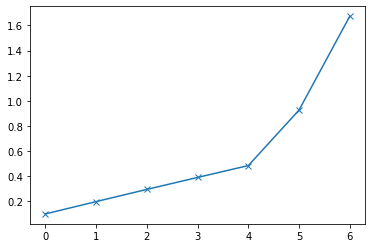

In [382]:
# t_0, t_end = 1000, 1450 #2950, 3150

t_0 = actual_tracks_dict_all_with_headway[203][0,0]
t_end = 1500 #actual_tracks_dict_all_with_headway[207][-1,0]-50
print(t_0, t_end)


rmse_1sec_list = []
rmse_2sec_list = []
rmse_3sec_list = []
rmse_4sec_list = []
rmse_5sec_list = []
rmse_10sec_list = []
rmse_20sec_list = []

for t_i in range(t_0, t_end):
    t_0_i = t_i
    t_end_i = t_i+50
    
    tracks_xy_halluc_dict, rmse_list, _ = simulate_pos_bunch_em(actual_tracks_dict_all_with_headway, \
                                                              mle_probs_final_all_veh, params_range, lanes_rxy, \
                                                              t_0_i, t_end_i)
    
    print('\n\nRMSE....')
    for veh_id, track in tracks_xy_halluc_dict.items():

        indices = np.where(rmse_list[:,2] == veh_id)
        rmse_track = rmse_list[indices,:][0]
        print('veh_id', veh_id, 'rmse_track', rmse_track.shape)

#         if len(rmse_track) >= 21:
#             rmse_1sec_list.append(np.mean((rmse_track[1, 0] - rmse_track[1, 1])**2))
#             rmse_2sec_list.append(np.mean((rmse_track[2, 0] - rmse_track[2, 1])**2))
#             rmse_3sec_list.append(np.mean((rmse_track[3, 0] - rmse_track[3, 1])**2))
#             rmse_4sec_list.append(np.mean((rmse_track[4, 0] - rmse_track[4, 1])**2))
#             rmse_5sec_list.append(np.mean((rmse_track[5, 0] - rmse_track[5, 1])**2))
#             rmse_10sec_list.append(np.mean((rmse_track[10, 0] - rmse_track[10, 1])**2))
#             rmse_20sec_list.append(np.mean((rmse_track[20, 0] - rmse_track[20, 1])**2))
        if len(rmse_track) >= 21:
            rmse_1sec_list.append(np.linalg.norm(rmse_track[1, 0] - rmse_track[1, 1]))
            rmse_2sec_list.append(np.linalg.norm(rmse_track[2, 0] - rmse_track[2, 1]))
            rmse_3sec_list.append(np.linalg.norm(rmse_track[3, 0] - rmse_track[3, 1]))
            rmse_4sec_list.append(np.linalg.norm(rmse_track[4, 0] - rmse_track[4, 1]))
            rmse_5sec_list.append(np.linalg.norm(rmse_track[5, 0] - rmse_track[5, 1]))
            rmse_10sec_list.append(np.linalg.norm(rmse_track[10, 0] - rmse_track[10, 1]))
            rmse_20sec_list.append(np.linalg.norm(rmse_track[20, 0] - rmse_track[20, 1]))


rmse_1sec_mean = np.mean(rmse_1sec_list)
rmse_2sec_mean = np.mean(rmse_2sec_list)
rmse_3sec_mean = np.mean(rmse_3sec_list)
rmse_4sec_mean = np.mean(rmse_4sec_list)
rmse_5sec_mean = np.mean(rmse_5sec_list)
rmse_10sec_mean = np.mean(rmse_10sec_list)
rmse_20sec_mean = np.mean(rmse_20sec_list)

x_em = range(7)
y_em = [rmse_1sec_mean, rmse_2sec_mean, rmse_3sec_mean, rmse_4sec_mean, rmse_5sec_mean, rmse_10sec_mean, rmse_20sec_mean]

plt.figure()
plt.plot(x,y, 'x-')
plt.show()

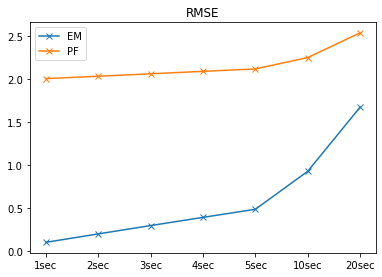

In [389]:
with open('PF_IDM_MOBIL_5epochs_100particles_results.pkl', 'rb') as file:
    pf_idm_mobil_results = pickle.load(file)
    
x_pf = pf_idm_mobil_results['x_pf']
y_pf = pf_idm_mobil_results['y_pf']

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_em, y_em, 'x-', label='EM');
ax.plot(x_pf, y_pf, 'x-', label='PF');
ax.legend()
ax.set_title('RMSE')
ax.set_xticks([0,1,2,3,4,5,6]);
ax.set_xticklabels(['1sec','2sec','3sec','4sec','5sec','10sec', '20sec']);

In [392]:
## collisions, off-roadway

# print(tracks_xy_halluc_dict_pf.keys())
count = 0
for veh_id, track in tracks_xy_halluc_dict_em.items():
    
#     if veh_id == 203: 
#         print('veh_id', veh_id, len(track))
        
        for t in range(len(track)):
            xy_ego = track[t, 1:3]

            for veh_id_other, track_other in tracks_xy_halluc_dict_em.items():
                if veh_id < veh_id_other:
                    distance = np.min(cdist(np.array([xy_ego]), track_other[:,1:3], 'euclidean'))

                    if distance < 2.0:
                        print(t, veh_id_other, distance)
                        count += 1

print(count)

0 207 0.4159947343981496
0 214 0.46168352128789125
1 207 0.40678201935616165
1 214 0.4616835387015332
2 207 0.40691717735890925
2 214 0.4616835654130049
3 207 0.4157318182651364
3 214 0.46168359223876926
4 207 0.4037561827280635
4 214 0.46168361925113865
5 207 0.41626059728993436
5 214 0.46168364248908406
6 207 0.40664982445023184
6 214 0.4616836645355439
7 207 0.40705528125617374
7 214 0.46168368660168496
8 207 0.41547169167539627
8 214 0.461683708794003
9 207 0.40376066056611026
9 214 0.46168373272265983
10 207 0.41652918189952937
10 214 0.46168375671789014
11 207 0.4065205454698914
11 214 0.4616837807821587
12 207 0.40719630053397005
12 214 0.46168380496385625
13 207 0.4152143017781849
13 214 0.46168382913118966
14 207 0.4037681236473723
14 214 0.4616838533054884
15 207 0.4168004993180376
15 214 0.4616838775526907
16 207 0.4063941897293291
16 214 0.4616839021051432
17 207 0.4073402344791534
17 214 0.4616839269080645
18 207 0.4149596536392803
18 214 0.4616839517349453
19 207 0.403778

13 216 0.2704819530029753
13 219 0.4984088837991636
14 206 0.31201695613194186
14 208 0.13662921235612369
14 212 0.5281529498292877
14 216 0.2912089893775036
14 219 0.4950724112044641
15 206 0.27212844753787563
15 208 0.1016030002170551
15 212 0.5281530684765845
15 216 0.31838352376812795
15 219 0.4966903207294202
16 206 0.23596059413991297
16 208 0.08310915316815155
16 212 0.5281531876112483
16 216 0.3505092356679599
16 219 0.5032148738475201
17 206 0.2054876495181126
17 208 0.09175785287906825
17 212 0.5281533082460775
17 216 0.38635308649266253
17 219 0.5144594675386364
18 206 0.1835681641192425
18 208 0.12190309391147836
18 212 0.5281534297954317
18 216 0.4249753847436362
18 219 0.5301238780384159
19 206 0.17347552151734938
19 208 0.1619561450905664
19 212 0.5281535522555998
19 216 0.40321311764720086
19 219 0.5498305246155981
20 206 0.17724191482461524
20 208 0.20622286557548458
20 212 0.528153676322625
20 216 0.3660358999313879
20 219 0.5731626578780941
21 206 0.1940622490486326


96 208 0.2727835162408557
96 212 0.5281659282369623
96 216 0.2543199185797973
96 219 0.520078922194731
97 206 0.3836803368581568
97 208 0.22595899233530867
97 212 0.5281661209291287
97 216 0.25741785979970117
97 219 0.5070632560362289
98 206 0.35629587447692057
98 208 0.18065112261968141
98 212 0.5281663143647882
98 216 0.2697675809761872
98 219 0.4986632946744113
99 206 0.3138429168961828
99 208 0.13835843305973902
99 212 0.5281665086224914
99 216 0.29019045003876676
99 219 0.4951140966919967
100 206 0.2738143930539593
100 208 0.10287018189937507
100 212 0.5281667030497254
100 216 0.31713073085592947
100 219 0.49651977194916486
101 206 0.2374398679360604
101 208 0.08338230286134239
101 212 0.5281668987183629
101 216 0.3490828772976764
101 219 0.5028388448211512
102 206 0.206658137947019
102 208 0.09085254056509229
102 212 0.5281670942828005
102 216 0.384800544162244
102 219 0.5138901686475584
103 206 0.18429354857877273
103 208 0.12036248592960838
103 212 0.5281672910797225
103 216 0.

24 216 0.31215178125888654
24 219 0.40806128319996543
25 208 0.296812022947913
25 212 0.3222156785891355
25 216 0.3121523542330032
25 219 0.40806151348374936
26 208 0.29681222760333786
26 212 0.3156821030006872
26 216 0.3121529329827642
26 219 0.4080617469311191
27 208 0.29681243334345137
27 212 0.316866414013603
27 216 0.31215351640530214
27 219 0.40806198123692244
28 208 0.2968126413186053
28 212 0.3256844946198358
28 216 0.31215410430530766
28 219 0.4080622185264082
29 208 0.2968128506542459
29 212 0.34154565109087764
29 216 0.31215469822175274
29 219 0.40806245689237136
30 208 0.2968130618812009
30 212 0.3635292210982957
30 216 0.3121552953092619
30 219 0.4080626979055656
31 208 0.2968132748182507
31 212 0.39060289883740495
31 216 0.3121558994962431
31 219 0.40806294037425106
32 208 0.2968134892248508
32 212 0.42178770363444923
32 216 0.3121565059973183
32 219 0.40806318498652927
33 208 0.296813705770548
33 212 0.4515716544781636
33 216 0.31215712003728824
33 219 0.408063431604783


101 212 0.38309745190159633
101 216 0.3122085613079917
101 219 0.4080841117669924
102 208 0.2968321597060406
102 212 0.357251538335697
102 216 0.3122094348791902
102 219 0.4080844621707577
103 208 0.29683246784686584
103 212 0.3367667997694485
103 216 0.3122103080644667
103 219 0.4080848132026148
104 208 0.2968327771628944
104 212 0.32266603644023356
104 216 0.3122111864051571
104 219 0.40808516582182347
105 208 0.29683308673329845
105 212 0.3158056494544282
105 216 0.3122120640478826
105 219 0.40808551835094203
106 208 0.29683339771962575
106 212 0.31665668336215314
106 216 0.31221294670173955
106 219 0.40808587298847565
107 208 0.2968337086893776
107 212 0.32515869652972207
107 216 0.32596717428105976
107 219 0.4080862270370415
108 208 0.29683402121046953
108 212 0.3407395533883668
108 216 0.3259679878467994
108 219 0.40808658347166654
109 208 0.296834333548442
109 212 0.362487678631296
109 216 0.3259688003511366
109 219 0.40808693906289545
110 208 0.2968346474667397
110 212 0.389371

140 212 0.6586414719953195
140 216 0.8936231936621587
140 219 0.6534662726884576
141 208 1.2584715414334096
141 212 0.6834850053116986
141 216 0.9066512359576802
141 219 0.7248950901377731
142 208 1.2273308079582528
142 212 0.6892712478578275
142 216 0.9334533801138617
142 219 0.66232952303445
143 208 1.246407678431075
143 212 0.657203800438476
143 216 0.890786204136489
143 219 0.6602477007110635
144 208 1.2489591365074009
144 212 0.7163123231334299
144 216 0.9165841095777173
144 219 0.7298682217958457
145 208 1.227064544262484
145 212 0.6661570181899245
145 216 0.9205513447533206
145 219 0.6547871998476228
146 208 1.6215368960535015
146 212 1.042751535461733
146 216 1.2791469163889375
146 219 1.0375777370066963
147 208 1.6383529841632978
147 212 1.080001534787855
147 216 1.2868938811866142
147 219 1.0822906751537476
148 208 1.6134874483702704
148 212 1.0489995129180356
148 216 1.3083502656263843
148 219 1.0445559646122993
149 208 1.6269368126042958
149 212 1.0502619822961847
149 216 1

63 219 0.5861743595128377
64 212 0.5738000083141622
64 216 0.4199862672180663
64 219 0.5861744042754281
65 212 0.5809162179332354
65 216 0.4199867570200004
65 219 0.5861744493932131
66 212 0.5921172527000953
66 216 0.4199872483257361
66 219 0.5861744946101858
67 212 0.6071771514241859
67 216 0.4199877433036924
67 219 0.5861745402016391
68 212 0.6258174538723161
68 216 0.4199882395279372
68 219 0.5861745858753802
69 212 0.6477291852682867
69 216 0.41998873947958254
69 219 0.5861746319206586
70 212 0.6438972404752383
70 216 0.4199892406167164
70 219 0.5861746780527761
71 212 0.6225044207999665
71 216 0.41998974535200334
71 219 0.586174724531209
72 212 0.6044349668723701
72 216 0.41999025139881807
72 219 0.5861747711247587
73 212 0.5899943738779878
73 216 0.41999076072073627
73 219 0.5861748180149032
74 212 0.5794540772231835
74 216 0.4199912716734839
74 219 0.5861748650717903
75 212 0.5730294124376027
75 216 0.41999178538413356
75 219 0.5861749123533421
76 212 0.570859422570064
76 216 0.

112 216 0.40666929786791833
112 219 0.18188298727378
113 216 0.39707175647502396
113 219 0.23141820453945955
114 216 0.3582215788975187
114 219 0.2809628529402063
115 216 0.37419926517700625
115 219 0.33051274442916
116 216 0.3325525807406035
116 219 0.3225388120482914
117 216 0.29338267916399524
117 219 0.2729902579997017
118 216 0.2578210194115669
118 219 0.22344716408031548
119 216 0.22756564001320073
119 219 0.17391431222085965
120 216 0.204979948291029
120 219 0.12440408693529989
121 216 0.19277891658676252
121 219 0.07496159903113356
122 216 0.19294292159892734
122 219 0.025977291238164908
123 216 0.20544248948364793
123 219 0.025360416235649115
124 216 0.2282601658358698
124 219 0.07432545387323632
125 216 0.25867989487141846
125 219 0.12376681887216708
126 216 0.29435425373089485
126 219 0.1732773685002977
127 216 0.3336018216938517
127 219 0.22281107277884601
128 216 0.37530333295123425
128 219 0.27235537119985676
129 216 0.3816392062370933
129 219 0.3219054283108761
130 216 0

In [ ]:
## hard braking

# print(tracks_xy_halluc_dict_pf.keys())
for veh_id, track in tracks_xy_halluc_dict_pf.items():
    if veh_id == 206: #> 201 and veh_id < 210:
        for t in range(len(track)-1):
            vsvd = track[t+1, 3:5] - track[t, 3:5]
            asad = track[t+1, 5:7] - track[t, 5:7]
            print(t, vsvd)


In [ ]:
# print(tracks_xy_halluc_dict_em.keys())
count = 0
for veh_id, track in tracks_xy_halluc_dict_em.items():
    if veh_id == 207:
        for p, point in enumerate(track):
            if point[10] == 'c':
                dist = np.min(cdist(np.array([point[1:3]]), lane_c_rxy, 'euclidean'))
            elif point[10] == 'd':
                dist = np.min(cdist(np.array([point[1:3]]), lane_d_rxy, 'euclidean'))
            print(point[10], dist)
            
            if dist > 1.5:
                count += 1
    

In [ ]:
## Results with PF




In [369]:
# def simulate_pos_bunch_pf(tracks_dict, p_mat_final_all_veh, p_mean_final_all_veh, lanes_rxy, t_0, t_end):

#     v_des_all_veh, eps_all_veh, pol_all_veh, lam_all_veh = dict(), dict(), dict(), dict()
#     M = 1 #Monte Carlo simulation for each vehicle
    
#     for veh_id, p_mat_final in p_mat_final_all_veh.items():
        
#         v_des_all_veh[veh_id] = []
#         eps_all_veh[veh_id] = []
#         pol_all_veh[veh_id] = []
#         lam_all_veh[veh_id] = []
        
#         for m in range(M):
#             v_des_all_veh[veh_id].append(np.random.choice(p_mat_final[:,0], size=1)[0])
#             eps_all_veh[veh_id].append(np.random.choice(p_mat_final[:,1], size=1)[0])
#             pol_all_veh[veh_id].append(np.random.choice(p_mat_final[:,2], size=1)[0])
#             lam_all_veh[veh_id].append(np.random.choice(p_mat_final[:,3], size=1)[0])  
#         print('veh_id', veh_id, 'v_des', v_des_all_veh[veh_id], 'eps', eps_all_veh[veh_id], 'pol', pol_all_veh[veh_id], 'lam', lam_all_veh[veh_id])
        
                
#     tracks_halluc_dict = dict()
#     change_lane_switch = dict()
# #     tracks_samples_dict = dict()
#     t_range = np.arange(t_0, t_end)
    
#     rmse_list = []
#     ll_list = []
    
#     for t in t_range:
#         print('\n\n t', t)
#         for veh_id, track in tracks_dict.items():
            
#             idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
#             if len(idx_t) == 1 and veh_id in mle_probs_final_all_veh.keys():
                
# #                 print('\n-----veh_id', veh_id, '-----')
                
#                 if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
#                     track_0 = tracks_dict[veh_id][idx_t[0], :21]
                    
#                     tracks_halluc_dict[veh_id] = track_0[None,:]
#                     change_lane_switch[veh_id] = 0
# #                     tracks_samples_dict[veh_id] = []
#                     rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], tracks_dict[veh_id][idx_t[0], 3], veh_id, t])  #[s_true, s_pred, veh_id, t]      
                    
#                 else:   # if already exists in tracks_halluc_dict
#                     idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]
#                     veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0], 11]

#                     for m in range(M):
#                         v_des = v_des_all_veh[veh_id][m]
#                         eps = eps_all_veh[veh_id][m]
#                         pol = pol_all_veh[veh_id][m]
#                         lam = lam_all_veh[veh_id][m]
                            
#                         if change_lane_switch[veh_id] == 0:  ##if lane-change has not started
# #                             print("\n...Lane-change switch is 0...")

#                             ### prob of changing lane
#                             prob_lane, _, veh_id_new = get_lane_change_prob(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
#                                                                         tracks_dict, p_mean_final_all_veh)
# #                             prob_lane, _, veh_id_new = get_lane_change_prob_EM(veh_id, tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des, pol, lam, \
# #                                                                                tracks_dict, mle_probs_final_all_veh, params_range)
# #                             print('prob_lane', prob_lane)


#                             ### samples for next 1-step
#                             if prob_lane >= 0.52:
#                                 print('\n-----veh_id', veh_id, '-----')
#                                 print("...Lane-change switch was 0... => initiated lane-change, prob_lane", prob_lane)
#                                 change_lane_switch[veh_id] = 1

#                                 idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
#     #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

#                                 sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
#                                 xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)
# #                                 print('lane_pred', lane_pred)

#                                 if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]:  ##if lane has changed 
#                                     print(' Lane has changed to ', lane_pred)
#                                     idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
#                                     dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

#                                     track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
#                                                                         [idx_hw_new[0]],
#                                                                         [dist_headway_pred],
#                                                                         [lane_pred]))
                        
#                                     if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
#                                         change_lane_switch[veh_id] = 0
#                                     else:                               ##if lane has changed but haven't merged into new lane yet 
#                                         change_lane_switch[veh_id] = 2
                                    
                            
#                                 else:  ##if lane has not changed yet (still in the process of lane-changing)
#                                     dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
#                                     track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
#                                                                         [dist_headway_pred],
#                                                                         [tracks_dict[veh_id][idx_t[0], 20]]))
#                                     change_lane_switch[veh_id] = 1

#                                 track_pred = np.concatenate(([t], # t
#                                                              xy_next_pred, #x,y
#                                                              sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                              tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
#                                                              [lane_pred], #lane
#                                                              track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
#                                                              )) #s_cd, d_cd    
#                                 tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
# #                                 print(" ====> track_pred", track_pred, '\n')


#                             elif prob_lane < 0.52:
#                                 change_lane_switch[veh_id] = 0
                                
#     #                             print('\nnot change lane... prob_lane:', prob_lane)
#                                 sd_next_pred, vsvd_next_pred, _ = hallucinate_a_step_no_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], v_des)  #IDM
#     #                             print('sd_next_pred', sd_next_pred)
#                                 xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
#                                                                              tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
#     #                             print('xy_next_pred', xy_next_pred.shape, xy_next_pred)
#                                 if xy_next_pred.shape == (2,1): 
#                                     xy_next_pred = xy_next_pred.reshape((2,))
#                                 dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

#                                 track_pred = np.concatenate(([t], # t
#                                                              xy_next_pred, #x,y
#                                                              sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                              tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
#                                                              tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
#                                                              [dist_headway_pred], #dist_headway
#                                                              [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
#                                                              )) #s_cd, d_cd                            
#                                 tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 

#                             else:
#                                 print('Error... prob_lane', prob_lane)

                                
#                         elif change_lane_switch[veh_id] == 1:  ##if lane-change has started and not finished
#                             print('\n-----veh_id', veh_id, '-----')
#                             print("...Lane-change switch is 1...")
                            
#                             idx_t_real = np.where(actual_tracks_dict_all_with_headway[veh_id][:,0] == t)[0]
# #                             print('real_v_lat', actual_tracks_dict_all_with_headway[veh_id][idx_t_real,6])

#                             sd_next_pred, vsvd_next_pred, lane_pred = hallucinate_a_step_change(tracks_halluc_dict[veh_id][idx_own_0[0],:], lanes_rxy, v_des)  #pd controller (lane change) 
#                             xy_next_pred, sd_cd_next_pred = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3], lane_pred, lanes_rxy)

#                             if lane_pred != tracks_halluc_dict[veh_id][idx_own_0[0],10]: ##if lane has changed 
#                                 print(' Lane has changed to ', lane_pred)
#                                 idx_hw_new = np.where(tracks_dict[veh_id_new][:,0] == t)[0]
#                                 dist_headway_pred = tracks_dict[veh_id_new][idx_hw_new[0], 3] - sd_next_pred[0]

#                                 track_headway_new = np.concatenate((tracks_dict[veh_id_new][idx_hw_new[0],:7],
#                                                                     [idx_hw_new[0]],
#                                                                     [dist_headway_pred],
#                                                                     [lane_pred]))
                                
#                                 if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
#                                     change_lane_switch[veh_id] = 0
#                                 else:                               ##if lane has changed but haven't merged into new lane yet 
#                                     change_lane_switch[veh_id] = 2

#                             else:  ##if lane has not changed yet (still in the process of lane-changing)
#                                 dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]
#                                 track_headway_new = np.concatenate((tracks_dict[veh_id][idx_t[0], 11:19],
#                                                                     [dist_headway_pred],
#                                                                     [tracks_dict[veh_id][idx_t[0], 20]]))
#                                 change_lane_switch[veh_id] = 1

#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:10], #agent_type, length, width
#                                                          [lane_pred], #lane
#                                                          track_headway_new # #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx, #dist_headway #headway_lane 
#                                                          )) #s_cd, d_cd    
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
# #                             print(" ====> track_pred", track_pred, '\n')
                               

#                         elif change_lane_switch[veh_id] == 2:  ##if lane-change has changed but haven't merged into new lane yet 
#                             print('\n-----veh_id', veh_id, '-----')
#                             print("...Lane-change switch was 2...")
                    
#                             track_i = tracks_halluc_dict[veh_id][idx_own_0[0],:]

#                             if track_i[10] == 'c': 
#                                 offset = track_i[4] # - min_dist_bet_lanes 
#                             elif track_i[10] == 'd': 
#                                 offset = track_i[4] #+ min_dist_bet_lanes 
#                             print('track_i[4]', track_i[4], 'track_i[6]', track_i[6], 'track_i[10]', track_i[10], 'offset', offset)
                            
#                             a_lat_pred = - offset * 0.02 
#                             v_lat_pred = track_i[6] + a_lat_pred
#                             s_lat_pred = track_i[4] + track_i[6] + 0.5 * a_lat_pred
#                             print('s_lat_pred', s_lat_pred)
                              
#                             sd_next_pred_idm, vsvd_next_pred_idm, _ = hallucinate_a_step_no_change(track_i, v_des)   
#                             sd_next_pred = [sd_next_pred_idm[0], s_lat_pred]
#                             vsvd_next_pred = [vsvd_next_pred_idm[0], v_lat_pred]
                            
#                             xy_next_pred, _ = get_xy_sd_cd(sd_next_pred, tracks_halluc_dict[veh_id][idx_own_0[0],1:3],
#                                                                          tracks_halluc_dict[veh_id][idx_own_0[0],10], lanes_rxy)
#                             if xy_next_pred.shape == (2,1): 
#                                 xy_next_pred = xy_next_pred.reshape((2,))
#                             dist_headway_pred = tracks_dict[veh_id][idx_t[0], 14] - sd_next_pred[0]

#                             track_pred = np.concatenate(([t], # t
#                                                          xy_next_pred, #x,y
#                                                          sd_next_pred, vsvd_next_pred, #s,d,vs,vd
#                                                          tracks_halluc_dict[veh_id][idx_own_0[0], 7:11], #agent_type, length, width, lane
#                                                          tracks_dict[veh_id][idx_t[0], 11:19], #headway_veh_id, headway_x/y/s/d/vs/vd, headway_idx
#                                                          [dist_headway_pred], #dist_headway
#                                                          [tracks_dict[veh_id][idx_t[0], 20]] #headway_lane
#                                                          )) #s_cd, d_cd                            
#                             tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track_pred)) 
                            
#                             if np.abs(sd_next_pred[1]) < 0.2 :  ##if lane has changed and merged into new lane smoothly
#                                 change_lane_switch[veh_id] = 0
#                             else:                               ##if lane has changed but haven't merged into new lane yet 
#                                 change_lane_switch[veh_id] = 2
                            
# #                         print('sd_next_pred', type(sd_next_pred), len(sd_next_pred), 'tracks_dict[veh_id][idx_t[0],3:5]', type(tracks_dict[veh_id][idx_t[0],3:5]), len(tracks_dict[veh_id][idx_t[0],3:5]))
# #                         ll_list.append(multi_normal(np.array(sd_next_pred), np.diag([eps]*2)).pdf(tracks_dict[veh_id][idx_t[0],3:5]))
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3:5], sd_next_pred, veh_id, t])  #[sd_true, sd_pred, veh_id, t]      

        
#     rmse_list = np.array(rmse_list)
# #     ll_list = np.array(ll_list)

    
#     tracks_xy_halluc_dict = dict()
#     for veh_id, track_halluc in tracks_halluc_dict.items():
#         veh_s, veh_d = track_halluc[:,3], track_halluc[:,4]

#         veh_x_ret, veh_y_ret = [], []
#         for i in range(len(veh_s)):
                    
#             if track_halluc[i,10] == 'c': 
#                 sp = sp_c
#             elif track_halluc[i,10] == 'd': 
#                 sp = sp_d

#             lane_xi, lane_yi = sp.calc_position(veh_s[i])
#             if lane_xi == None:
#                 terminate_i = i
#                 break

#             yawi = sp.calc_yaw(veh_s[i])
#             xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
#             yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

#             veh_x_ret.append(xi_ret)
#             veh_y_ret.append(yi_ret)

#         track_xy_ret = np.column_stack((track_halluc[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_halluc[:len(veh_x_ret),3:]))
#         tracks_xy_halluc_dict[veh_id] = track_xy_ret
# #         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id])
        
#     return tracks_xy_halluc_dict, rmse_list, ll_list


In [477]:
params_range = [np.arange(z_min, z_max, 0.4),
                np.arange(eps_min, eps_max, 0.03)]

idx_range = [range(len(p_range)) for p_range in params_range]
[z_range, eps_range] = params_range

# mle_probs = [np.ones_like(p_range) / len(p_range) for p_range in params_range]
mle_probs = [np.random.dirichlet(np.ones_like(p_range)) for p_range in params_range]
print('mle_probs', mle_probs)

[z_probs, eps_probs] = mle_probs
print('z_probs', z_probs.shape, z_probs)
print('eps_probs', eps_probs.shape, eps_probs)

lkhd_vec = np.array([0.5, 0.3])#, 0.8])
print('lkhd_vec', lkhd_vec)

weights = np.zeros((len(lkhd_vec), len(z_range), len(eps_range)))
for z_idx, eps_idx in itertools.product(*idx_range):                
    weights[:, z_idx, eps_idx] = lkhd_vec[:] * z_probs[z_idx] * eps_probs[eps_idx]
    
weights = weights #/ lkhd_vec[:,None,None]

print('\nweights', weights.shape, weights)
print('\nweights.sum(axis=(1,2))', weights.sum(axis=(1,2)))
print('weights.sum(axis=1)', weights.sum(axis=1).shape, weights.sum(axis=1), weights.sum(axis=1).sum(axis=1))
print('weights.sum(axis=2)', weights.sum(axis=2).shape, weights.sum(axis=2), weights.sum(axis=2).sum(axis=1))

ELBO = np.sum(np.log(weights), axis=(1,2))
print('\nELBO', ELBO)


mle_probs [array([0.1351467 , 0.67028984, 0.19456347]), array([0.19191283, 0.05110891, 0.60306069, 0.11868008, 0.03523747])]
z_probs (3,) [0.1351467  0.67028984 0.19456347]
eps_probs (5,) [0.19191283 0.05110891 0.60306069 0.11868008 0.03523747]
lkhd_vec [0.5 0.3]

weights (2, 3, 5) [[[0.01296819 0.0034536  0.04075083 0.00801961 0.00238111]
  [0.06431861 0.01712889 0.20211273 0.03977503 0.01180966]
  [0.01866961 0.00497196 0.05866679 0.0115454  0.00342796]]

 [[0.00778092 0.00207216 0.0244505  0.00481177 0.00142867]
  [0.03859117 0.01027734 0.12126764 0.02386502 0.0070858 ]
  [0.01120177 0.00298318 0.03520007 0.00692724 0.00205678]]]

weights.sum(axis=(1,2)) [0.5 0.3]
weights.sum(axis=1) (2, 5) [[0.09595642 0.02555446 0.30153035 0.05934004 0.01761874]
 [0.05757385 0.01533267 0.18091821 0.03560403 0.01057124]] [0.5 0.3]
weights.sum(axis=2) (2, 3) [[0.06757335 0.33514492 0.09728173]
 [0.04054401 0.20108695 0.05836904]] [0.5 0.3]

ELBO [-62.41103993 -70.07342429]


In [284]:
def compute_rmse(tracks_xy_halluc_dict, rmse_list):

    rmse_1sec_list = []
    rmse_5sec_list = []
    rmse_10sec_list = []
    rmse_20sec_list = []

    for veh_id, track in tracks_xy_halluc_dict.items():

#         if veh_id >=2 and veh_id < 120:
            indices = np.where(rmse_list[:,2] == veh_id)
            rmse_track = rmse_list[indices,:][0]
            print('veh_id', veh_id, 'rmse_track', rmse_track.shape)

            rmse_1sec_list.append(np.mean((rmse_track[1, 0] - rmse_track[1, 1])**2))
            rmse_5sec_list.append(np.mean((rmse_track[5, 0] - rmse_track[5, 1])**2))
            rmse_10sec_list.append(np.mean((rmse_track[10, 0] - rmse_track[10, 1])**2))
            rmse_20sec_list.append(np.mean((rmse_track[20, 0] - rmse_track[20, 1])**2))
        
    rmse_1sec_mean = np.mean(rmse_1sec_list)
    rmse_5sec_mean = np.mean(rmse_5sec_list)
    rmse_10sec_mean = np.mean(rmse_10sec_list)
    rmse_20sec_mean = np.mean(rmse_20sec_list)
    
    return [rmse_1sec_mean, rmse_5sec_mean, rmse_10sec_mean, rmse_20sec_mean]

In [285]:
RMSE_accel = compute_rmse(tracks_xy_halluc_dict_em, rmse_list_em)
print(RMSE_accel)

veh_id 548 rmse_track (46, 4)
veh_id 551 rmse_track (76, 4)
veh_id 554 rmse_track (2, 4)


IndexError: index 5 is out of bounds for axis 0 with size 2

(13, 6)
(6,) [0.15170269 0.1741818  0.16781899 0.16947442 0.17729989 0.15952222]


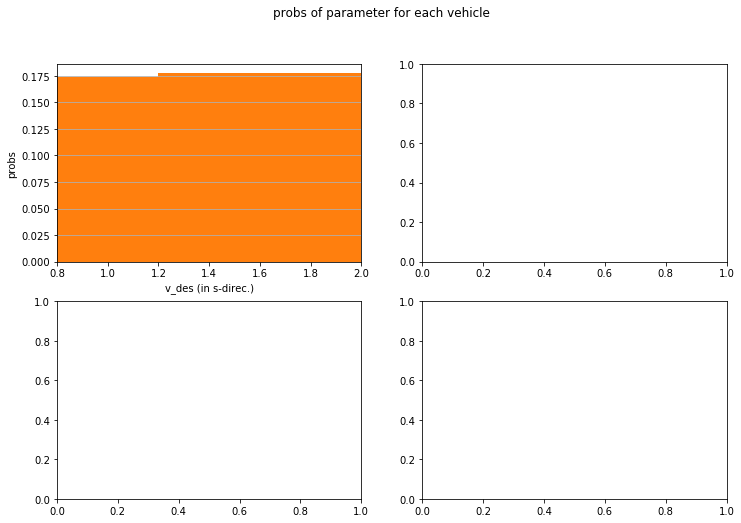

In [283]:

z_probs_all_veh, eps_probs_all_veh, pol_probs_all_veh, lam_probs_all_veh = [], [], [], []

for veh_id, mle_probs in mle_probs_final_all_veh.items():
    z_probs_all_veh.append(mle_probs[0])
    eps_probs_all_veh.append(mle_probs[1])
    pol_probs_all_veh.append(mle_probs[2])
    lam_probs_all_veh.append(mle_probs[3])
    
z_probs_mean = np.mean(z_probs_all_veh, axis=0)
print(z_probs_mean.shape, z_probs_mean)


fig, axs = plt.subplots(2, 2, figsize=[12, 8])
fig.suptitle('probs of parameter for each vehicle')

axs[0, 0].set_xlabel('v_des (in s-direc.)'); axs[0, 0].set_ylabel('probs'); 
axs[0, 0].set_xlim([z_min, z_max]); axs[0, 0].yaxis.grid()
axs[0, 0].bar(params_range[0], z_probs_mean, color="C1", alpha=0.7, edgecolor='white'); 

# axs[0, 1].set_xlabel('eps'); axs[0, 1].set_ylabel('probs'); 
# axs[0, 1].set_xlim([eps_min, eps_max]); axs[0, 1].yaxis.grid()
# axs[0, 1].hist(eps_probs_mean, density=False, bins=15, color="C1", alpha=0.7, edgecolor='white'); 

# axs[1, 0].set_xlabel('polite'); axs[1, 0].set_ylabel('probs'); 
# axs[1, 0].set_xlim([pol_min, pol_max]); axs[1, 0].yaxis.grid()
# axs[1, 0].hist(pol_probs_mean, density=False, bins=18, color="C1", alpha=0.7, edgecolor='white'); 

# axs[1, 1].set_xlabel('lambda'); axs[1, 1].set_ylabel('probs'); 
# axs[1, 1].set_xlim([lam_min, lam_max]); axs[1, 1].yaxis.grid()
# axs[1, 1].hist(lam_probs_mean, density=False, bins=18, color="C1", alpha=0.7, edgecolor='white'); 
# plt.savefig("IDM+MOBIL_EM.pdf")
plt.show()


In [359]:
# def obj_function(theta, weights_normed, params_range, track, actual_tracks_dict_all_with_headway, mle_probs_final_all_veh, lanes_rxy):
        
#         print('obj_function: theta', theta.shape)
#         [z_probs, eps_probs, pol_probs, lam_probs] = theta

#         idx_range = [range(len(p_range)) for p_range in params_range]
#         [z_range, eps_range, pol_range, lam_range] = params_range

#         weights = np.zeros((len(track)-1, len(z_range), len(eps_range), len(pol_range), len(lam_range)))

#         for i in range(len(track)-1):  
#             veh_id = track[0,0]
#             sd_next_true = track[i+1, 3:5]

#             for z_idx, eps_idx, pol_idx, lam_idx in itertools.product(*idx_range):

#                 sd_next_pred_no_change, _, _ = hallucinate_a_step_no_change(track[i], z_range[z_idx])  #IDM
#                 likeli_pos_no_change = multi_normal([sd_next_pred_no_change[0]], eps_range[eps_idx]).pdf([sd_next_true[0]]) #observation model

#                 sd_next_pred_change, _, _ = hallucinate_a_step_change(track[i], lanes_rxy, z_range[z_idx])  #pd controller (lane change) 
#                 likeli_pos_change = multi_normal(sd_next_pred_change, eps_range[eps_idx]*2).pdf(sd_next_true) #observation model

#                 prob_lane, _, _ = get_lane_change_prob_EM(veh_id, track[i], z_range[z_idx], pol_range[pol_idx], lam_range[lam_idx], \
#                                                           actual_tracks_dict_all_with_headway, mle_probs_final_all_veh, params_range)  #MOBIL

#                 lkhd_vec = likeli_pos_no_change * (1-prob_lane) + likeli_pos_change * prob_lane  #p(Data|Latent,params)

#                 weights[i, z_idx, eps_idx, pol_idx, lam_idx] = lkhd_vec * z_probs[z_idx] * eps_probs[eps_idx] * pol_probs[pol_idx] * lam_probs[lam_idx]    
#         print('weights_normed', weights_normed.shape, 'lkhd_vec', lkhd_vec.shape, 'product', (weights_normed * np.log(lkhd_vec)).shape)
#         return np.sum(weights_normed * np.log(lkhd_vec))
    

In [265]:
max_iter_per_veh = 5
lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

mle_probs_final_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh = run_EM_plot(actual_tracks_dict_all_with_headway, \
                                                                                             lanes_rxy, max_iter_per_veh, params_range,\
                                                                                             optimizer='lagrangian')




 veh_id 546
it 0
marginal likelihood : 137.08911377671234
update marginal_ll and mle_probs
it 1
marginal likelihood : 136.34140799569656
it 2
marginal likelihood : 138.36458438548533
update marginal_ll and mle_probs
it 3
marginal likelihood : 136.47517361981068


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log


it 4
marginal likelihood : 150.7960816648681
update marginal_ll and mle_probs
mle_probs_final : [array([0.19674117, 0.14281384, 0.21790788, 0.16224224, 0.16674633,
       0.11354854]), array([0.44006824, 0.12700891, 0.17322981, 0.10906771, 0.15062532]), array([0.28158862, 0.25856446, 0.27489471, 0.18495222]), array([0.1398721 , 0.49264303, 0.02048929, 0.2058551 , 0.14114047])]

 veh_id 548
it 0
marginal likelihood : 167.48320315402214
update marginal_ll and mle_probs
it 1
marginal likelihood : 166.93168027415996
it 2
marginal likelihood : 166.68502079557376


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log


it 3
marginal likelihood : 169.70473362182122
update marginal_ll and mle_probs
it 4
marginal likelihood : 166.9939509661358
mle_probs_final : [array([0.10288548, 0.11784291, 0.20391182, 0.22595615, 0.1979533 ,
       0.15145034]), array([0.20763845, 0.16725064, 0.19844232, 0.20652822, 0.22014037]), array([0.26043968, 0.30472728, 0.12866003, 0.30617301]), array([0.01727436, 0.22814481, 0.23436262, 0.23150003, 0.28871819])]

 veh_id 549
it 0
marginal likelihood : 106.42046695333791
update marginal_ll and mle_probs
it 1
marginal likelihood : 107.25576005321857
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.1760886 , 0.1749713 , 0.1991509 , 0.14819496, 0.14935127,
       0.15224297]), array([0.19396011, 0.22986628, 0.10776476, 0.21218915, 0.25621969]), array([0.24467439, 0.24784816, 0.25477603, 0.25270142]), array([0.03276092, 0.27924229, 0.16656342, 0.24351511, 0.27791825])]

 veh_id 550
it 0
marginal likelihood : 108.68692858901801
update marginal_ll and mle_probs
it 

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log


update marginal_ll and mle_probs
break
mle_probs_final : [array([0.13031525, 0.17691666, 0.14736064, 0.1978382 , 0.13770082,
       0.20986842]), array([0.21747266, 0.46127084, 0.14140685, 0.09451258, 0.08533708]), array([0.29645283, 0.317375  , 0.08382051, 0.30235167]), array([0.22769054, 0.15369874, 0.23080944, 0.22108022, 0.16672106])]

 veh_id 558
it 0
marginal likelihood : 114.34256868317227
update marginal_ll and mle_probs
it 1
marginal likelihood : 113.3630962923475
it 2
marginal likelihood : 113.90599761229694
it 3
marginal likelihood : 111.32833474373456
it 4
marginal likelihood : 110.8035856786916
mle_probs_final : [array([0.16103555, 0.161166  , 0.16164398, 0.16304631, 0.16081031,
       0.19229785]), array([0.17353189, 0.21377312, 0.19904947, 0.19058771, 0.22305782]), array([0.2626975 , 0.2009485 , 0.33622964, 0.20012437]), array([0.34723505, 0.07474945, 0.34039425, 0.10832151, 0.12929974])]

 veh_id 559
it 0
marginal likelihood : 166.1666327849989
update marginal_ll and ml

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log


update marginal_ll and mle_probs
break
mle_probs_final : [array([0.08989824, 0.10119186, 0.06865536, 0.22057758, 0.42283226,
       0.09684469]), array([0.21386589, 0.27768193, 0.1929851 , 0.17151125, 0.14395584]), array([0.27182615, 0.25234227, 0.20454181, 0.27128977]), array([0.14126783, 0.11995722, 0.14304108, 0.20502365, 0.39071023])]

 veh_id 564
it 0
marginal likelihood : 172.10432327589683
update marginal_ll and mle_probs
it 1
marginal likelihood : 171.92185582830447
it 2
marginal likelihood : 188.2526300300596
update marginal_ll and mle_probs
it 3
marginal likelihood : 183.22850625759705
it 4
marginal likelihood : 186.37272584625111
mle_probs_final : [array([0.19002173, 0.1765756 , 0.17966806, 0.20994717, 0.14936133,
       0.0944261 ]), array([0.44717097, 0.12025027, 0.17445919, 0.12164367, 0.13647591]), array([0.31092638, 0.16840019, 0.20644178, 0.31423165]), array([0.18213874, 0.1949926 , 0.23837114, 0.1887621 , 0.19573542])]

 veh_id 565
it 0
marginal likelihood : 117.17864

In [257]:
# max_iter_per_veh = 5
# lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

# mle_probs_final_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh = run_EM_plot(actual_tracks_dict_all_with_headway, \
#                                                                                              lanes_rxy, max_iter_per_veh, params_range)




 veh_id 546
it 0
marginal likelihood : 137.08911377671234
update marginal_ll and mle_probs
it 1
marginal likelihood : 136.34140799569656
it 2
marginal likelihood : 138.36458438548533
update marginal_ll and mle_probs
it 3
marginal likelihood : 136.47517361981068


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


it 4
marginal likelihood : 150.7960816648681
update marginal_ll and mle_probs
mle_probs_final : [array([0.19674117, 0.14281384, 0.21790788, 0.16224224, 0.16674633,
       0.11354854]), array([0.44006824, 0.12700891, 0.17322981, 0.10906771, 0.15062532]), array([0.28158862, 0.25856446, 0.27489471, 0.18495222]), array([0.1398721 , 0.49264303, 0.02048929, 0.2058551 , 0.14114047])]

 veh_id 548
it 0
marginal likelihood : 167.48320315402214
update marginal_ll and mle_probs
it 1
marginal likelihood : 166.93168027415996
it 2
marginal likelihood : 166.68502079557376


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log


it 3
marginal likelihood : 169.70473362182122
update marginal_ll and mle_probs
it 4
marginal likelihood : 166.9939509661358
mle_probs_final : [array([0.10288548, 0.11784291, 0.20391182, 0.22595615, 0.1979533 ,
       0.15145034]), array([0.20763845, 0.16725064, 0.19844232, 0.20652822, 0.22014037]), array([0.26043968, 0.30472728, 0.12866003, 0.30617301]), array([0.01727436, 0.22814481, 0.23436262, 0.23150003, 0.28871819])]

 veh_id 549
it 0
marginal likelihood : 106.42183879175256
update marginal_ll and mle_probs
it 1
marginal likelihood : 107.61728662968989
update marginal_ll and mle_probs
it 2
marginal likelihood : 110.63043685932598
update marginal_ll and mle_probs
it 3
marginal likelihood : 115.41031768575452
update marginal_ll and mle_probs
it 4
marginal likelihood : 116.86877446322848
update marginal_ll and mle_probs
mle_probs_final : [array([0.21802368, 0.08431252, 0.25418952, 0.1161038 , 0.20811266,
       0.11925782]), array([0.50937357, 0.17026836, 0.19009189, 0.02865301, 0.10

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log


update marginal_ll and mle_probs
it 1
marginal likelihood : 107.29375338972856
it 2
marginal likelihood : 109.48743587595368
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.15066003, 0.16510048, 0.16930321, 0.16863007, 0.17316438,
       0.17314183]), array([0.28701676, 0.13949082, 0.27265828, 0.23409802, 0.06673614]), array([0.29943214, 0.18231487, 0.2907305 , 0.2275225 ]), array([0.17138771, 0.18702639, 0.39503463, 0.12371336, 0.12283791])]

 veh_id 551
it 0
marginal likelihood : 168.7162866748247
update marginal_ll and mle_probs
it 1
marginal likelihood : 170.22575495738198
update marginal_ll and mle_probs
it 2
marginal likelihood : 171.87456237767447
update marginal_ll and mle_probs
it 3
marginal likelihood : 171.00623455801056
it 4
marginal likelihood : 169.59232726476654
mle_probs_final : [array([0.15111676, 0.16193241, 0.1571191 , 0.15472841, 0.17790796,
       0.19719536]), array([0.21186853, 0.23311914, 0.20706604, 0.21060501, 0.13734127]), array([0.39361816

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log


it 2
marginal likelihood : 111.58350298312031
it 3
marginal likelihood : 114.40929639529158
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.14635687, 0.25256297, 0.28196552, 0.10702082, 0.09679091,
       0.11530291]), array([0.23660753, 0.25592842, 0.22755259, 0.20437474, 0.07553672]), array([0.19675502, 0.25391231, 0.24328623, 0.30604645]), array([0.17328903, 0.17189339, 0.24362754, 0.21209634, 0.19909369])]

 veh_id 559
it 0
marginal likelihood : 166.15571808252668
update marginal_ll and mle_probs
it 1
marginal likelihood : 168.5392635413524
update marginal_ll and mle_probs
it 2
marginal likelihood : 167.64270561463312
it 3
marginal likelihood : 165.09609561760013
it 4
marginal likelihood : 167.67637597810923
mle_probs_final : [array([0.40664378, 0.14293838, 0.12709928, 0.15114768, 0.08664617,
       0.08552471]), array([0.225098  , 0.24402164, 0.14709067, 0.16132524, 0.22246445]), array([0.22445794, 0.2375307 , 0.26481402, 0.27319734]), array([0.42684165, 0.07065

KeyboardInterrupt: 

In [185]:
# max_iter_per_veh = 6

# z_min, z_max = 0.1, 2.0
# eps_min, eps_max = 0.1, 1
# pol_min, pol_max = 0.01, 1
# lam_min, lam_max = 0.01, 1.5

# # params_min_max = [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max]
# # [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max] = params_min_max
# params_range = np.linspace((z_min, eps_min, pol_min, lam_min), (z_max, eps_max, pol_max, lam_max), 5).T

# lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

# mle_probs_final_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh = run_EM_plot(actual_tracks_dict_all_with_headway, \
#                                                                                               lanes_rxy, max_iter_per_veh, params_range)




 veh_id 11
it 0
marginal likelihood : 54.27845629741205
update marginal_ll and mle_probs
it 1
marginal likelihood : 64.76406490664534
update marginal_ll and mle_probs
it 2


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log


marginal likelihood : 67.98600870073837
update marginal_ll and mle_probs
it 3
marginal likelihood : 80.74393255110901
update marginal_ll and mle_probs
it 4
marginal likelihood : 78.10930153129281
it 5
marginal likelihood : 73.76917448474276
mle_probs_final : [array([0.32782245, 0.17287194, 0.18757776, 0.15666591, 0.15506194]), array([0.50326089, 0.12957037, 0.14790047, 0.10628836, 0.11297992]), array([0.17464916, 0.19504682, 0.20201955, 0.20685295, 0.22143153]), array([0.09060288, 0.19912515, 0.2908797 , 0.25033329, 0.16905897])]

 veh_id 32
it 0
marginal likelihood : 56.68210156727666
update marginal_ll and mle_probs
it 1
marginal likelihood : 63.33293289285958
update marginal_ll and mle_probs
it 2
marginal likelihood : 89.95888693994948
update marginal_ll and mle_probs
it 3
marginal likelihood : 77.99390777620845
it 4
marginal likelihood : 80.09438592333088


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log


it 5
marginal likelihood : 65.20184113556078
mle_probs_final : [array([0.15408322, 0.21631619, 0.2034658 , 0.22076723, 0.20536756]), array([0.45021153, 0.19631183, 0.08083912, 0.17479176, 0.09784575]), array([0.38446339, 0.1805333 , 0.07554342, 0.1781522 , 0.18130769]), array([0.17285295, 0.22685679, 0.21223153, 0.23020634, 0.15785239])]

 veh_id 33
it 0
marginal likelihood : 70.37259384282792
update marginal_ll and mle_probs
it 1
marginal likelihood : 83.41665408066717
update marginal_ll and mle_probs
it 2
marginal likelihood : 95.24475252050681
update marginal_ll and mle_probs
it 3
marginal likelihood : 76.94962642422041
it 4
marginal likelihood : 84.98382930382667


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


it 5
marginal likelihood : 91.94401621639147
mle_probs_final : [array([0.19310512, 0.17751101, 0.25368484, 0.19163677, 0.18406226]), array([0.28459375, 0.13533179, 0.15013902, 0.22301592, 0.20691952]), array([0.1891775 , 0.22852986, 0.22021448, 0.16243586, 0.19964231]), array([0.21833431, 0.15172697, 0.37427615, 0.1273317 , 0.12833086])]

 veh_id 35
it 0
marginal likelihood : 57.260033915756196
update marginal_ll and mle_probs
it 1
marginal likelihood : 68.70817726934104
update marginal_ll and mle_probs
it 2
marginal likelihood : 70.76004163470407
break
mle_probs_final : [array([0.21642057, 0.12077241, 0.204334  , 0.24491952, 0.2135535 ]), array([0.34495496, 0.20143644, 0.23567975, 0.10665521, 0.11127365]), array([0.23049435, 0.19812399, 0.16676773, 0.07918333, 0.32543059]), array([0.14968415, 0.21338024, 0.20255204, 0.20864078, 0.22574279])]

 veh_id 39
it 0
marginal likelihood : 56.553126582141346
update marginal_ll and mle_probs
it 1
marginal likelihood : 69.80172864934582
update ma

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log


mle_probs_final : [array([0.19892904, 0.23125837, 0.2398476 , 0.16315042, 0.16681457]), array([0.54431139, 0.03457971, 0.06942411, 0.18747141, 0.16421339]), array([0.23159734, 0.18885479, 0.17905264, 0.23824872, 0.1622465 ]), array([0.23598148, 0.2187246 , 0.17462805, 0.18587596, 0.18478991])]

 veh_id 63
it 0
marginal likelihood : 66.09183321685875
update marginal_ll and mle_probs
it 1
marginal likelihood : 77.93148724304761
update marginal_ll and mle_probs
it 2
marginal likelihood : 94.87795377508115
update marginal_ll and mle_probs
it 3
marginal likelihood : 101.95058245754102
update marginal_ll and mle_probs
it 4
marginal likelihood : 108.25176011045495
update marginal_ll and mle_probs
it 5
marginal likelihood : 86.07258052897669
mle_probs_final : [array([0.20349961, 0.14968715, 0.23081244, 0.20770826, 0.20829254]), array([0.40760662, 0.15075714, 0.16978616, 0.15323929, 0.11861078]), array([0.12511479, 0.20006279, 0.1261827 , 0.20009124, 0.34854847]), array([0.18962943, 0.2417802 ,

KeyboardInterrupt: 

In [206]:
max_iter_per_veh = 6

z_min, z_max = 0.8, 2.0
eps_min, eps_max = 0.15, 0.3
pol_min, pol_max = 0.1, 0.8
lam_min, lam_max = 0.5, 1.2

# params_min_max = [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max]
# [z_min, z_max, eps_min, eps_max, pol_min, pol_max, lam_min, lam_max] = params_min_max
params_range = np.linspace((z_min, eps_min, pol_min, lam_min), (z_max, eps_max, pol_max, lam_max), 5).T
print('params_range\n', params_range)

lanes_rxy = {'lane_c_rxy': lane_c_rxy, 'lane_d_rxy': lane_d_rxy, 'lane_cd_rxy': lane_cd_rxy}

mle_probs_final_all_veh, marginal_ll_final_all_veh, marginal_ll_history_all_veh = run_EM_plot(actual_tracks_dict_all_with_headway, \
                                                                                              lanes_rxy, max_iter_per_veh, params_range)



params_range
 [[0.1    0.575  1.05   1.525  2.    ]
 [0.1    0.325  0.55   0.775  1.    ]
 [0.01   0.2575 0.505  0.7525 1.    ]
 [0.01   0.3825 0.755  1.1275 1.5   ]]

 veh_id 72
it 0
marginal likelihood : 59.76447075599445
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.20972583, 0.20202796, 0.20952572, 0.17125032, 0.20747017]), array([0.38644035, 0.1544849 , 0.20836186, 0.12324341, 0.12746947]), array([0.03648321, 0.16500295, 0.38992816, 0.3136901 , 0.09489558]), array([0.15291114, 0.24296733, 0.24306383, 0.18382016, 0.17723753])]

 veh_id 75
it 0
marginal likelihood : 66.46834683158549
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.13391324, 0.18897678, 0.30434224, 0.18685377, 0.18591397]), array([0.37464474, 0.14433411, 0.19119411, 0.13060104, 0.159226  ]), array([0.17142808, 0.22345397, 0.2261074 , 0.21617466, 0.1628359 ]), array([0.21342255, 0.28376356, 0.01021885, 0.28015417, 0.21244087])]

 veh_id 78
it 0
marginal likelihood : 61.653200616

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log


marginal likelihood : 63.25925991311073
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.18725967, 0.18730441, 0.18450569, 0.18575635, 0.25517388]), array([0.35611645, 0.21994472, 0.13059106, 0.11558829, 0.17775948]), array([0.26490238, 0.15994884, 0.19184937, 0.1924321 , 0.19086731]), array([0.164014  , 0.16321351, 0.17500314, 0.16650486, 0.33126449])]

 veh_id 97
it 0
marginal likelihood : 58.134263572004876
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.20123669, 0.20121187, 0.19759526, 0.20097891, 0.19897727]), array([0.46919211, 0.14344014, 0.32996611, 0.02398918, 0.03341245]), array([0.1388597 , 0.22122844, 0.26265956, 0.23890261, 0.13834969]), array([0.1606043 , 0.23934763, 0.1719742 , 0.17103456, 0.2570393 ])]

 veh_id 100
it 0
marginal likelihood : 57.24590345332925
update marginal_ll and mle_probs
break
mle_probs_final : [array([0.15058465, 0.23501322, 0.20687784, 0.23476437, 0.17275992]), array([0.33547101, 0.40170637, 0.07096884, 0.0959

In [ ]:
mle_probs_final_all_veh[] = 
marginal_ll_final_all_veh[] = 

mle_probs_final_all_veh[] = 
marginal_ll_final_all_veh[] = 

mle_probs_final_all_veh[] = 
marginal_ll_final_all_veh[] = 


In [286]:
array = np.array

mle_probs_final_all_veh[11] = [array([0.32782245, 0.17287194, 0.18757776, 0.15666591, 0.15506194]), array([0.50326089, 0.12957037, 0.14790047, 0.10628836, 0.11297992]), array([0.17464916, 0.19504682, 0.20201955, 0.20685295, 0.22143153]), array([0.09060288, 0.19912515, 0.2908797 , 0.25033329, 0.16905897])]
marginal_ll_final_all_veh[11] = 80.74393255110901

mle_probs_final_all_veh[32] = [array([0.15408322, 0.21631619, 0.2034658 , 0.22076723, 0.20536756]), array([0.45021153, 0.19631183, 0.08083912, 0.17479176, 0.09784575]), array([0.38446339, 0.1805333 , 0.07554342, 0.1781522 , 0.18130769]), array([0.17285295, 0.22685679, 0.21223153, 0.23020634, 0.15785239])]
marginal_ll_final_all_veh[32] = 89.95888693994948

mle_probs_final_all_veh[33] = [array([0.19310512, 0.17751101, 0.25368484, 0.19163677, 0.18406226]), array([0.28459375, 0.13533179, 0.15013902, 0.22301592, 0.20691952]), array([0.1891775 , 0.22852986, 0.22021448, 0.16243586, 0.19964231]), array([0.21833431, 0.15172697, 0.37427615, 0.1273317 , 0.12833086])]
marginal_ll_final_all_veh[33] = 95.24475252050681

mle_probs_final_all_veh[35] = [array([0.21642057, 0.12077241, 0.204334  , 0.24491952, 0.2135535 ]), array([0.34495496, 0.20143644, 0.23567975, 0.10665521, 0.11127365]), array([0.23049435, 0.19812399, 0.16676773, 0.07918333, 0.32543059]), array([0.14968415, 0.21338024, 0.20255204, 0.20864078, 0.22574279])]
marginal_ll_final_all_veh[35] = 68.70817726934104

mle_probs_final_all_veh[39] = [array([0.23120382, 0.25006764, 0.19164542, 0.15756086, 0.16952226]), array([0.51452004, 0.27376471, 0.08588785, 0.09130642, 0.03452098]), array([0.24590611, 0.21905274, 0.15401622, 0.23209067, 0.14893426]), array([0.11467603, 0.1377486 , 0.14831946, 0.29454974, 0.30470616])]
marginal_ll_final_all_veh[39] = 84.18779719974218

mle_probs_final_all_veh[41] = [array([0.2797666 , 0.21670662, 0.16142855, 0.19073486, 0.15136338]), array([0.3690059 , 0.19103687, 0.20686284, 0.12372593, 0.10936847]), array([0.2172476 , 0.17225467, 0.14051062, 0.2650848 , 0.2049023 ]), array([0.20624246, 0.21357577, 0.15825652, 0.20779591, 0.21412933])]
marginal_ll_final_all_veh[41] = 86.85367657818088

mle_probs_final_all_veh[44] = [array([0.17369365, 0.19896581, 0.20892258, 0.2092229 , 0.20919506]), array([0.42745137, 0.14032988, 0.13972952, 0.14817688, 0.14431235]), array([0.16641917, 0.16241772, 0.24885279, 0.2266634 , 0.19564691]), array([0.19018603, 0.25448334, 0.1588099 , 0.21901595, 0.17750479])]
marginal_ll_final_all_veh[44] = 82.79561812362486

mle_probs_final_all_veh[46] = [array([0.22178203, 0.20611857, 0.15329944, 0.21466058, 0.20413939]), array([0.4792211 , 0.21316192, 0.06405057, 0.14394209, 0.09962433]), array([0.2507105 , 0.10071986, 0.24667853, 0.18233116, 0.21955993]), array([0.17512882, 0.21500806, 0.25111937, 0.12319544, 0.23554831])]
marginal_ll_final_all_veh[46] = 95.95863232511584

mle_probs_final_all_veh[47] = [array([0.10385107, 0.16348961, 0.22780235, 0.26124089, 0.24361608]), array([0.67547097, 0.29760993, 0.00489236, 0.00529314, 0.0167336 ]), array([0.16740974, 0.21513588, 0.22155173, 0.16063439, 0.23526826]), array([0.23976001, 0.15760521, 0.16146812, 0.21983815, 0.22132851])]
marginal_ll_final_all_veh[47] = 99.60012977340611

mle_probs_final_all_veh[52] = [array([0.22837588, 0.17855579, 0.17521   , 0.24157657, 0.17628176]), array([0.3402739 , 0.17534529, 0.06051069, 0.15833965, 0.26553048]), array([0.18584137, 0.14663178, 0.20950716, 0.19607104, 0.26194865]), array([0.18214848, 0.22854919, 0.0672002 , 0.26390217, 0.25819996])]
marginal_ll_final_all_veh[52] = 88.81910366025916

mle_probs_final_all_veh[53] = [array([0.18844635, 0.2076656 , 0.22784914, 0.1858    , 0.19023891]), array([0.55893544, 0.20520863, 0.08778594, 0.09515994, 0.05291004]), array([0.17070197, 0.18558403, 0.18045005, 0.28846829, 0.17479566]), array([0.43718506, 0.19922348, 0.13405414, 0.1732284 , 0.05630891])]
marginal_ll_final_all_veh[53] = 97.6924542674405

mle_probs_final_all_veh[55] = [array([0.02356319, 0.18820857, 0.19548931, 0.35723061, 0.23550832]), array([0.28716942, 0.14572526, 0.20289741, 0.20449904, 0.15970888]), array([0.21047713, 0.21828493, 0.22605728, 0.16100653, 0.18417414]), array([0.18513546, 0.19185515, 0.27466963, 0.20347296, 0.14486679])]
marginal_ll_final_all_veh[55] = 76.51717711783749

mle_probs_final_all_veh[57] = [array([0.15039256, 0.25544875, 0.14436435, 0.25668136, 0.19311298]), array([0.33103057, 0.12439926, 0.19391204, 0.15813295, 0.19252518]), array([0.23266329, 0.14019758, 0.28803491, 0.15683426, 0.18226996]), array([0.14997027, 0.30569292, 0.12367319, 0.21011291, 0.21055071])]
marginal_ll_final_all_veh[57] = 98.06066277450017

mle_probs_final_all_veh[61] = [array([0.19892904, 0.23125837, 0.2398476 , 0.16315042, 0.16681457]), array([0.54431139, 0.03457971, 0.06942411, 0.18747141, 0.16421339]), array([0.23159734, 0.18885479, 0.17905264, 0.23824872, 0.1622465 ]), array([0.23598148, 0.2187246 , 0.17462805, 0.18587596, 0.18478991])]
marginal_ll_final_all_veh[61] = 91.46672453619404

mle_probs_final_all_veh[63] = [array([0.20349961, 0.14968715, 0.23081244, 0.20770826, 0.20829254]), array([0.40760662, 0.15075714, 0.16978616, 0.15323929, 0.11861078]), array([0.12511479, 0.20006279, 0.1261827 , 0.20009124, 0.34854847]), array([0.18962943, 0.2417802 , 0.1852873 , 0.13554371, 0.24775936])]
marginal_ll_final_all_veh[63] = 108.25176011045495

mle_probs_final_all_veh[65] = [array([0.15942332, 0.12780083, 0.16050933, 0.25322495, 0.29904157]), array([0.37588194, 0.24101255, 0.15296001, 0.15593335, 0.07421215]), array([0.16373536, 0.11860134, 0.14968943, 0.37338751, 0.19458636]), array([0.07529443, 0.2446118 , 0.14880964, 0.17364014, 0.35764398])]
marginal_ll_final_all_veh[65] = 100.1387756101882

mle_probs_final_all_veh[69] = [array([0.19743535, 0.1339623 , 0.15601172, 0.24716601, 0.26542462]), array([0.6705529 , 0.16227545, 0.00660745, 0.03154096, 0.12902324]), array([0.20965043, 0.22276585, 0.14029657, 0.23521075, 0.1920764 ]), array([0.09855487, 0.21943514, 0.19439395, 0.1878456 , 0.29977044])]
marginal_ll_final_all_veh[69] = 102.35207483103042
